# Conducting Between Analysis Between Region


# Argo Analysis

# Euphotic zone integration
Calculating Euphotic zone based Intially based on Morel & Maritonera 2001
Now based on 1% rule

In [ ]:
# Getting data

#df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')
df = pl.read_parquet('../data/argo/Profiles/argo_sprof_flat_pd.parquet')

#Printing all column names
print(df.columns)

#Filtering "Other" region
df = df.filter(pl.col('region') != 'Other')

#Filtering rows where Downwelling PAR is null or na or <0
df = df.filter(pl.col('DOWNWELLING_PAR').is_not_null())
df = df.filter(pl.col('DOWNWELLING_PAR') >= 0)


# Irradiance Calculation Function

df = df.filter(pl.col('DOWNWELLING_PAR_QC').is_in(["1","2"]))
#df = df.filter(pl.col('DOWNWELLING_PAR_ADJUSTED_QC').is_in(["1","2"]))  # Keep only good and probably good data



NameError: name 'pl' is not defined

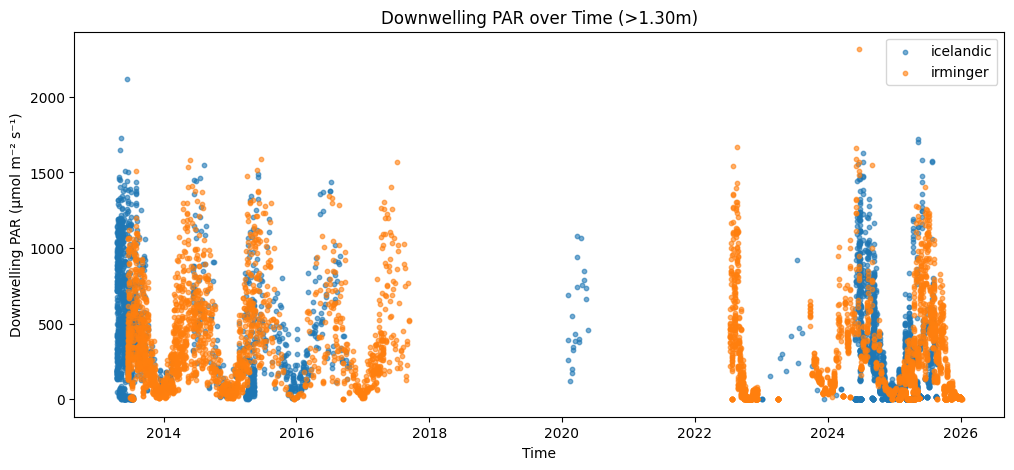

In [ ]:
# Plotting all DOWNWELLING_PAR_ADJUSTED values shallower then 1.30 m over time

df_pd = df.to_pandas()

df_pd["TIME"] = pd.to_datetime(df_pd["JULD"], utc=True, errors="coerce")
# or even: df_pd["TIME"] = df_pd["JULD"]  (if it's already datetime)

shallow_pd = df_pd[df_pd["PRES_ADJUSTED"] <= 1.3]

#df_pd = df.to_pandas()
#df_pd["TIME"] = pd.to_datetime(df_pd["TIME"])
#shallow_pd = df_pd[df_pd["PRES_ADJUSTED"] <= 1.3]
plt.figure(figsize=(12, 5))
for region_name, group in shallow_pd.groupby("region"):
    plt.scatter(
        group["TIME"],
        group["DOWNWELLING_PAR"],
        s=10,
        alpha=0.6,
        label=region_name
    )
plt.xlabel("Time")
plt.ylabel("Downwelling PAR (µmol m⁻² s⁻¹)")
plt.title("Downwelling PAR over Time (>1.30m)")
plt.legend()
plt.show()

In [ ]:
def compute_zeu(depth, Ed):
    """
    depth : 1D numpy array (m)
    Ed    : 1D numpy array (irradiance)

    Returns Z_eu (m) or NaN
    """
    #  Provides a range around 1m to find reference irradiance
    
    ref_mask = (depth >= 0) & (depth <= 1.30)
    if not np.any(ref_mask):
        return np.nan   

    Ed_ref = np.nanmean(Ed[ref_mask])
    if Ed_ref <= 0:
        return np.nan
    
    # 1% of reference irradiance
    Ed_1pct = 0.01 * Ed_ref 

    # Find where Ed crosses 1% level
    below = Ed <= Ed_1pct
    if not np.any(below):
        return np.nan

    idx = np.argmax(below)

    # Linear interpolation
    if idx == 0:
        return depth[0]

    z1, z2 = depth[idx-1], depth[idx]
    e1, e2 = Ed[idx-1], Ed[idx]

    return z1 + (Ed_1pct - e1) * (z2 - z1) / (e2 - e1)

In [ ]:
# Aggregating data sets for Z_eu calculation
profiles = (
    df
    .with_columns(pl.col("JULD").alias("TIME"))
    .filter(
        pl.col("PRES_ADJUSTED").is_not_null()
        & pl.col("DOWNWELLING_PAR").is_not_null()
    )
    .sort(["PLATFORM_NUMBER", "CYCLE_NUMBER", "PRES_ADJUSTED"])
    .group_by(["PLATFORM_NUMBER", "CYCLE_NUMBER"])
    .agg([
        pl.first("TIME").alias("TIME"),
        pl.first("region").alias("region"),
        pl.col("PRES_ADJUSTED").alias("depth"),
        pl.col("DOWNWELLING_PAR").alias("Ed"),
    ])
)


#profiles = (
#    df
#    .filter(
#        (pl.col("DOWNWELLING_PAR_ADJUSTED").is_not_null()))
#    .sort(["PLATFORM_NUMBER", "CYCLE_NUMBER", "PRES_ADJUSTED"])
#    .group_by(["PLATFORM_NUMBER", "CYCLE_NUMBER"])
#    .agg([
#        pl.first("TIME").alias("TIME"),
#        pl.first("region").alias("region"),
#        pl.col("PRES_ADJUSTED").alias("depth"),
#        pl.col("DOWNWELLING_PAR_ADJUSTED").alias("Ed"),
#    ])
#)

In [ ]:
# Compute ZEU per profile
zeu_profiles = profiles.with_columns(
    pl.struct(["depth", "Ed"]).map_elements(
        lambda s: compute_zeu(
            np.array(s["depth"]), 
            np.array(s["Ed"])),
        return_dtype=pl.Float64
    ).alias("ZEU_1PCT")
)

In [ ]:
ts = zeu_profiles.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])
ts["month"] = ts["TIME"].dt.to_period("M")

monthly_region = (
    ts.groupby(["region", "month"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

monthly_region["month"] = monthly_region["month"].dt.to_timestamp()

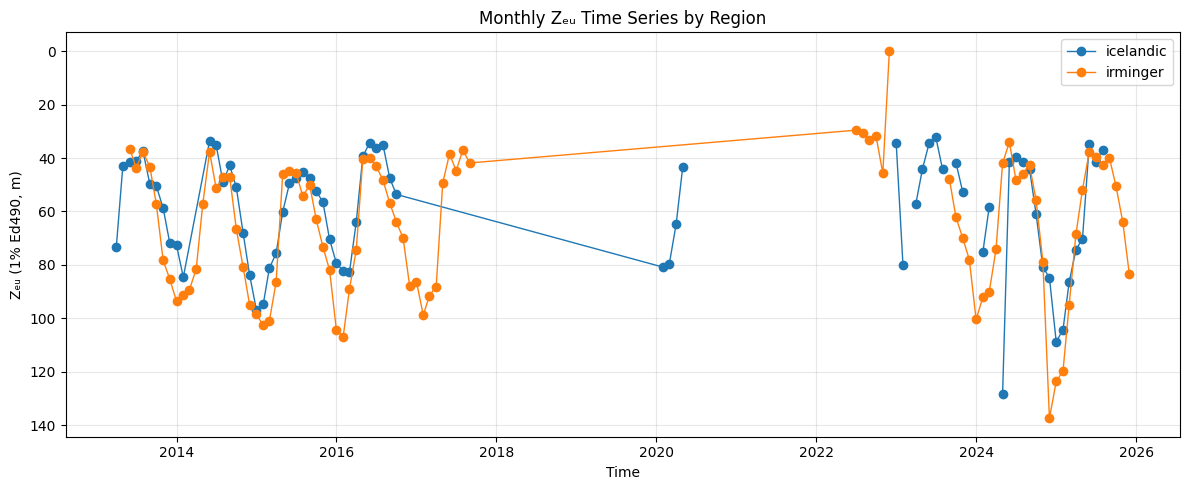

In [ ]:

plt.figure(figsize=(12,5))

for region_name, g in monthly_region.groupby("region"):
    g = g.sort_values("month")
    plt.plot(g["month"], g["ZEU_mean"], marker="o", linewidth=1, label=region_name)

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Ed490, m)")
plt.xlabel("Time")
plt.title("Monthly Zₑᵤ Time Series by Region")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Weekly ZEU calculation
ts = zeu_profiles.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])

# ISO week + ISO year (prevents mixing week 1 across different years)
iso = ts["TIME"].dt.isocalendar()
ts["iso_year"] = iso["year"]
ts["iso_week"] = iso["week"]

weekly_region = (
    ts.groupby(["region", "iso_year", "iso_week"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

# Build a representative date for plotting (Monday of each ISO week)
weekly_region["week_start"] = pd.to_datetime(
    weekly_region["iso_year"].astype(str)
    + "-W"
    + weekly_region["iso_week"].astype(str).str.zfill(2)
    + "-1",
    format="%G-W%V-%u"
)

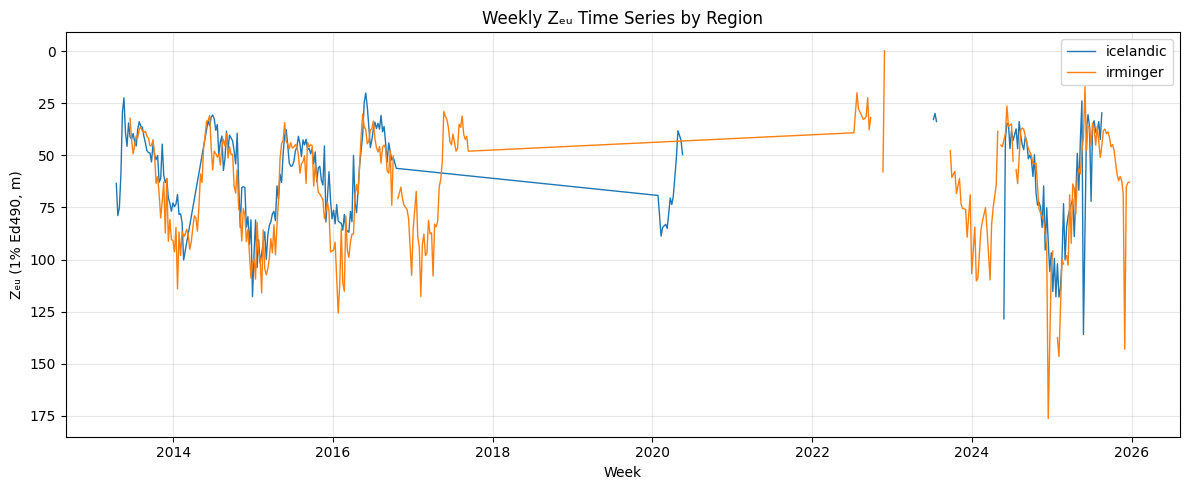

In [ ]:
plt.figure(figsize=(12,5))

for region_name, g in weekly_region.groupby("region"):
    g = g.sort_values("week_start")
    plt.plot(g["week_start"], g["ZEU_mean"], linewidth=1, label=region_name)

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Ed490, m)")
plt.xlabel("Week")
plt.title("Weekly Zₑᵤ Time Series by Region")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Cleaning ts for monthly average/weekly average plots
zeu_clean = zeu_profiles.filter(
    (pl.col("ZEU_1PCT").is_not_null()) &
    (pl.col("ZEU_1PCT") > 15) 
)

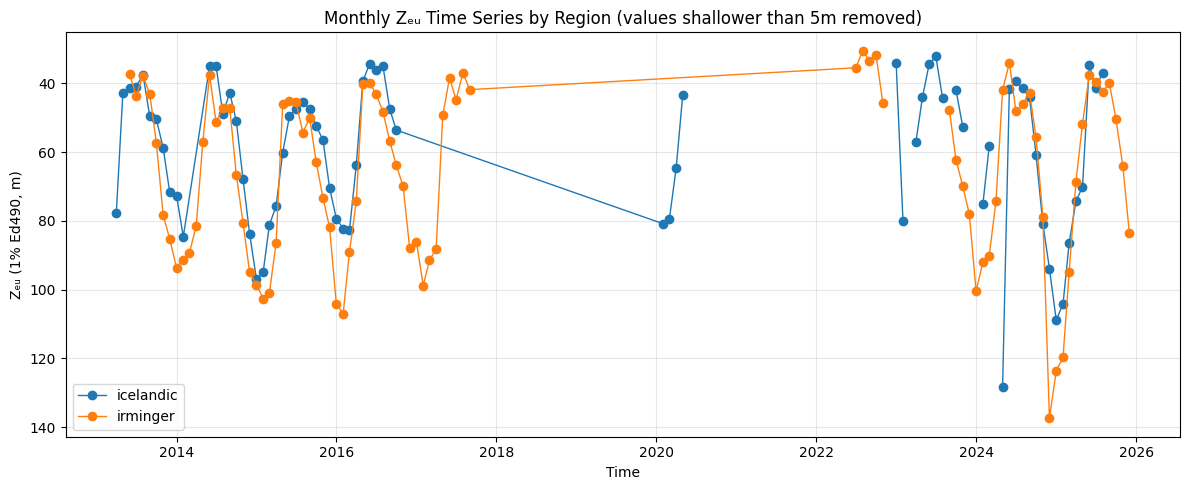

In [ ]:
ts = zeu_clean.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])
ts["month"] = ts["TIME"].dt.to_period("M")

monthly_region = (
    ts.groupby(["region", "month"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

monthly_region["month"] = monthly_region["month"].dt.to_timestamp()

plt.figure(figsize=(12,5))

for region_name, g in monthly_region.groupby("region"):
    g = g.sort_values("month")
    plt.plot(g["month"], g["ZEU_mean"], marker="o", linewidth=1, label=region_name)

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Ed490, m)")
plt.xlabel("Time")
plt.title("Monthly Zₑᵤ Time Series by Region (values shallower than 5m removed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


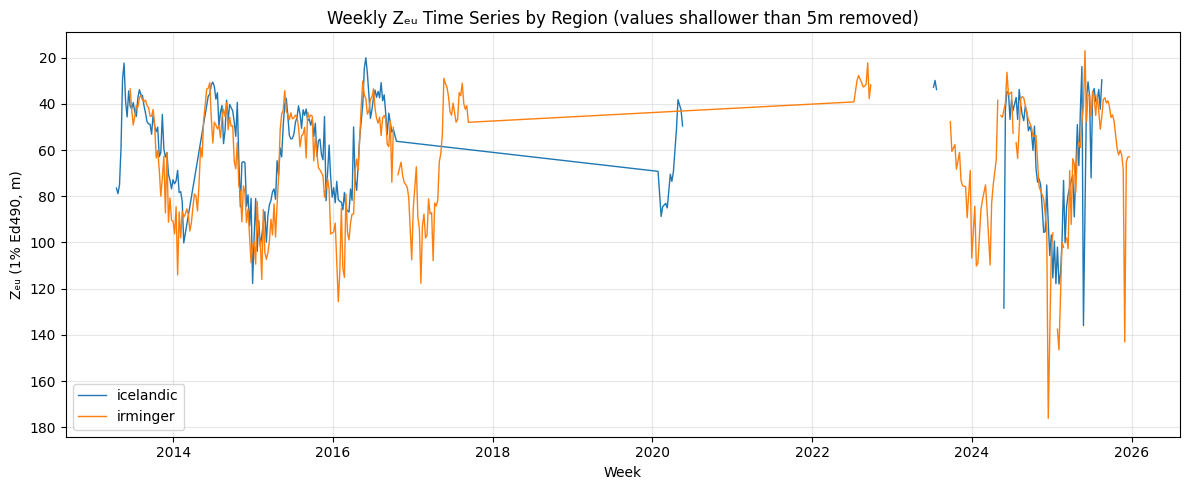

In [ ]:
# Weekly ZEU calculation
ts = zeu_clean.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])

# ISO week + ISO year (prevents mixing week 1 across different years)
iso = ts["TIME"].dt.isocalendar()
ts["iso_year"] = iso["year"]
ts["iso_week"] = iso["week"]

weekly_region = (
    ts.groupby(["region", "iso_year", "iso_week"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

# Build a representative date for plotting (Monday of each ISO week)
weekly_region["week_start"] = pd.to_datetime(
    weekly_region["iso_year"].astype(str)
    + "-W"
    + weekly_region["iso_week"].astype(str).str.zfill(2)
    + "-1",
    format="%G-W%V-%u"
)
plt.figure(figsize=(12,5))

for region_name, g in weekly_region.groupby("region"):
    g = g.sort_values("week_start")
    plt.plot(g["week_start"], g["ZEU_mean"], linewidth=1, label=region_name)

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Ed490, m)")
plt.xlabel("Week")
plt.title("Weekly Zₑᵤ Time Series by Region (values shallower than 5m removed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Creating a averaged year long timeseries
ts = zeu_clean.select(["TIME", "region", "ZEU_1PCT"]).to_pandas()
ts["TIME"] = pd.to_datetime(ts["TIME"])

iso = ts["TIME"].dt.isocalendar()
ts["iso_year"] = iso["year"]
ts["iso_week"] = iso["week"]
ts["month"] = ts["TIME"].dt.month

In [ ]:
weekly_clim = (
    ts.groupby(["region", "iso_week"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

monthly_clim = (
    ts.groupby(["region", "month"])
      .agg(
          ZEU_mean=("ZEU_1PCT", "mean"),
          ZEU_std=("ZEU_1PCT", "std"),
          n_profiles=("ZEU_1PCT", "count"),
      )
      .reset_index()
)

# Build a representative date for plotting (Monday of each ISO week) and mid-month date
weekly_clim["week_date"] = pd.to_datetime(
    "2001-W" + weekly_clim["iso_week"].astype(str).str.zfill(2) + "-1",
    format="%G-W%V-%u"
)

monthly_clim["month_date"] = pd.to_datetime(
    "2001-" + monthly_clim["month"].astype(str).str.zfill(2) + "-15"
)

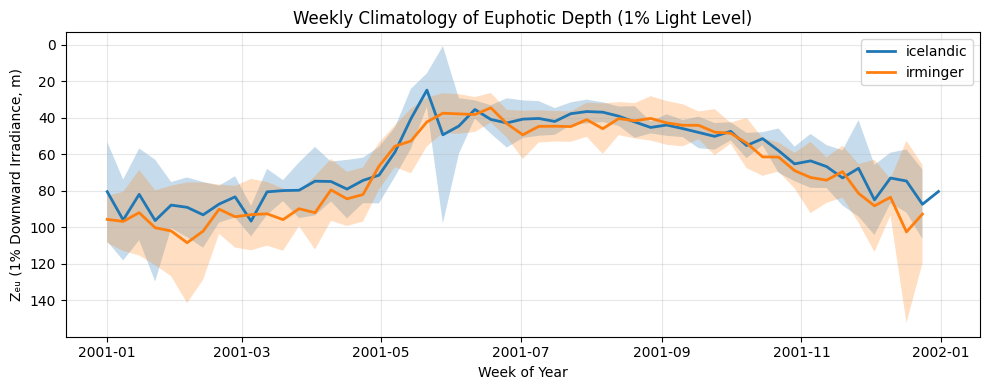

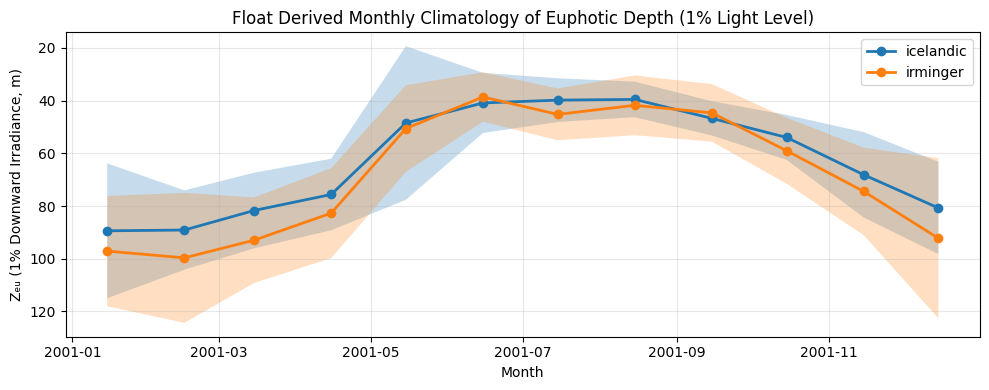

In [ ]:
# Weekly Climatology Plotting
plt.figure(figsize=(10,4))

for region_name, g in weekly_clim.groupby("region"):
    g = g.sort_values("iso_week")

    plt.plot(
        g["week_date"],
        g["ZEU_mean"],
        linewidth=2,
        label=region_name
    )

    plt.fill_between(
        g["week_date"],
        g["ZEU_mean"] - g["ZEU_std"],
        g["ZEU_mean"] + g["ZEU_std"],
        alpha=0.25
    )

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Downward Irradiance, m)")
plt.xlabel("Week of Year")
plt.title("Weekly Climatology of Euphotic Depth (1% Light Level)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Monthly Climatology Plotting
plt.figure(figsize=(10,4))

for region_name, g in monthly_clim.groupby("region"):
    g = g.sort_values("month")

    plt.plot(
        g["month_date"],
        g["ZEU_mean"],
        marker="o",
        linewidth=2,
        label=region_name
    )

    plt.fill_between(
        g["month_date"],
        g["ZEU_mean"] - g["ZEU_std"],
        g["ZEU_mean"] + g["ZEU_std"],
        alpha=0.25
    )

plt.gca().invert_yaxis()
plt.ylabel("Zₑᵤ (1% Downward Irradiance, m)")
plt.xlabel("Month")
plt.title("Float Derived Monthly Climatology of Euphotic Depth (1% Light Level)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Saving Zeu 
Saving Climatology and ts

In [ ]:
import os
# Checking and creating Zeu folder
# Create GO-BGC folders if they do not exist yet
if 'Zeu' not in os.listdir('../data/argo'):
  os.mkdir("../data/argo/Zeu")

In [ ]:
print(weekly_clim.columns)
print(monthly_clim.columns)

Index(['region', 'iso_week', 'ZEU_mean', 'ZEU_std', 'n_profiles', 'week_date'], dtype='object')
Index(['region', 'month', 'ZEU_mean', 'ZEU_std', 'n_profiles', 'month_date'], dtype='object')


In [ ]:
print(type(weekly_clim.index), weekly_clim.index.name)

<class 'pandas.core.indexes.range.RangeIndex'> None


In [ ]:

# Weekly climatology
Zeu_w_clim = weekly_clim.copy()

# Ensure week is 1–52 (some years produce ISO week 53)
Zeu_w_clim["week"] = Zeu_w_clim["iso_week"].astype(int).clip(upper=52)

# Make sure date column is datetime (optional but good)
Zeu_w_clim["week_date"] = pd.to_datetime(Zeu_w_clim["week_date"], errors="coerce")

# Monthly climatology
Zeu_m_clim = monthly_clim.copy()
Zeu_m_clim["month"] = Zeu_m_clim["month"].astype(int).clip(upper=12)
Zeu_m_clim["month_date"] = pd.to_datetime(Zeu_m_clim["month_date"], errors="coerce")

# Save to parquet
Zeu_w_clim.to_parquet("../data/argo/Zeu/Zeu_w_clim.parquet", index=False)
Zeu_m_clim.to_parquet("../data/argo/Zeu/Zeu_m_clim.parquet", index=False)

In [ ]:
# Saving Time Series
weekly_region.to_parquet("../data/argo/Zeu/Zeu_weekly_timeseries.parquet")
monthly_region.to_parquet("../data/argo/Zeu/Zeu_monthly_timeseries.parquet")

# Physical Parameters

MLD Was estiamted using gsw and Adjusted values. MLD time series was also developed, values were averaged weekly (atleast at first) 

In [15]:
import polars as pl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
import gsw



#### Producing MLD

In [16]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL_ADJUSTED"].to_numpy()
    t   = df["TEMP_ADJUSTED"].to_numpy()
    p   = df["PRES_ADJUSTED"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [17]:
# Fetching data from Parquet.
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

# Filtering data below 500m
#df = df.filter(pl.col('PRES') < 1000)

# EStimating MLD

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing MLD per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

shape: (5, 29)
┌─────────────┬─────────────┬───────────┬───────────┬───┬────────────┬──────────┬───────────┬──────┐
│ CONFIG_MISS ┆ CYCLE_NUMBE ┆ DATA_MODE ┆ DIRECTION ┆ … ┆ TIME       ┆ region   ┆ SIGMA0    ┆ MLD  │
│ ION_NUMBER  ┆ R           ┆ ---       ┆ ---       ┆   ┆ ---        ┆ ---      ┆ ---       ┆ ---  │
│ ---         ┆ ---         ┆ str       ┆ str       ┆   ┆ datetime[n ┆ str      ┆ f64       ┆ f64  │
│ i64         ┆ i64         ┆           ┆           ┆   ┆ s]         ┆          ┆           ┆      │
╞═════════════╪═════════════╪═══════════╪═══════════╪═══╪════════════╪══════════╪═══════════╪══════╡
│ 1           ┆ 311         ┆ D         ┆ A         ┆ … ┆ 2012-08-01 ┆ irminger ┆ 26.670154 ┆ 18.0 │
│             ┆             ┆           ┆           ┆   ┆ 04:37:14   ┆          ┆           ┆      │
│ 1           ┆ 311         ┆ D         ┆ A         ┆ … ┆ 2012-08-01 ┆ irminger ┆ 26.670158 ┆ 18.0 │
│             ┆             ┆           ┆           ┆   ┆ 04:37:14   ┆          ┆           ┆      │
│ 1           ┆ 311         ┆ D         ┆ A         ┆ … ┆ 2012-08-01 ┆ irminger ┆ 26.670062 ┆ 18.0 │
│             ┆             ┆           ┆           ┆   ┆ 04:37:14   ┆          ┆           ┆      │
│ 1           ┆ 311         ┆ D         ┆ A         ┆ … ┆ 2012-08-01 ┆ irminger ┆ 26.670382 ┆ 18.0 │
│             ┆             ┆           ┆           ┆   ┆ 04:37:14   ┆          ┆           ┆      │
│ 1           ┆ 311         ┆ D         ┆ A         ┆ … ┆ 2012-08-01 ┆ irminger ┆ 26.671143 ┆ 18.0 │
│             ┆             ┆           ┆           ┆   ┆ 04:37:14   ┆          ┆           ┆      │
└─────────────┴─────────────┴───────────┴───────────┴───┴────────────┴──────────┴───────────┴──────┘

#### Creating Time MLD time series 
Time series was created by using weekly averages and linear interporlation for each Region

In [18]:

# --- Separating Regions ---
irminger = df.filter(pl.col('region') == 'irminger').to_pandas()
icelandic = df.filter(pl.col('region') == 'icelandic').to_pandas()

# --- One row per (platform, cycle) profile ---
irminger = irminger.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()
icelandic = icelandic.drop_duplicates(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"]).copy()

# --- TIME to datetime ---
irminger["TIME"] = pd.to_datetime(irminger["TIME"])
icelandic["TIME"] = pd.to_datetime(icelandic["TIME"])

# --- ISO year/week ---
irminger["year"]     = irminger["TIME"].dt.isocalendar().year.astype(int)
irminger["iso_week"] = irminger["TIME"].dt.isocalendar().week.astype(int)
irminger["month"]    = irminger["TIME"].dt.month

icelandic["year"]     = icelandic["TIME"].dt.isocalendar().year.astype(int)
icelandic["iso_week"] = icelandic["TIME"].dt.isocalendar().week.astype(int)
icelandic["month"]    = icelandic["TIME"].dt.month

# --- Weekly mean + range (min/max) ---
weekly1 = (
    irminger.groupby(["year", "iso_week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)
weekly2 = (
    icelandic.groupby(["year", "iso_week"])
          .agg(MLD_mean=("MLD", "mean"),
               MLD_min=("MLD", "min"),
               MLD_max=("MLD", "max"))
          .reset_index()
)

# --- Convert ISO year-week to a date (Monday of that ISO week) ---
def iso_to_date(df):
    dates = [dt.date.fromisocalendar(int(y), int(w), 1) for y, w in zip(df["year"], df["iso_week"])]
    df = df.assign(date=pd.to_datetime(dates)).sort_values("date")
    return df

weekly1 = iso_to_date(weekly1)
weekly2 = iso_to_date(weekly2)

# Optional: drop rows where stats are all NaN (e.g., empty weeks)
weekly1 = weekly1.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])
weekly2 = weekly2.dropna(subset=["MLD_mean", "MLD_min", "MLD_max"])


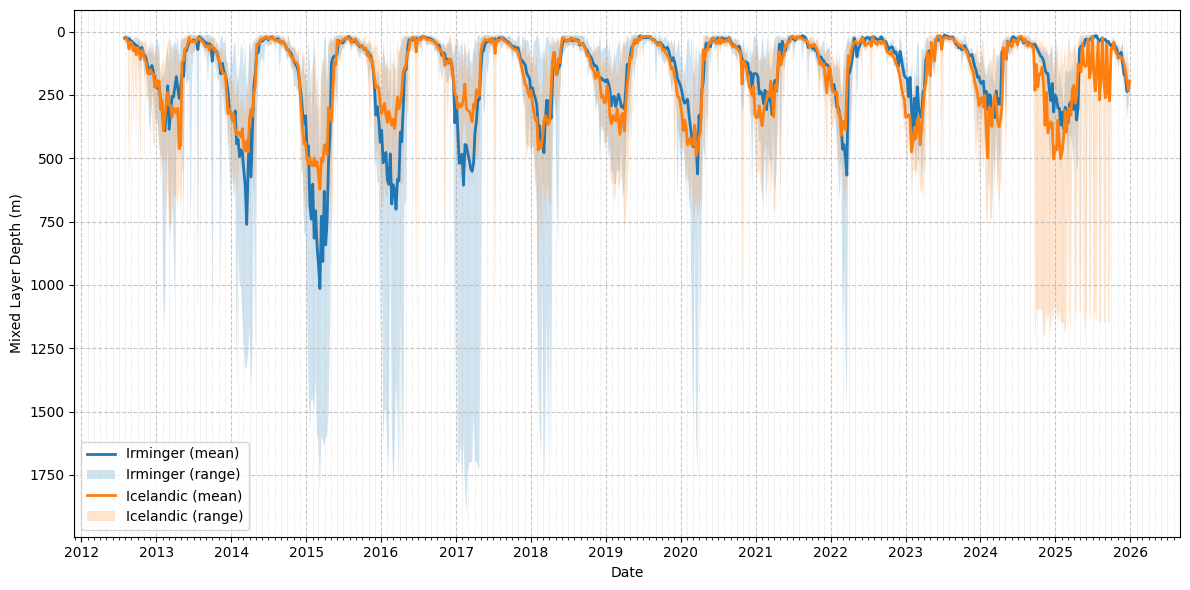

In [19]:
#Plotting 
fig, ax = plt.subplots(figsize=(12, 6))

# Irminger Mea
ax.plot(weekly1["date"], weekly1["MLD_mean"], label="Irminger (mean)", linewidth=2)
ax.fill_between(
    weekly1["date"],
    weekly1["MLD_min"],
    weekly1["MLD_max"],
    alpha=0.2,
    label="Irminger (range)"
)
# Icelandic 
ax.plot(weekly2["date"], weekly2["MLD_mean"], label="Icelandic (mean)", linewidth=2)
ax.fill_between(
    weekly2["date"],
    weekly2["MLD_min"],
    weekly2["MLD_max"],
    alpha=0.2,
    label="Icelandic (range)"
)
# Invert y-axis (MLD increases downward)
ax.invert_yaxis()

# Labels
ax.set_xlabel("Date")
ax.set_ylabel("Mixed Layer Depth (m)")

# Ticks: yearly majors, monthly minors
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_locator(MonthLocator())

# Grid
ax.grid(True, which="major", linestyle="--", linewidth=0.8, alpha=0.7)
ax.grid(True, which="minor", linestyle=":", linewidth=0.6, alpha=0.5)

# Legend
ax.legend()

fig.tight_layout()
plt.show()

In [20]:
# Creataing MLD Climatology per region

# --- Climatological weekly stats (mean, 25-75% quartiles) ---
clim1 = (
    irminger.groupby("iso_week")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)

clim2 = (
    icelandic.groupby("iso_week")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)



def week_to_date(df):
    dates = [dt.date.fromisocalendar(2020, int(w), 1) for w in df["iso_week"]]
    df["date"] = pd.to_datetime(dates)
    return df

clim1 = week_to_date(clim1)
clim2 = week_to_date(clim2)

# Make sure you have a 'month' column (if not already created earlier)
irminger["month"] = irminger["TIME"].dt.month
icelandic["month"] = icelandic["TIME"].dt.month

# --- Climatological monthly stats (mean, 25-75% quartiles) ---
clim1_m = (
    irminger.groupby("month")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)

clim2_m = (
    icelandic.groupby("month")
          .agg(
              MLD_mean=("MLD", "mean"),
              MLD_p25=("MLD", lambda x: x.quantile(0.25)),
              MLD_p75=("MLD", lambda x: x.quantile(0.75)),
          )
          .reset_index()
)

# Create a fake "climatological" date for mid-month in 2020
clim1_m["date"] = pd.to_datetime(
    dict(year=2020, month=clim1_m["month"], day=15)
)
clim2_m["date"] = pd.to_datetime(
    dict(year=2020, month=clim2_m["month"], day=15)
)
clim1_m.to_parquet('../data/argo/Region/irminger_MLD_Climatology.parquet', index=False)
clim2_m.to_parquet('../data/argo/Region/icelandic_MLD_Climatology.parquet', index=False)


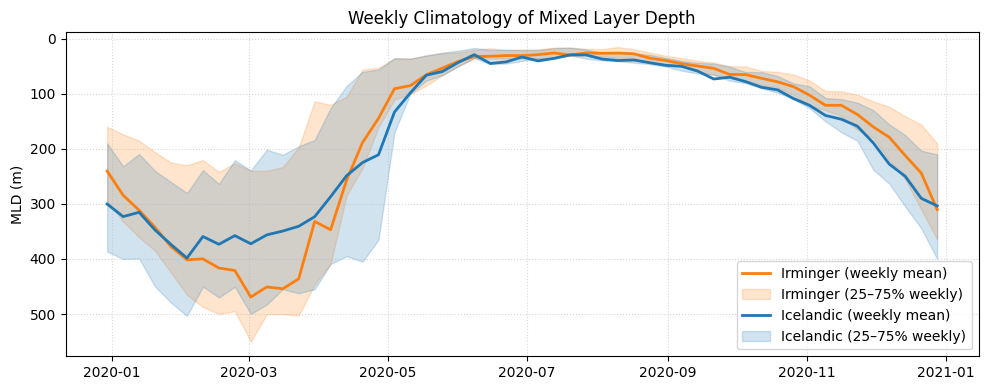

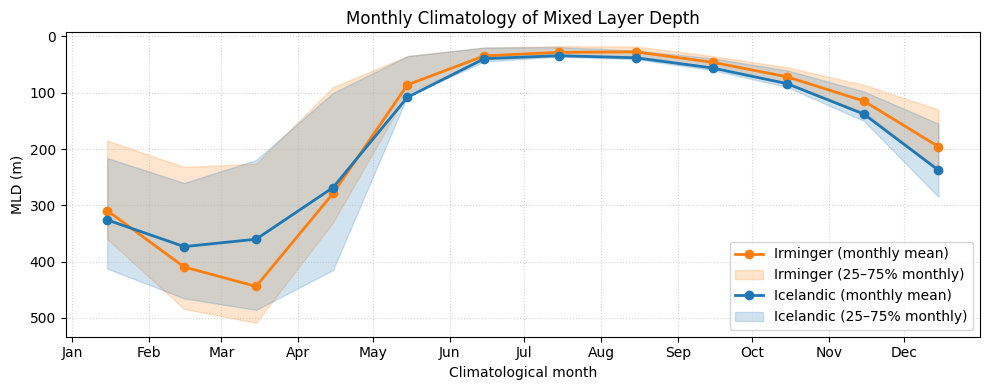

In [21]:
# ===== Weekly climatology =====
fig1, ax1 = plt.subplots(figsize=(10, 4))

# Region 1 — Irminger
ax1.plot(clim1["date"], clim1["MLD_mean"],
         linewidth=2, color="tab:orange",
         label="Irminger (weekly mean)")
ax1.fill_between(clim1["date"],
                 clim1["MLD_p25"], clim1["MLD_p75"],
                 color="tab:orange", alpha=0.2,
                 label="Irminger (25–75% weekly)")

# Region 2 — Icelandic (always blue)
ax1.plot(clim2["date"], clim2["MLD_mean"],
         linewidth=2, color="tab:blue",
         label="Icelandic (weekly mean)")
ax1.fill_between(clim2["date"],
                 clim2["MLD_p25"], clim2["MLD_p75"],
                 color="tab:blue", alpha=0.2,
                 label="Icelandic (25–75% weekly)")

ax1.invert_yaxis()
ax1.set_ylabel("MLD (m)")
ax1.set_title("Weekly Climatology of Mixed Layer Depth")
ax1.grid(True, linestyle=":", alpha=0.5)
ax1.legend()

plt.tight_layout()
plt.show()

# ===== Monthly climatology =====
fig2, ax2 = plt.subplots(figsize=(10, 4))

# Region 1 — Irminger
ax2.plot(clim1_m["date"], clim1_m["MLD_mean"],
         linewidth=2, marker="o", color="tab:orange",
         label="Irminger (monthly mean)")
ax2.fill_between(clim1_m["date"],
                 clim1_m["MLD_p25"], clim1_m["MLD_p75"],
                 color="tab:orange", alpha=0.2,
                 label="Irminger (25–75% monthly)")

# Region 2 — Icelandic (always blue)
ax2.plot(clim2_m["date"], clim2_m["MLD_mean"],
         linewidth=2, marker="o", color="tab:blue",
         label="Icelandic (monthly mean)")
ax2.fill_between(clim2_m["date"],
                 clim2_m["MLD_p25"], clim2_m["MLD_p75"],
                 color="tab:blue", alpha=0.2,
                 label="Icelandic (25–75% monthly)")

ax2.invert_yaxis()
ax2.xaxis.set_major_locator(MonthLocator())
ax2.xaxis.set_major_formatter(DateFormatter("%b"))

ax2.set_xlabel("Climatological month")
ax2.set_ylabel("MLD (m)")
ax2.set_title("Monthly Climatology of Mixed Layer Depth")
ax2.grid(True, linestyle=":", alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

### Normalized MLD and Zeu ratio

In [22]:

# --- Load Zeu monthly climatology (POLARS -> PANDAS) ---
Zeu_m_clim = pl.read_parquet("../data/argo/Zeu/Zeu_m_clim.parquet").to_pandas()

# Standardise keys
Zeu_m_clim["region"] = Zeu_m_clim["region"].astype(str).str.strip().str.lower()
Zeu_m_clim["month"]  = Zeu_m_clim["month"].astype(int)

# --- Build one MLD monthly climatology table with region labels (PANDAS) ---
mld_monthly = pd.concat([
    clim1_m.assign(region="irminger"),
    clim2_m.assign(region="icelandic")
], ignore_index=True)

mld_monthly["region"] = mld_monthly["region"].astype(str).str.strip().str.lower()
mld_monthly["month"]  = mld_monthly["month"].astype(int)

# --- Merge Zeu + MLD on region + month ---
mz_month = Zeu_m_clim.merge(
    mld_monthly[["region", "month", "MLD_mean", "MLD_p25", "MLD_p75"]],
    on=["region", "month"],
    how="inner"
)

# --- Compute ratio + bounded normalisation ---
mz_month["MLD_Zeu_ratio"]   = mz_month["MLD_mean"] / mz_month["ZEU_mean"]
mz_month["MLD_Zeu_bounded"] = mz_month["MLD_mean"] / (mz_month["MLD_mean"] + mz_month["ZEU_mean"])

mz_month.sort_values(["region", "month"]).head(12)

region  month   ZEU_mean    ZEU_std  n_profiles month_date    MLD_mean  \
0   icelandic      1  89.407650  25.588022          36 2001-01-15  325.919261   
1   icelandic      2  89.111349  15.061596          31 2001-02-15  373.339505   
2   icelandic      3  81.703774  14.349816          31 2001-03-15  360.199697   
3   icelandic      4  75.621508  13.583756         147 2001-04-15  268.435713   
4   icelandic      5  48.483524  29.152134         174 2001-05-15  108.085790   
5   icelandic      6  40.877103  11.408188         157 2001-06-15   39.567702   
6   icelandic      7  39.811289   8.302992          96 2001-07-15   34.294245   
7   icelandic      8  39.540934   6.733721          67 2001-08-15   38.008971   
8   icelandic      9  46.739213   6.503058          57 2001-09-15   56.183382   
9   icelandic     10  53.966294   8.520524          35 2001-10-15   83.988573   
10  icelandic     11  68.149531  16.205619          36 2001-11-15  138.124994   
11  icelandic     12  80.738032  17.506328          29 2001-12-15  237.673923   

       MLD_p25     MLD_p75  MLD_Zeu_ratio  MLD_Zeu_bounded  
0   216.000000  412.379990       3.645317         0.784729  
1   260.249992  465.224998       4.189584         0.807306  
2   219.699997  485.750000       4.408605         0.815109  
3   100.300003  415.000000       3.549727         0.780207  
4    35.000000  106.000000       2.229330         0.690338  
5    19.700001   44.599998       0.967967         0.491861  
6    19.150001   36.000000       0.861420         0.462776  
7    25.000000   40.599998       0.961256         0.490123  
8    38.988001   60.099998       1.202061         0.545880  
9    60.400002   90.000000       1.556315         0.608812  
10   97.950001  150.200005       2.026793         0.669617  
11  155.000000  285.000000       2.943767         0.746435

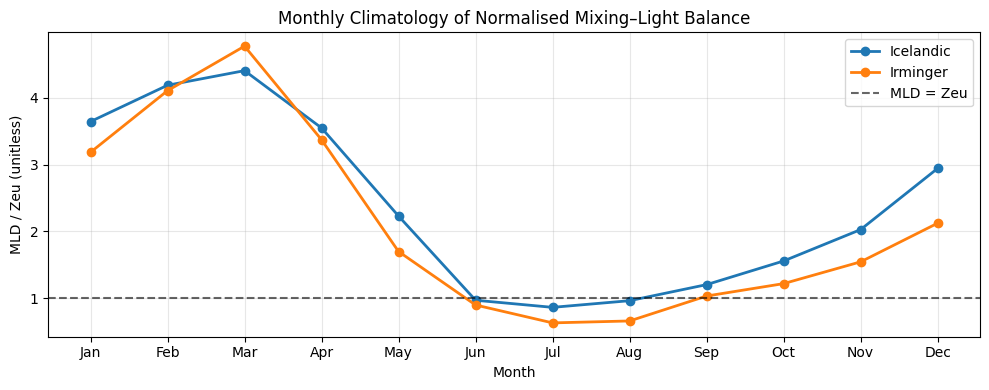

In [23]:

plt.figure(figsize=(10,4))

for region_name, g in mz_month.groupby("region"):
    g = g.sort_values("month")

    plt.plot(
        g["month"],
        g["MLD_Zeu_ratio"],
        marker="o",
        linewidth=2,
        label=region_name.capitalize()
    )

# Critical threshold: MLD = Zeu
plt.axhline(1.0, linestyle="--", color="k", alpha=0.6, label="MLD = Zeu")

plt.xlabel("Month")
plt.ylabel("MLD / Zeu (unitless)")
plt.title("Monthly Climatology of Normalised Mixing–Light Balance")
plt.xticks(np.arange(1, 13),
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:

# --- Load Zeu weekly climatology (POLARS -> PANDAS) ---
Zeu_w_clim = pl.read_parquet("../data/argo/Zeu/Zeu_w_clim.parquet").to_pandas()

# Standardise merge keys
Zeu_w_clim["region"]   = Zeu_w_clim["region"].astype(str).str.strip().str.lower()
Zeu_w_clim["iso_week"] = Zeu_w_clim["iso_week"].astype(int)

# --- Build one MLD weekly climatology table with region labels ---
mld_weekly = pd.concat([
    clim1.assign(region="irminger"),
    clim2.assign(region="icelandic")
], ignore_index=True)

mld_weekly["region"]   = mld_weekly["region"].astype(str).str.strip().str.lower()
mld_weekly["iso_week"] = mld_weekly["iso_week"].astype(int)

# --- Merge Zeu + MLD on region + iso_week ---
mz_week = Zeu_w_clim.merge(
    mld_weekly[["region", "iso_week", "MLD_mean", "MLD_p25", "MLD_p75"]],
    on=["region", "iso_week"],
    how="inner"
)

# --- Compute ratio + bounded normalisation ---
mz_week["MLD_Zeu_ratio"]   = mz_week["MLD_mean"] / mz_week["ZEU_mean"]
mz_week["MLD_Zeu_bounded"] = mz_week["MLD_mean"] / (mz_week["MLD_mean"] + mz_week["ZEU_mean"])

mz_week.sort_values(["region", "iso_week"]).head(15)

region  iso_week   ZEU_mean    ZEU_std  n_profiles  week_date  week  \
0   icelandic         1  80.487889  27.268188           8 2001-01-01     1   
1   icelandic         2  95.998304  22.175695           9 2001-01-08     2   
2   icelandic         3  81.945847  25.119218           7 2001-01-15     3   
3   icelandic         4  96.306628  33.396981           8 2001-01-22     4   
4   icelandic         5  87.833441  12.621241           7 2001-01-29     5   
5   icelandic         6  89.051521  16.400930           7 2001-02-05     6   
6   icelandic         7  93.174441  17.993431          12 2001-02-12     7   
7   icelandic         8  87.285418  10.102937           7 2001-02-19     8   
8   icelandic         9  83.317454  11.293981           5 2001-02-26     9   
9   icelandic        10  96.599878   8.374414           5 2001-03-05    10   
10  icelandic        11  80.576719  12.575333           5 2001-03-12    11   
11  icelandic        12  79.885765   5.747013           6 2001-03-19    12   
12  icelandic        13  79.689892  15.253427           8 2001-03-26    13   
13  icelandic        14  74.722641  18.789619          18 2001-04-02    14   
14  icelandic        15  74.901789  10.926567          17 2001-04-09    15   

      MLD_mean     MLD_p25     MLD_p75  MLD_Zeu_ratio  MLD_Zeu_bounded  
0   300.097426  190.000000  386.500000       3.728479         0.788516  
1   323.018724  231.775005  399.949997       3.364838         0.770896  
2   315.187724  209.324997  399.049995       3.846293         0.793657  
3   347.449823  240.000000  450.000000       3.607746         0.782974  
4   373.621875  260.324989  479.344994       4.253754         0.809660  
5   398.284035  280.149994  503.549995       4.472512         0.817269  
6   359.229010  238.650002  450.150009       3.855446         0.794046  
7   373.357461  263.525002  469.967506       4.277432         0.810514  
8   357.606518  220.424995  450.575005       4.292096         0.811039  
9   372.425670  239.325001  499.724998       3.855343         0.794041  
10  356.285001  201.414997  482.969994       4.421687         0.815556  
11  349.283790  210.739998  455.000000       4.372291         0.813860  
12  340.624058  195.250000  462.269997       4.274370         0.810404  
13  323.232725  183.849998  455.000000       4.325767         0.812234  
14  286.896086  126.000000  409.174988       3.830297         0.792973

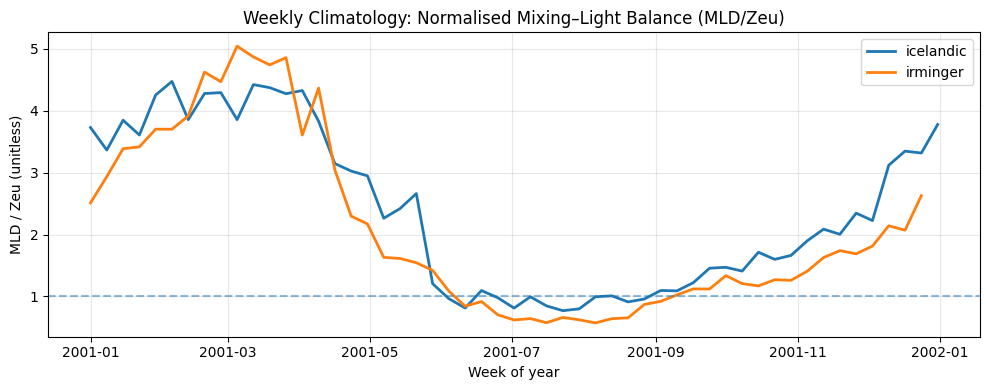

In [25]:
plt.figure(figsize=(10,4))
for region_name, g in mz_week.groupby("region"):
    g = g.sort_values("iso_week")
    # use Zeu_w_clim's week_date if you have it; otherwise iso_week works fine
    x = g["week_date"] if "week_date" in g.columns else g["iso_week"]
    plt.plot(x, g["MLD_Zeu_ratio"], linewidth=2, label=region_name)

plt.axhline(1, linestyle="--", alpha=0.5)
plt.ylabel("MLD / Zeu (unitless)")
plt.xlabel("Week of year")
plt.title("Weekly Climatology: Normalised Mixing–Light Balance (MLD/Zeu)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# BGC-Chlorophyll Analysis
Here we conduct Analysis on BGC-CHLA analysis

In [249]:
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [250]:
df = pl.read_parquet('../data/argo/Region/Regional_BGC-Argo_Tablet.parquet')

# QC Filtering on CHLA_ADJUSTED data
df = df.filter(pl.col('CHLA_ADJUSTED_QC').is_in([1,2]))  # Keep only good and probably good data

# Filtering Negative and zero CHLA values
df = df.filter(pl.col('CHLA_ADJUSTED') > 0)

# Filtering Date after 2020-01-01
#df = df.filter(pl.col('TIME') > dt.datetime(2020, 1, 1))

# Adjusting CHLA values reducing by a a factor of 4
#df = df.with_columns(
#    (pl.col('CHLA_ADJUSTED') / 4).alias('CHLA_ADJUSTED')
#)

#Filtering out extreme CHLA values above 10 mg/m3
#df = df.filter(
#    pl.col("CHLA_ADJUSTED") <= 10#
#)

# Filtering Irminger and 2
df = df.filter(pl.col('region') != 'Other')


In [251]:
# Listing headers
print("Listing headers:")
print(df.columns)

Listing headers:
['BBP532', 'BBP532_ADJUSTED', 'BBP532_ADJUSTED_ERROR', 'BBP532_ADJUSTED_QC', 'BBP532_DATA_MODE', 'BBP532_QC', 'BBP700', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_ERROR', 'BBP700_ADJUSTED_QC', 'BBP700_DATA_MODE', 'BBP700_QC', 'BISULFIDE', 'BISULFIDE_ADJUSTED', 'BISULFIDE_ADJUSTED_ERROR', 'BISULFIDE_ADJUSTED_QC', 'BISULFIDE_DATA_MODE', 'BISULFIDE_QC', 'CDOM', 'CDOM_ADJUSTED', 'CDOM_ADJUSTED_ERROR', 'CDOM_ADJUSTED_QC', 'CDOM_DATA_MODE', 'CDOM_QC', 'CHLA', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_ERROR', 'CHLA_ADJUSTED_QC', 'CHLA_DATA_MODE', 'CHLA_QC', 'CONFIG_MISSION_NUMBER', 'CP660', 'CP660_ADJUSTED', 'CP660_ADJUSTED_ERROR', 'CP660_ADJUSTED_QC', 'CP660_DATA_MODE', 'CP660_QC', 'CYCLE_NUMBER', 'DIRECTION', 'DOWNWELLING_PAR', 'DOWNWELLING_PAR_ADJUSTED', 'DOWNWELLING_PAR_ADJUSTED_ERROR', 'DOWNWELLING_PAR_ADJUSTED_QC', 'DOWNWELLING_PAR_DATA_MODE', 'DOWNWELLING_PAR_QC', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE380_ADJUSTED', 'DOWN_IRRADIANCE380_ADJUSTED_ERROR', 'DOWN_IRRADIANCE380_ADJUSTED_QC',

### Depth Integrating CHL-a

In [252]:
# Creating a depth integrated Chlorophyll column dataframe

# Filtering the between 10m to 500m. (Including, typical euphotic zone depth and avoiding surface [<10m] Tanner et al. 2024)
# Sorting by Depth and profile

float_keys = ["PLATFORM_NUMBER", "CYCLE_NUMBER"]

integrated = (
    df.group_by(float_keys, maintain_order=True)
      .agg(pl.col("CHLA_ADJUSTED").mean().alias("DEPTH_INT_CHL"))
)

integrated_5m = (
    df.filter(pl.col("PRES_ADJUSTED") <= 5)
      .group_by(float_keys, maintain_order=True)
      .agg(pl.col("CHLA_ADJUSTED").mean().alias("DEPTH_INT_CHL_5m"))
)

integrated_sur = (
    df.filter(pl.col("PRES_ADJUSTED") <= 10)
      .group_by(float_keys, maintain_order=True)
      .agg(pl.col("CHLA_ADJUSTED").mean().alias("DEPTH_INT_CHL_sur"))
)

# Integrating CHLA_ADJUSTED Trappazoid Method

#df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER", maintain_order=True).map_groups(lambda g: pl.DataFrame({
#    "PLATFORM_NUMBER": [g["PLATFORM_NUMBER"][0]],
#    "CYCLE_NUMBER": [g["CYCLE_NUMBER"][0]],
#    "DEPTH_INT_CHL": [np.trapezoid(
#                    g["CHLA_ADJUSTED"].to_numpy(),
#                    g["PRES_ADJUSTED"].to_numpy())],}))

# Integrating CHLA_ADJUSTED by just mean CHL



In [253]:
# Furher analysis and plotting can be done based on 'integrated' DataFrame
# Joining CHL replicating to dataframe
df = df.join(integrated, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")
df = df.join(integrated_5m, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")
df = df.join(integrated_sur, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

shape: (5, 109)
┌────────┬────────────┬────────────┬────────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ BBP532 ┆ BBP532_ADJ ┆ BBP532_ADJ ┆ BBP532_ADJ ┆ … ┆ region   ┆ DEPTH_INT ┆ DEPTH_INT ┆ DEPTH_INT │
│ ---    ┆ USTED      ┆ USTED_ERRO ┆ USTED_QC   ┆   ┆ ---      ┆ _CHL      ┆ _CHL_5m   ┆ _CHL_sur  │
│ f32    ┆ ---        ┆ R          ┆ ---        ┆   ┆ str      ┆ ---       ┆ ---       ┆ ---       │
│        ┆ f32        ┆ ---        ┆ i64        ┆   ┆          ┆ f32       ┆ f32       ┆ f32       │
│        ┆            ┆ f32        ┆            ┆   ┆          ┆           ┆           ┆           │
╞════════╪════════════╪════════════╪════════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ null   ┆ null       ┆ null       ┆ 99999      ┆ … ┆ irminger ┆ 0.358     ┆ null      ┆ null      │
│ null   ┆ null       ┆ null       ┆ 99999      ┆ … ┆ irminger ┆ 0.358     ┆ null      ┆ null      │
│ null   ┆ null       ┆ null       ┆ 99999      ┆ … ┆ irminger ┆ 0.358     ┆ null      ┆ null      │
│ null   ┆ null       ┆ null       ┆ 99999      ┆ … ┆ irminger ┆ 0.358     ┆ null      ┆ null      │
│ null   ┆ null       ┆ null       ┆ 99999      ┆ … ┆ irminger ┆ 0.358     ┆ null      ┆ null      │
└────────┴────────────┴────────────┴────────────┴───┴──────────┴───────────┴───────────┴───────────┘

In [254]:
# Keep one row per profile for climatology
profiles = (
    df
    .select([
        "PLATFORM_NUMBER",
        "CYCLE_NUMBER",
        "DEPTH_INT_CHL",
        "DEPTH_INT_CHL_5m",
        "DEPTH_INT_CHL_sur",
        "TIME",        
        "LATITUDE",
        "LONGITUDE",
        "region",
        "PRES_ADJUSTED",
    ])
    .unique(subset=["PLATFORM_NUMBER", "CYCLE_NUMBER"])
    .filter(pl.col("DEPTH_INT_CHL").is_not_null())
)

# Adding month to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.month().alias("month")   # 1–12
)

# Adding Week to each profile
profiles = profiles.with_columns(
    pl.col("TIME").dt.week().alias("week")   # 1–52
)
profiles.head()


shape: (5, 12)
┌─────────────┬─────────────┬─────────────┬────────────┬───┬───────────┬────────────┬───────┬──────┐
│ PLATFORM_NU ┆ CYCLE_NUMBE ┆ DEPTH_INT_C ┆ DEPTH_INT_ ┆ … ┆ region    ┆ PRES_ADJUS ┆ month ┆ week │
│ MBER        ┆ R           ┆ HL          ┆ CHL_5m     ┆   ┆ ---       ┆ TED        ┆ ---   ┆ ---  │
│ ---         ┆ ---         ┆ ---         ┆ ---        ┆   ┆ str       ┆ ---        ┆ i8    ┆ i8   │
│ i64         ┆ i64         ┆ f32         ┆ f32        ┆   ┆           ┆ f32        ┆       ┆      │
╞═════════════╪═════════════╪═════════════╪════════════╪═══╪═══════════╪════════════╪═══════╪══════╡
│ 4903659     ┆ 35          ┆ 0.027144    ┆ null       ┆ … ┆ icelandic ┆ 48.108337  ┆ 10    ┆ 42   │
│ 6901647     ┆ 356         ┆ 0.023941    ┆ null       ┆ … ┆ irminger  ┆ 23.120001  ┆ 9     ┆ 36   │
│ 6904240     ┆ 84          ┆ 0.226504    ┆ null       ┆ … ┆ irminger  ┆ 12.390811  ┆ 8     ┆ 33   │
│ 6900876     ┆ 20          ┆ 0.050104    ┆ null       ┆ … ┆ icelandic ┆ 6.8        ┆ 10    ┆ 40   │
│ 6901519     ┆ 152         ┆ 0.051904    ┆ null       ┆ … ┆ irminger  ┆ 9.84       ┆ 11    ┆ 47   │
└─────────────┴─────────────┴─────────────┴────────────┴───┴───────────┴────────────┴───────┴──────┘

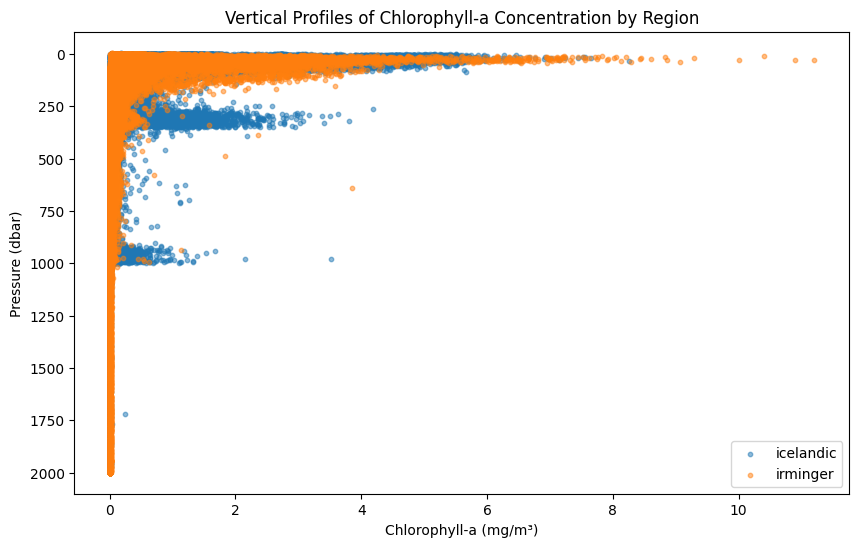

In [255]:
# Plotting scatter plot of vertical profiles of CHLA_ADJUSTED vs Depth per region
fig, ax = plt.subplots(figsize=(10, 6))
for region, group in df.to_pandas().groupby("region"):
    sc = ax.scatter(
        group["CHLA_ADJUSTED"],
        group["PRES_ADJUSTED"],
        s=10,
        alpha=0.5,
        label=region
    )
ax.invert_yaxis()
ax.set_xlabel("Chlorophyll-a (mg/m³)")
ax.set_ylabel("Pressure (dbar)")
ax.set_title("Vertical Profiles of Chlorophyll-a Concentration by Region")
ax.legend()
plt.show()

In [256]:
# Measuring how many profiles have a depth value of 1m or less 
print(f"Total Number of profiles: {df.select(['PLATFORM_NUMBER', 'CYCLE_NUMBER']).unique().height}")
print(f"Number of profiles with a depth value of 1m: {df.filter(pl.col('PRES_ADJUSTED') <= 1).select(['PLATFORM_NUMBER', 'CYCLE_NUMBER']).unique().height}")   

Total Number of profiles: 2606
Number of profiles with a depth value of 1m: 100


### Creating a Zeu integrated

In [257]:
Zeu_w_clim = pl.read_parquet("../data/argo/Zeu/Zeu_w_clim.parquet")
Zeu_m_clim = pl.read_parquet("../data/argo/Zeu/Zeu_m_clim.parquet")

Zeu_monthly_timeseries = pl.read_parquet("../data/argo/Zeu/Zeu_monthly_timeseries.parquet")
Zeu_weekly_timeseries = pl.read_parquet("../data/argo/Zeu/Zeu_weekly_timeseries.parquet")

In [258]:
profiles = profiles.with_columns(
    pl.col("TIME").dt.week().alias("week")
)

In [259]:
profiles

shape: (2_606, 12)
┌─────────────┬─────────────┬─────────────┬────────────┬───┬───────────┬────────────┬───────┬──────┐
│ PLATFORM_NU ┆ CYCLE_NUMBE ┆ DEPTH_INT_C ┆ DEPTH_INT_ ┆ … ┆ region    ┆ PRES_ADJUS ┆ month ┆ week │
│ MBER        ┆ R           ┆ HL          ┆ CHL_5m     ┆   ┆ ---       ┆ TED        ┆ ---   ┆ ---  │
│ ---         ┆ ---         ┆ ---         ┆ ---        ┆   ┆ str       ┆ ---        ┆ i8    ┆ i8   │
│ i64         ┆ i64         ┆ f32         ┆ f32        ┆   ┆           ┆ f32        ┆       ┆      │
╞═════════════╪═════════════╪═════════════╪════════════╪═══╪═══════════╪════════════╪═══════╪══════╡
│ 4903659     ┆ 35          ┆ 0.027144    ┆ null       ┆ … ┆ icelandic ┆ 48.108337  ┆ 10    ┆ 42   │
│ 6901647     ┆ 356         ┆ 0.023941    ┆ null       ┆ … ┆ irminger  ┆ 23.120001  ┆ 9     ┆ 36   │
│ 6904240     ┆ 84          ┆ 0.226504    ┆ null       ┆ … ┆ irminger  ┆ 12.390811  ┆ 8     ┆ 33   │
│ 6900876     ┆ 20          ┆ 0.050104    ┆ null       ┆ … ┆ icelandic ┆ 6.8        ┆ 10    ┆ 40   │
│ 6901519     ┆ 152         ┆ 0.051904    ┆ null       ┆ … ┆ irminger  ┆ 9.84       ┆ 11    ┆ 47   │
│ …           ┆ …           ┆ …           ┆ …          ┆ … ┆ …         ┆ …          ┆ …     ┆ …    │
│ 4903365     ┆ 6           ┆ 0.046156    ┆ 0.589238   ┆ … ┆ irminger  ┆ 2.75       ┆ 10    ┆ 39   │
│ 6901515     ┆ 18          ┆ 0.171292    ┆ null       ┆ … ┆ icelandic ┆ 61.420002  ┆ 5     ┆ 20   │
│ 6901647     ┆ 136         ┆ 0.162205    ┆ null       ┆ … ┆ icelandic ┆ 40.32      ┆ 4     ┆ 17   │
│ 6901520     ┆ 23          ┆ 1.048812    ┆ null       ┆ … ┆ icelandic ┆ 25.32      ┆ 5     ┆ 21   │
│ 6901517     ┆ 56          ┆ 0.087457    ┆ null       ┆ … ┆ icelandic ┆ 37.82      ┆ 6     ┆ 26   │
└─────────────┴─────────────┴─────────────┴────────────┴───┴───────────┴────────────┴───────┴──────┘

In [260]:
Zeu_w_clim = pl.read_parquet("../data/argo/Zeu/Zeu_w_clim.parquet").with_columns(
    pl.col("iso_week").alias("week")
).drop("iso_week")

In [261]:
df_int = (
    df
    .with_columns(pl.col("TIME").dt.week().alias("week"))
    .join(
        Zeu_w_clim.select(["region", "week", "ZEU_mean"]),
        on=["region", "week"],
        how="left",
    )
    .rename({"ZEU_mean": "ZEU"})
)

In [262]:

def _integrate_profile_to_zeu(g: pl.DataFrame) -> pl.DataFrame:
    # get identifiers
    plat = g["PLATFORM_NUMBER"][0]
    cyc  = g["CYCLE_NUMBER"][0]
    region = g["region"][0]
    week = g["week"][0]

    # Zeu for this profile (same for all rows after join)
    zeu = g["ZEU"][0]
    if zeu is None:
        return pl.DataFrame({
            "PLATFORM_NUMBER":[plat],
            "CYCLE_NUMBER":[cyc],
            "region":[region],
            "week":[week],
            "ZEU":[None],
            "INT_CHL_ZEU":[None],
        })

    # pull arrays
    z = g["PRES_ADJUSTED"].to_numpy()
    c = g["CHLA_ADJUSTED"].to_numpy()

    # mask finite
    m = np.isfinite(z) & np.isfinite(c)
    z = z[m]; c = c[m]

    if z.size < 2:
        return pl.DataFrame({
            "PLATFORM_NUMBER":[plat],
            "CYCLE_NUMBER":[cyc],
            "region":[region],
            "week":[week],
            "ZEU":[float(zeu)],
            "INT_CHL_ZEU":[None],
        })

    # sort by depth
    order = np.argsort(z)
    z = z[order]; c = c[order]

    zeu = float(zeu)

    # if zeu shallower than shallowest observation, can't integrate properly
    if zeu <= z.min():
        return pl.DataFrame({
            "PLATFORM_NUMBER":[plat],
            "CYCLE_NUMBER":[cyc],
            "region":[region],
            "week":[week],
            "ZEU":[zeu],
            "INT_CHL_ZEU":[None],
        })

    # keep points shallower than zeu
    keep = z <= zeu
    z_cut = z[keep]
    c_cut = c[keep]

    # if zeu deeper than deepest observation, integrate to deepest only (or you could return None)
    if z_cut.size < 2:
        return pl.DataFrame({
            "PLATFORM_NUMBER":[plat],
            "CYCLE_NUMBER":[cyc],
            "region":[region],
            "week":[week],
            "ZEU":[zeu],
            "INT_CHL_ZEU":[None],
        })

    # append interpolated point at zeu if last point is shallower than zeu
    if z_cut[-1] < zeu:
        # find first index deeper than zeu in original sorted arrays
        j = np.searchsorted(z, zeu)
        if j < len(z):
            z1, z2 = z[j-1], z[j]
            c1, c2 = c[j-1], c[j]
            # linear interp
            c_zeu = c1 + (c2 - c1) * (zeu - z1) / (z2 - z1)
        else:
            # no deeper point exists; hold last value
            c_zeu = c_cut[-1]

        z_cut = np.append(z_cut, zeu)
        c_cut = np.append(c_cut, c_zeu)

    # trapezoid integrate
    int_chl = float(np.nanmean(c_cut))

    return pl.DataFrame({
        "PLATFORM_NUMBER":[plat],
        "CYCLE_NUMBER":[cyc],
        "region":[region],
        "week":[week],
        "ZEU":[zeu],
        "INT_CHL_ZEU":[int_chl],
    })

In [263]:
integrated_zeu_profiles = (
    df_int
    .filter(pl.col("ZEU").is_not_null())
    .group_by("PLATFORM_NUMBER", "CYCLE_NUMBER", maintain_order=True)
    .map_groups(_integrate_profile_to_zeu)
)

In [264]:
profiles = (
    profiles
    .join(
        integrated_zeu_profiles.select(["PLATFORM_NUMBER","CYCLE_NUMBER","INT_CHL_ZEU","ZEU"]),
        on=["PLATFORM_NUMBER","CYCLE_NUMBER"],
        how="left",
    )
)

In [265]:
profiles

shape: (2_606, 14)
┌─────────────┬─────────────┬─────────────┬────────────┬───┬───────┬──────┬────────────┬───────────┐
│ PLATFORM_NU ┆ CYCLE_NUMBE ┆ DEPTH_INT_C ┆ DEPTH_INT_ ┆ … ┆ month ┆ week ┆ INT_CHL_ZE ┆ ZEU       │
│ MBER        ┆ R           ┆ HL          ┆ CHL_5m     ┆   ┆ ---   ┆ ---  ┆ U          ┆ ---       │
│ ---         ┆ ---         ┆ ---         ┆ ---        ┆   ┆ i8    ┆ i8   ┆ ---        ┆ f64       │
│ i64         ┆ i64         ┆ f32         ┆ f32        ┆   ┆       ┆      ┆ f64        ┆           │
╞═════════════╪═════════════╪═════════════╪════════════╪═══╪═══════╪══════╪════════════╪═══════════╡
│ 4903659     ┆ 35          ┆ 0.027144    ┆ null       ┆ … ┆ 10    ┆ 42   ┆ 0.431203   ┆ 51.402276 │
│ 6901647     ┆ 356         ┆ 0.023941    ┆ null       ┆ … ┆ 9     ┆ 36   ┆ 0.458035   ┆ 42.764739 │
│ 6904240     ┆ 84          ┆ 0.226504    ┆ null       ┆ … ┆ 8     ┆ 33   ┆ 1.093315   ┆ 40.417845 │
│ 6900876     ┆ 20          ┆ 0.050104    ┆ null       ┆ … ┆ 10    ┆ 40   ┆ 0.265541   ┆ 47.405747 │
│ 6901519     ┆ 152         ┆ 0.051904    ┆ null       ┆ … ┆ 11    ┆ 47   ┆ 0.120135   ┆ 69.475749 │
│ …           ┆ …           ┆ …           ┆ …          ┆ … ┆ …     ┆ …    ┆ …          ┆ …         │
│ 4903365     ┆ 6           ┆ 0.046156    ┆ 0.589238   ┆ … ┆ 10    ┆ 39   ┆ 0.586763   ┆ 47.849573 │
│ 6901515     ┆ 18          ┆ 0.171292    ┆ null       ┆ … ┆ 5     ┆ 20   ┆ null       ┆ 40.494958 │
│ 6901647     ┆ 136         ┆ 0.162205    ┆ null       ┆ … ┆ 4     ┆ 17   ┆ 0.558522   ┆ 74.307009 │
│ 6901520     ┆ 23          ┆ 1.048812    ┆ null       ┆ … ┆ 5     ┆ 21   ┆ null       ┆ 24.804479 │
│ 6901517     ┆ 56          ┆ 0.087457    ┆ null       ┆ … ┆ 6     ┆ 26   ┆ 1.100443   ┆ 42.801958 │
└─────────────┴─────────────┴─────────────┴────────────┴───┴───────┴──────┴────────────┴───────────┘

### CHL Time series

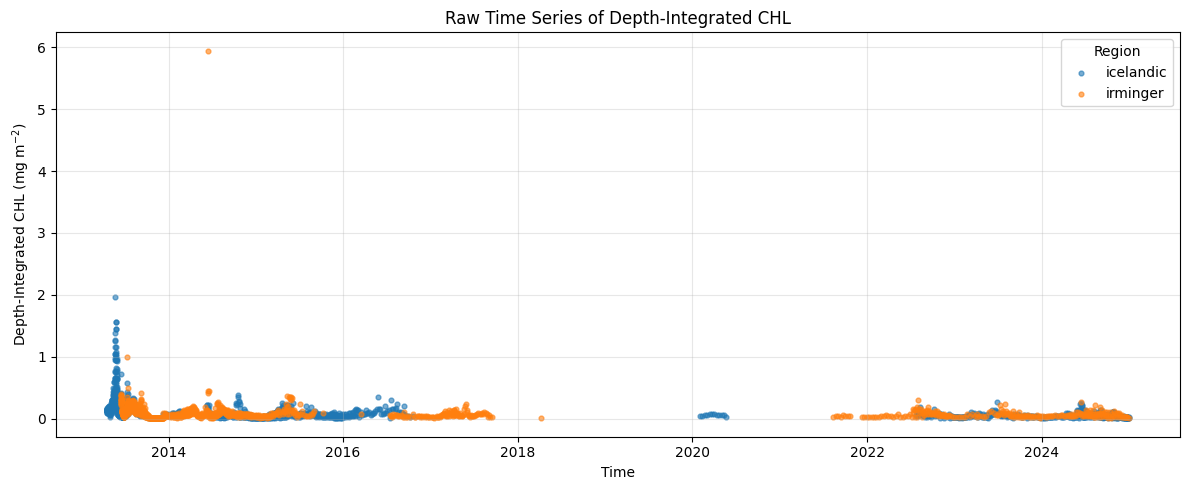

In [266]:
# Plotting a CHL time series per region
profiles_pd = profiles.to_pandas()
profiles_pd["TIME"] = pd.to_datetime(profiles_pd["TIME"])

plt.figure(figsize=(12, 5))

for region_name, group in profiles_pd.groupby("region"):
    plt.scatter(
        group["TIME"],
        group["DEPTH_INT_CHL"],
        s=12,
        alpha=0.6,
        label=region_name
    )

plt.title("Raw Time Series of Depth-Integrated CHL")
plt.xlabel("Time")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

# Wee


In [267]:
profiles_pd["year"] = profiles_pd["TIME"].dt.year
profiles_pd["week"] = profiles_pd["TIME"].dt.isocalendar().week.astype(int)

weekly_ts = (
    profiles_pd
    .groupby(["region", "year", "week"])
    .agg(
        DEPTH_INT_CHL_mean=("DEPTH_INT_CHL", "mean"),
        DEPTH_INT_CHL_std=("DEPTH_INT_CHL", "std"),
        n_profiles=("DEPTH_INT_CHL", "size"),
    )
    .reset_index()
)

weekly_ts["date"] = pd.to_datetime(
    weekly_ts["year"].astype(str) + "-W" +
    weekly_ts["week"].astype(str) + "-1",
    format="%G-W%V-%u"
)

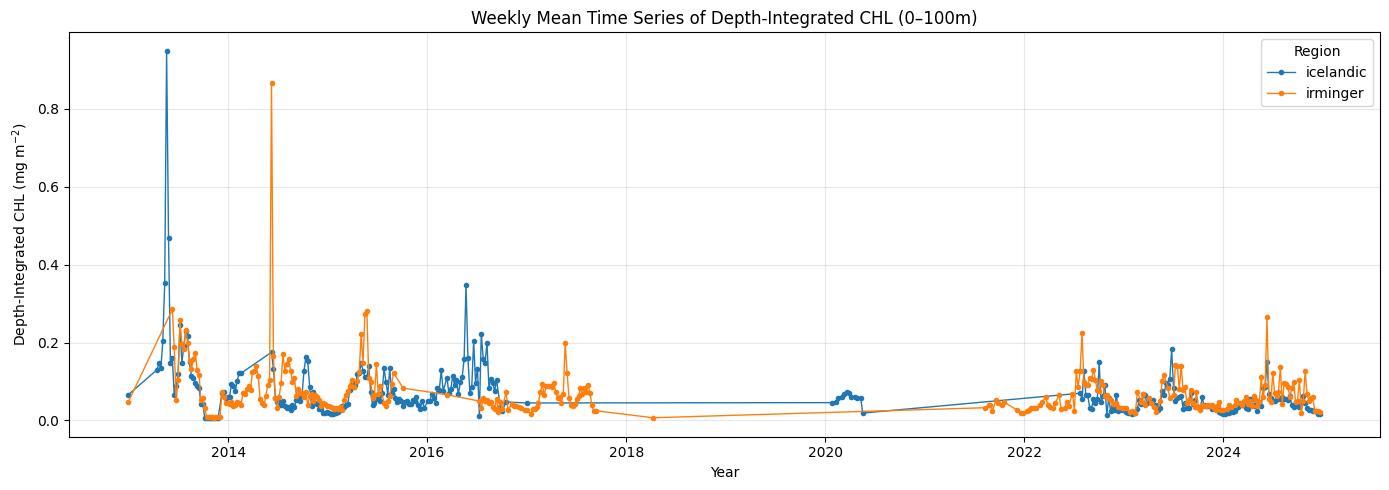

In [268]:

plt.figure(figsize=(14, 5))

for region_name, group in weekly_ts.groupby("region"):
    group = group.sort_values("date")

    plt.plot(
        group["date"],
        group["DEPTH_INT_CHL_mean"],
        linewidth=1,
        marker="o",
        markersize=3,
        label=region_name
    )

plt.title("Weekly Mean Time Series of Depth-Integrated CHL (0–100m)")
plt.xlabel("Year")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

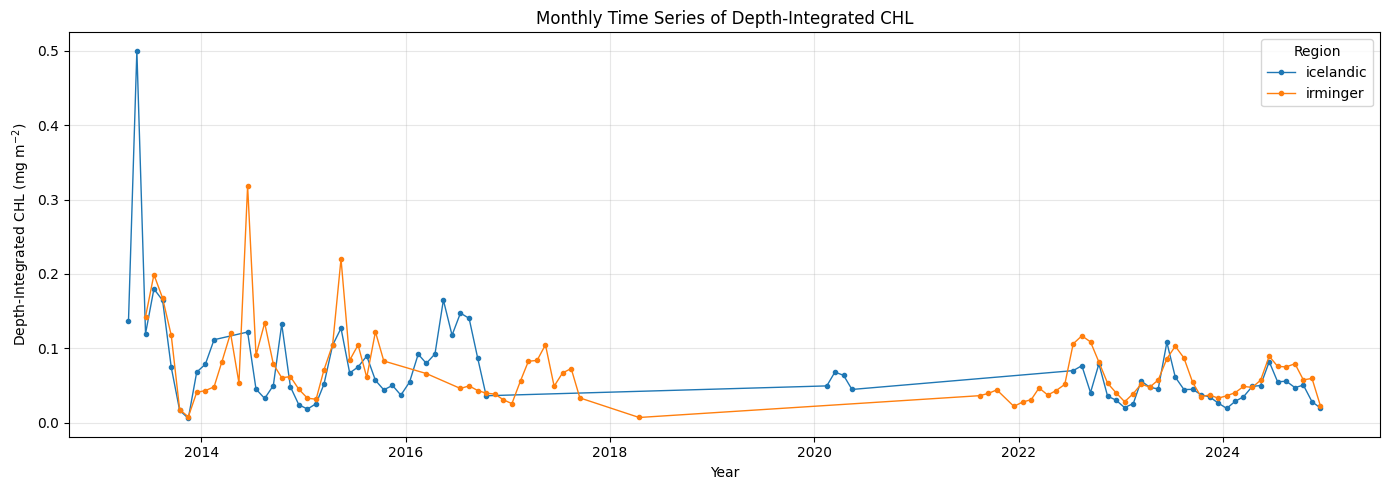

In [269]:
# Extract year and month
profiles_pd["year"] = profiles_pd["TIME"].dt.year
profiles_pd["month"] = profiles_pd["TIME"].dt.month   # calendar month

# Group: region × year × month
monthly_ts = (
    profiles_pd
    .groupby(["region", "year", "month"])
    .agg(
        DEPTH_INT_CHL_mean=("DEPTH_INT_CHL", "mean"),
        DEPTH_INT_CHL_std=("DEPTH_INT_CHL", "std"),
        n_profiles=("DEPTH_INT_CHL", "size"),
    )
    .reset_index()
)

# Build a datetime for the middle of each month
monthly_ts["date"] = pd.to_datetime(
    monthly_ts["year"].astype(str) + "-" +
    monthly_ts["month"].astype(str) + "-15"
)

# Plot
plt.figure(figsize=(14, 5))

for region_name, group in monthly_ts.groupby("region"):
    group = group.sort_values("date")

    plt.plot(
        group["date"],
        group["DEPTH_INT_CHL_mean"],
        linewidth=1,
        marker="o",
        markersize=3,
        label=region_name
    )

    # shading
    #plt.fill_between(
    #    group["date"],
    #    group["DEPTH_INT_CHL_mean"] - group["DEPTH_INT_CHL_std"],
    #    group["DEPTH_INT_CHL_mean"] + group["DEPTH_INT_CHL_std"],
    #    alpha=0.2
    #)

plt.title("Monthly Time Series of Depth-Integrated CHL")
plt.xlabel("Year")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

### CHL Climatology

In [270]:
 #Fully integrated

month_clim_F = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim_F = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("DEPTH_INT_CHL").mean().alias("DEPTH_INT_CHL_clim"),
        pl.col("DEPTH_INT_CHL").std().alias("DEPTH_INT_CHL_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)

# Convert to pandas for easy plotting
climm_pd = month_clim_F.to_pandas()
climw_pd = week_clim_F.to_pandas()


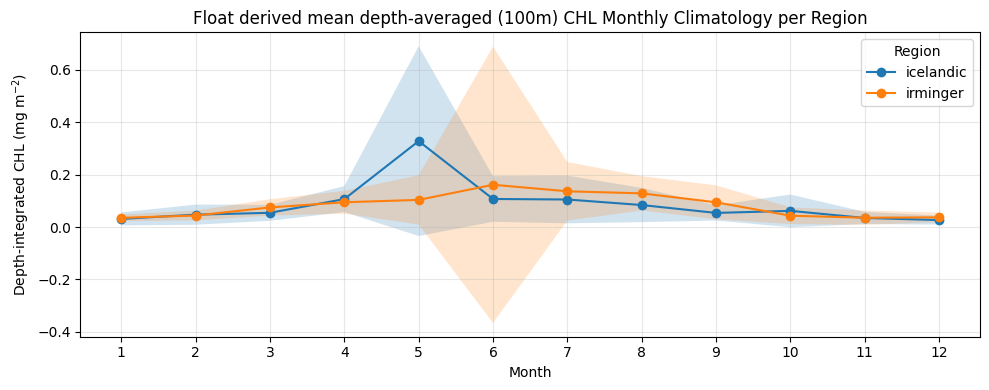

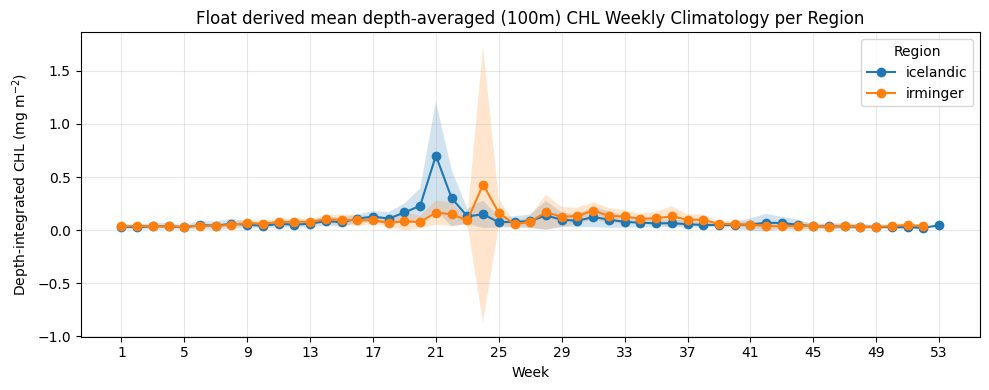

In [271]:
#Plotting fully integrated chlorophyll
plt.figure(figsize=(10, 4))

for region_name, group in climm_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    #Optional: add ±1 std shading
    plt.fill_between(
        group["month"],
        group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
        group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
        alpha=0.2,
    )

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Float derived mean depth-averaged (100m) " \
          "CHL Monthly Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["DEPTH_INT_CHL_clim"],
        marker="o",
        label=region_name,
    )

    #Optional: add ±1 std shading
    plt.fill_between(
        group["week"],
        group["DEPTH_INT_CHL_clim"] - group["DEPTH_INT_CHL_std"],
        group["DEPTH_INT_CHL_clim"] + group["DEPTH_INT_CHL_std"],
        alpha=0.2,
    )
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")   
#limiting y range from 0 to 300 mg m^-2
#plt.ylim(0, 250)
plt.title("Float derived mean depth-averaged (100m) " \
          "CHL Weekly Climatology per Region")
# ax.set_xticks(np.arange(1, 53, 4)) addding every 4 weeks
plt.xticks(ticks=np.arange(1, 54, 4))
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

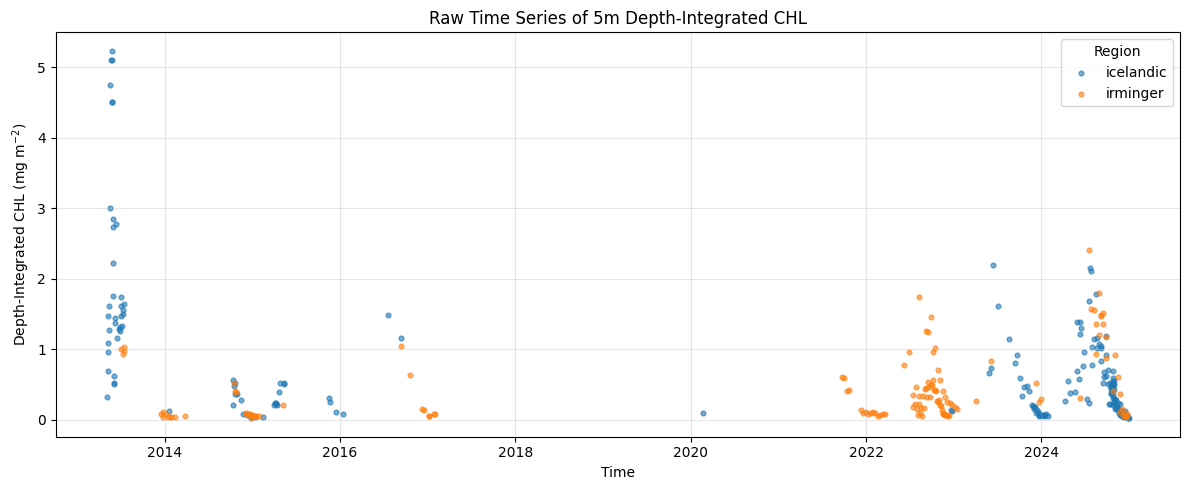

In [272]:
 #5m integrated

# Plotting a CHL time series per region
profiles_pd = profiles.to_pandas()
profiles_pd["TIME"] = pd.to_datetime(profiles_pd["TIME"])

plt.figure(figsize=(12, 5))

for region_name, group in profiles_pd.groupby("region"):
    plt.scatter(
        group["TIME"],
        group["DEPTH_INT_CHL_5m"],
        s=12,
        alpha=0.6,
        label=region_name
    )

plt.title("Raw Time Series of 5m Depth-Integrated CHL")
plt.xlabel("Time")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

monthly_clim_5m = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("DEPTH_INT_CHL_5m").mean().alias("DEPTH_INT_CHL_5m_clim"),
        pl.col("DEPTH_INT_CHL_5m").std().alias("DEPTH_INT_CHL_5m_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim_5m = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("DEPTH_INT_CHL_5m").mean().alias("DEPTH_INT_CHL_5m_clim"),
        pl.col("DEPTH_INT_CHL_5m").std().alias("DEPTH_INT_CHL_5m_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)


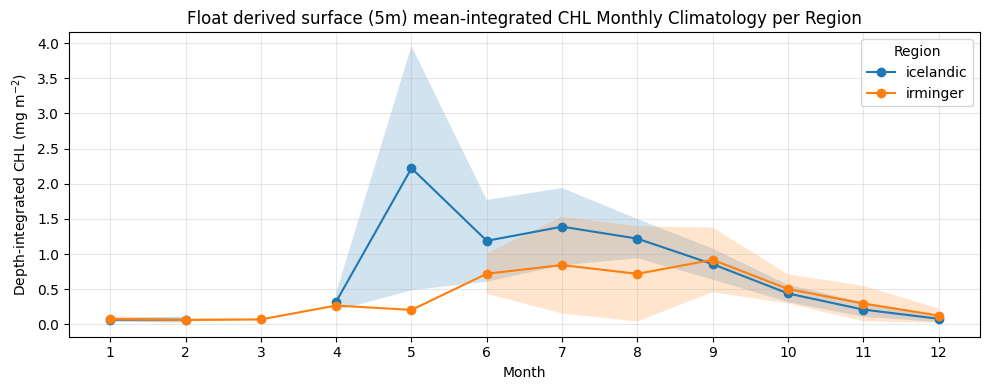

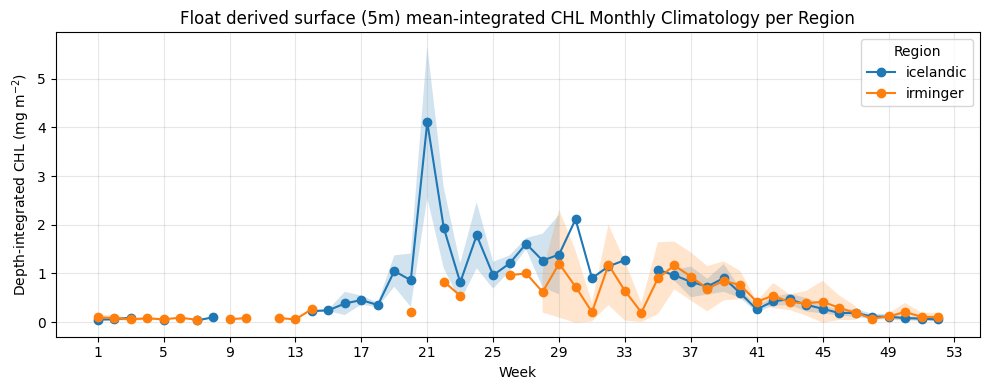

In [273]:
#Plotting clim at 5m 

# Convert to pandas for easy plotting
clim_pd = monthly_clim_5m.to_pandas()
climw_pd = week_clim_5m.to_pandas()

plt.figure(figsize=(10, 4))

for region_name, group in clim_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["DEPTH_INT_CHL_5m_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    plt.fill_between(
        group["month"],
        group["DEPTH_INT_CHL_5m_clim"] - group["DEPTH_INT_CHL_5m_std"],
        group["DEPTH_INT_CHL_5m_clim"] + group["DEPTH_INT_CHL_5m_std"],
        alpha=0.2,
    )

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Float derived surface (5m) mean-integrated " \
          "CHL Monthly Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["DEPTH_INT_CHL_5m_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    plt.fill_between(
        group["week"],
        group["DEPTH_INT_CHL_5m_clim"] - group["DEPTH_INT_CHL_5m_std"],
        group["DEPTH_INT_CHL_5m_clim"] + group["DEPTH_INT_CHL_5m_std"],
        alpha=0.2,
    )
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")   
#limiting y range from 0 to 300 mg m^-2
#plt.ylim(0, 250)
plt.title("Float derived surface (5m) mean-integrated " \
          "CHL Monthly Climatology per Region")
# ax.set_xticks(np.arange(1, 53, 4)) addding every 4 weeks
plt.xticks(ticks=np.arange(1, 54, 4))
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

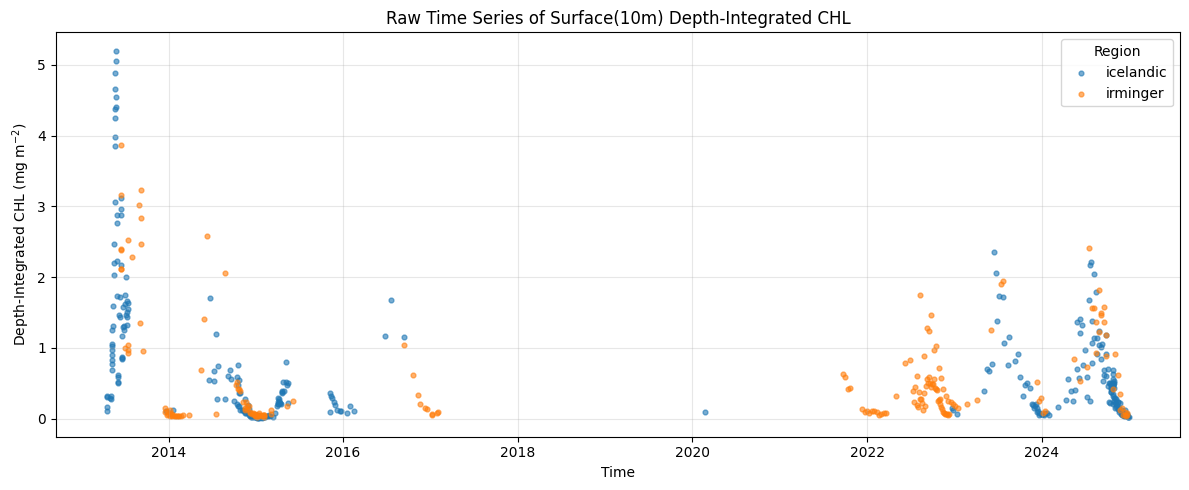

In [274]:
 #Sruface integrated

# Plotting a CHL time series per region
profiles_pd = profiles.to_pandas()
profiles_pd["TIME"] = pd.to_datetime(profiles_pd["TIME"])

plt.figure(figsize=(12, 5))

for region_name, group in profiles_pd.groupby("region"):
    plt.scatter(
        group["TIME"],
        group["DEPTH_INT_CHL_sur"],
        s=12,
        alpha=0.6,
        label=region_name
    )

plt.title("Raw Time Series of Surface(10m) Depth-Integrated CHL")
plt.xlabel("Time")
plt.ylabel("Depth-Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()


monthly_clim_sur = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("DEPTH_INT_CHL_sur").mean().alias("DEPTH_INT_CHL_sur_clim"),
        pl.col("DEPTH_INT_CHL_sur").std().alias("DEPTH_INT_CHL_sur_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim_sur = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("DEPTH_INT_CHL_sur").mean().alias("DEPTH_INT_CHL_sur_clim"),
        pl.col("DEPTH_INT_CHL_sur").std().alias("DEPTH_INT_CHL_sur_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)


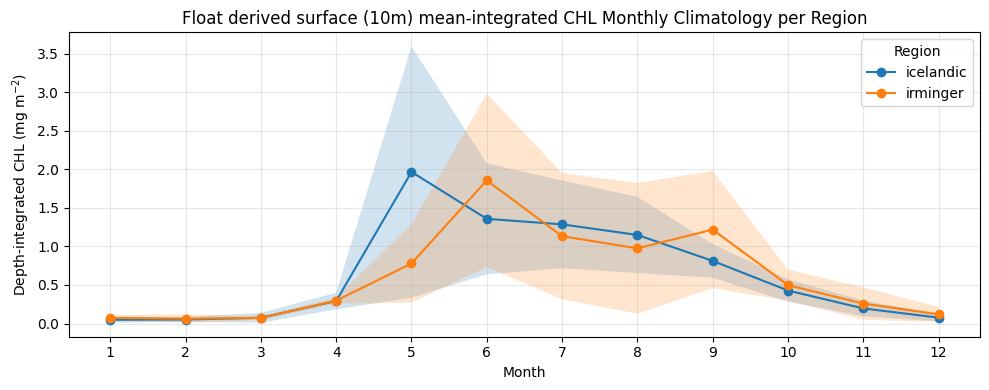

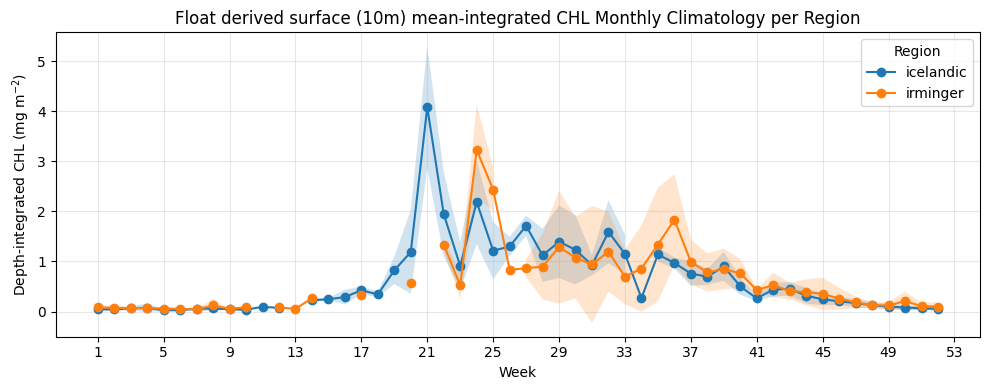

In [275]:
# Plotting surface climatology

# Convert to pandas for easy plotting
clim_pd = monthly_clim_sur.to_pandas()
climw_pd = week_clim_sur.to_pandas()

plt.figure(figsize=(10, 4))

for region_name, group in clim_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["DEPTH_INT_CHL_sur_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    plt.fill_between(
        group["month"],
        group["DEPTH_INT_CHL_sur_clim"] - group["DEPTH_INT_CHL_sur_std"],
        group["DEPTH_INT_CHL_sur_clim"] + group["DEPTH_INT_CHL_sur_std"],
        alpha=0.2,
    )

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Float derived surface (10m) mean-integrated " \
          "CHL Monthly Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["DEPTH_INT_CHL_sur_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    plt.fill_between(
        group["week"],
        group["DEPTH_INT_CHL_sur_clim"] - group["DEPTH_INT_CHL_sur_std"],
        group["DEPTH_INT_CHL_sur_clim"] + group["DEPTH_INT_CHL_sur_std"],
        alpha=0.2,
    )
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")   
#limiting y range from 0 to 300 mg m^-2
#plt.ylim(0, 250)
plt.title("Float derived surface (10m) mean-integrated " \
          "CHL Monthly Climatology per Region")
# ax.set_xticks(np.arange(1, 53, 4)) addding every 4 weeks
plt.xticks(ticks=np.arange(1, 54, 4))
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

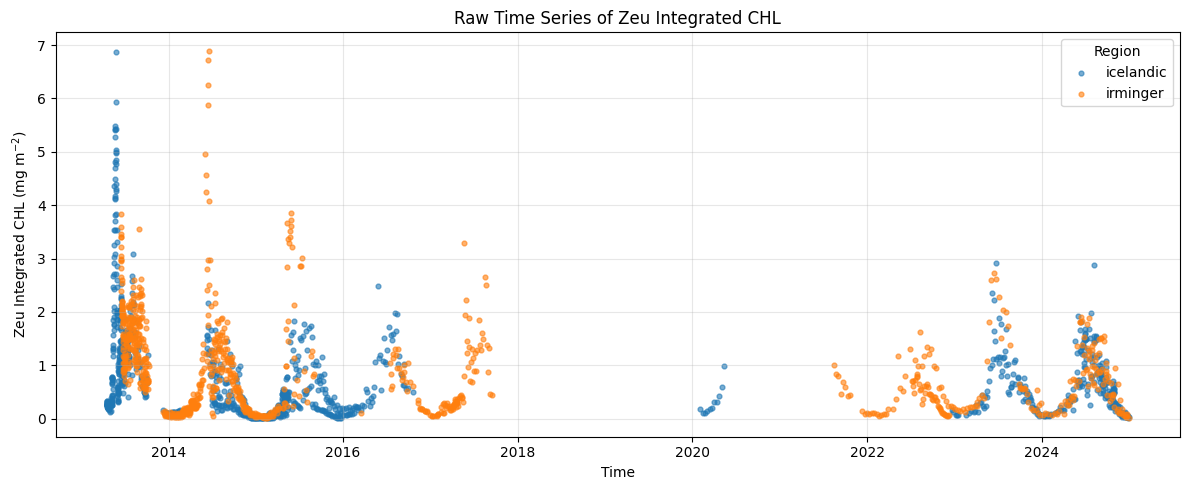

In [276]:
 #Zeu integrated

# Plotting a CHL time series per region
profiles_pd = profiles.to_pandas()
profiles_pd["TIME"] = pd.to_datetime(profiles_pd["TIME"])

plt.figure(figsize=(12, 5))

for region_name, group in profiles_pd.groupby("region"):
    plt.scatter(
        group["TIME"],
        group["INT_CHL_ZEU"],
        s=12,
        alpha=0.6,
        label=region_name
    )

plt.title("Raw Time Series of Zeu Integrated CHL")
plt.xlabel("Time")
plt.ylabel("Zeu Integrated CHL (mg m$^{-2}$)")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()


monthly_clim_zeu = (
    profiles
    .group_by(["region", "month"])
    .agg([
        pl.col("INT_CHL_ZEU").mean().alias("INT_CHL_ZEU_clim"),
        pl.col("INT_CHL_ZEU").std().alias("INT_CHL_ZEU_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "month"])
)

week_clim_zeu = (
    profiles
    .group_by(["region", "week"])
    .agg([
        pl.col("INT_CHL_ZEU").mean().alias("INT_CHL_ZEU_clim"),
        pl.col("INT_CHL_ZEU").std().alias("INT_CHL_ZEU_std"),
        pl.len().alias("n_profiles"),   # number of profiles contributing
    ])
    .sort(["region", "week"])
)

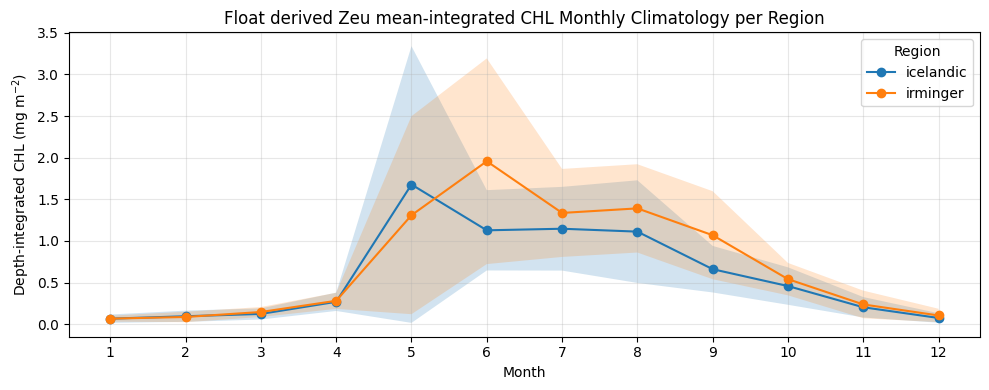

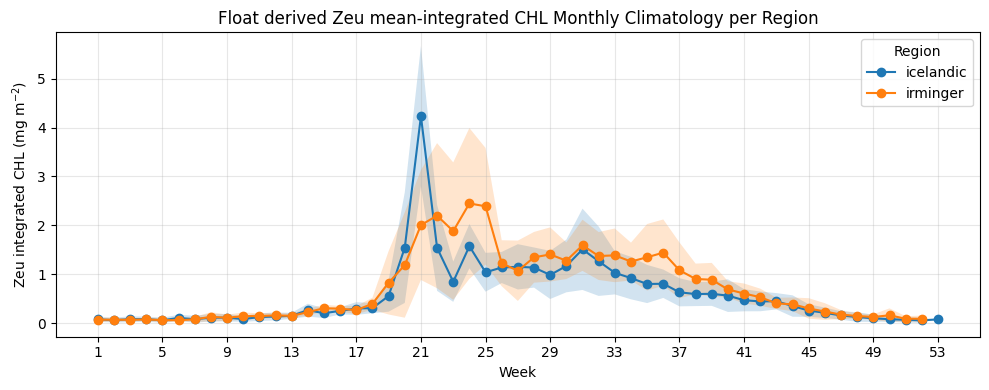

In [277]:
# Plotting Zeu climatology

# Convert to pandas for easy plotting
clim_pd = monthly_clim_zeu.to_pandas()
climw_pd = week_clim_zeu.to_pandas()

plt.figure(figsize=(10, 4))

for region_name, group in clim_pd.groupby("region"):
    group = group.sort_values("month")
    
    plt.plot(
        group["month"],
        group["INT_CHL_ZEU_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    plt.fill_between(
        group["month"],
        group["INT_CHL_ZEU_clim"] - group["INT_CHL_ZEU_std"],
        group["INT_CHL_ZEU_clim"] + group["INT_CHL_ZEU_std"],
        alpha=0.2,
    )

plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Depth-integrated CHL (mg m$^{-2}$)")
plt.title("Float derived Zeu mean-integrated " \
          "CHL Monthly Climatology per Region")
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for region_name, group in climw_pd.groupby("region"):
    group = group.sort_values("week")
    
    plt.plot(
        group["week"],
        group["INT_CHL_ZEU_clim"],
        marker="o",
        label=region_name,
    )

    # Optional: add ±1 std shading
    plt.fill_between(
        group["week"],
        group["INT_CHL_ZEU_clim"] - group["INT_CHL_ZEU_std"],
        group["INT_CHL_ZEU_clim"] + group["INT_CHL_ZEU_std"],
        alpha=0.2,
    )
plt.xticks(range(1, 54))
plt.xlabel("Week")
plt.ylabel("Zeu integrated CHL (mg m$^{-2}$)")   
#limiting y range from 0 to 300 mg m^-2
#plt.ylim(0, 250)
plt.title("Float derived Zeu mean-integrated " \
          "CHL Monthly Climatology per Region")
# ax.set_xticks(np.arange(1, 53, 4)) addding every 4 weeks
plt.xticks(ticks=np.arange(1, 54, 4))
plt.grid(alpha=0.3)
plt.legend(title="Region")
plt.tight_layout()
plt.show()

### Depth specefic timeseries



In [278]:

BIN = 20
ZMAX = 100

# (re)create per-profile-per-bin table (if you already have profiles_z, just ensure BIN=20)
df_binned = (
    df.filter((pl.col("PRES_ADJUSTED") >= 0) & (pl.col("PRES_ADJUSTED") <= ZMAX))
      .with_columns((pl.col("PRES_ADJUSTED") // BIN * BIN).cast(pl.Int32).alias("zbin"))
      .filter(pl.col("zbin") < ZMAX)
)

profiles_z = (
    df_binned
    .group_by(["PLATFORM_NUMBER","CYCLE_NUMBER","region","zbin"], maintain_order=True)
    .agg([
        pl.col("CHLA_ADJUSTED").mean().alias("CHL_bin"),
        pl.col("TIME").first().alias("TIME"),
    ])
    .filter(pl.col("CHL_bin").is_not_null())
    .with_columns(pl.col("TIME").dt.month().alias("month"))
)

monthly_clim_z = (
    profiles_z
    .group_by(["region","zbin","month"])
    .agg([
        pl.col("CHL_bin").mean().alias("CHL_clim"),
        pl.col("CHL_bin").std().alias("CHL_std"),
        pl.len().alias("n_profiles"),
    ])
    .sort(["zbin","month","region"])
)

clim_pd = monthly_clim_z.to_pandas()

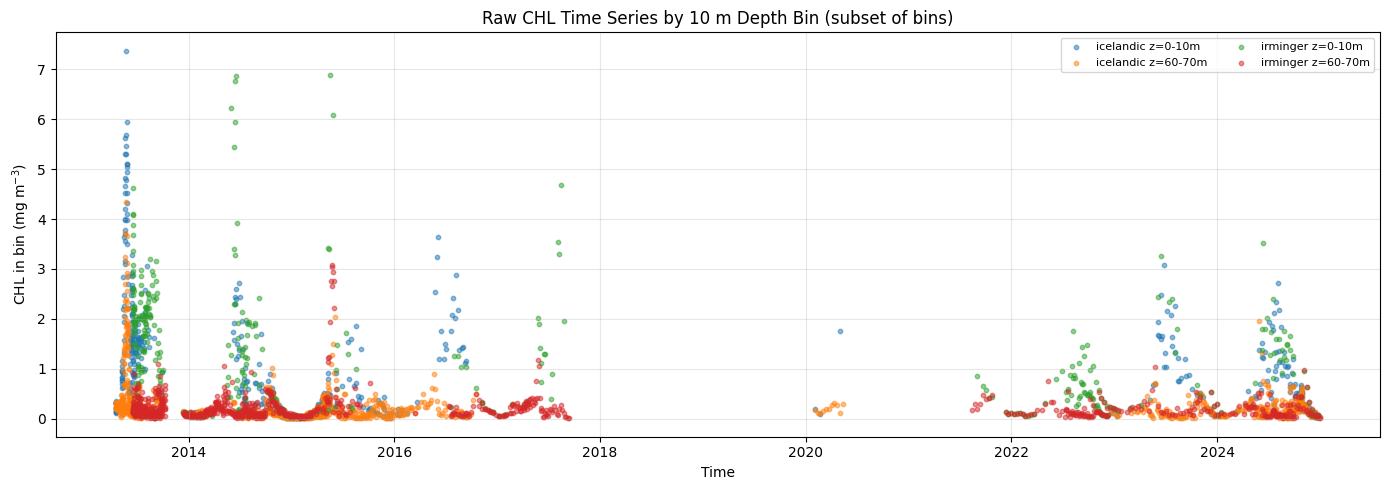

In [279]:
pz = profiles_z.to_pandas()
pz["TIME"] = pd.to_datetime(pz["TIME"])

bins_to_plot = [0, 60, 100]  # meters (bin start)

plt.figure(figsize=(14, 5))
for region_name, g in pz[pz["zbin"].isin(bins_to_plot)].groupby("region"):
    # color/marker by depth bin by looping
    for z, gg in g.groupby("zbin"):
        plt.scatter(gg["TIME"], gg["CHL_bin"], s=10, alpha=0.5, label=f"{region_name} z={z}-{z+10}m")

plt.title("Raw CHL Time Series by 10 m Depth Bin (subset of bins)")
plt.xlabel("Time")
plt.ylabel("CHL in bin (mg m$^{-3}$)")
plt.grid(alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

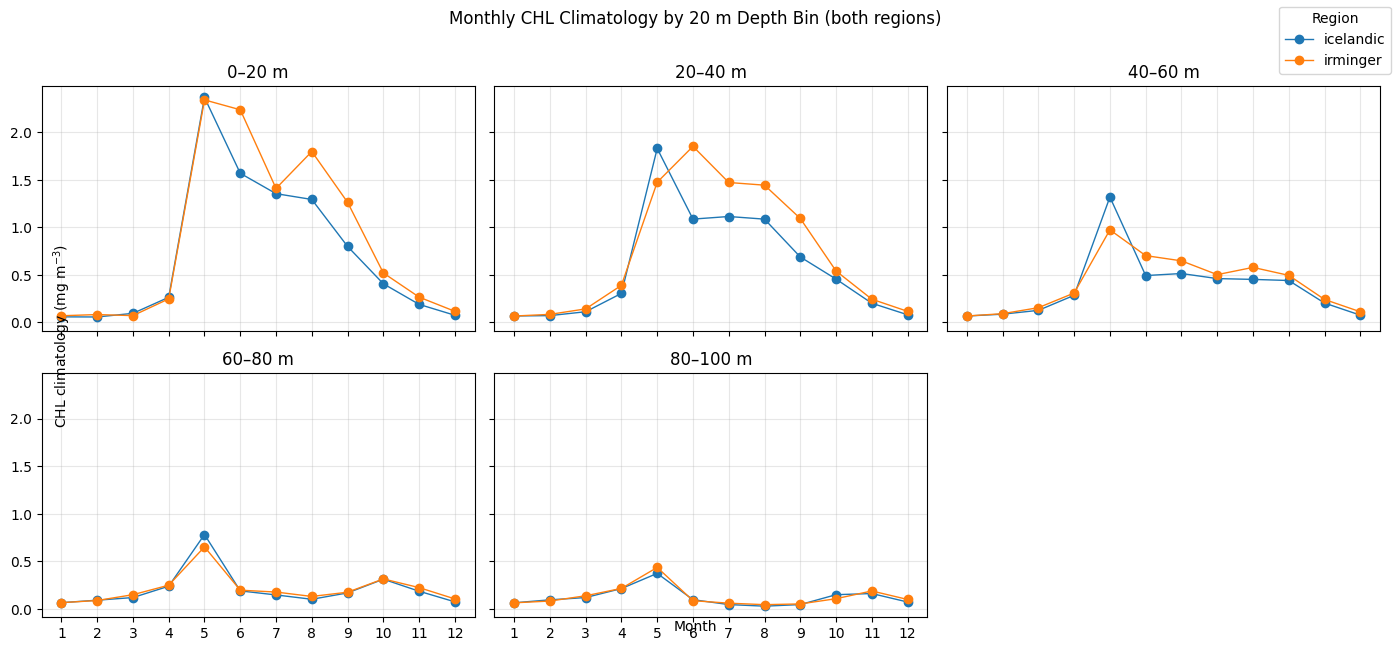

In [280]:
# Depth bins present (e.g., 0..280)
zbins = sorted(clim_pd["zbin"].unique())
regions = sorted(clim_pd["region"].unique())

n = len(zbins)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3.2*nrows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, z in enumerate(zbins):
    ax = axes[i]
    g = clim_pd[clim_pd["zbin"] == z].sort_values("month")

    for r in regions:
        gr = g[g["region"] == r].sort_values("month")
        if len(gr) == 0:
            continue
        ax.plot(gr["month"], gr["CHL_clim"], marker="o", linewidth=1, label=r)
        # Optional shading (±1 std)
        # ax.fill_between(gr["month"], gr["CHL_clim"]-gr["CHL_std"], gr["CHL_clim"]+gr["CHL_std"], alpha=0.15)

    ax.set_title(f"{z}–{z+BIN} m")
    ax.set_xticks(range(1, 13))
    ax.grid(alpha=0.3)

# Turn off any unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Region", loc="upper right")

fig.suptitle("Monthly CHL Climatology by 20 m Depth Bin (both regions)", y=1.01)
fig.text(0.5, 0.04, "Month", ha="center")
fig.text(0.04, 0.5, "CHL climatology (mg m$^{-3}$)", va="center", rotation="vertical")
plt.tight_layout()
plt.show()

### Cleaning and Ineterpolating timeseries

Cutting mid section and interpolating missing section

In [281]:
profiles.head()

shape: (5, 14)
┌─────────────┬─────────────┬─────────────┬────────────┬───┬───────┬──────┬────────────┬───────────┐
│ PLATFORM_NU ┆ CYCLE_NUMBE ┆ DEPTH_INT_C ┆ DEPTH_INT_ ┆ … ┆ month ┆ week ┆ INT_CHL_ZE ┆ ZEU       │
│ MBER        ┆ R           ┆ HL          ┆ CHL_5m     ┆   ┆ ---   ┆ ---  ┆ U          ┆ ---       │
│ ---         ┆ ---         ┆ ---         ┆ ---        ┆   ┆ i8    ┆ i8   ┆ ---        ┆ f64       │
│ i64         ┆ i64         ┆ f32         ┆ f32        ┆   ┆       ┆      ┆ f64        ┆           │
╞═════════════╪═════════════╪═════════════╪════════════╪═══╪═══════╪══════╪════════════╪═══════════╡
│ 4903659     ┆ 35          ┆ 0.027144    ┆ null       ┆ … ┆ 10    ┆ 42   ┆ 0.431203   ┆ 51.402276 │
│ 6901647     ┆ 356         ┆ 0.023941    ┆ null       ┆ … ┆ 9     ┆ 36   ┆ 0.458035   ┆ 42.764739 │
│ 6904240     ┆ 84          ┆ 0.226504    ┆ null       ┆ … ┆ 8     ┆ 33   ┆ 1.093315   ┆ 40.417845 │
│ 6900876     ┆ 20          ┆ 0.050104    ┆ null       ┆ … ┆ 10    ┆ 40   ┆ 0.265541   ┆ 47.405747 │
│ 6901519     ┆ 152         ┆ 0.051904    ┆ null       ┆ … ┆ 11    ┆ 47   ┆ 0.120135   ┆ 69.475749 │
└─────────────┴─────────────┴─────────────┴────────────┴───┴───────┴──────┴────────────┴───────────┘

In [282]:
# Gatherin time series and splitting into two

# Surface ts
ice_sur_ts = (
    profiles
    .select(["DEPTH_INT_CHL_sur", "TIME",
              "LATITUDE", "LONGITUDE", "region"])
    .filter(pl.col("region") == "icelandic"))

irm_sur_ts = (
    profiles
    .select(["DEPTH_INT_CHL_sur", "TIME",
              "LATITUDE", "LONGITUDE", "region"])
    .filter(pl.col("region") == "irminger"))

# ZEU
ice_zeu_ts = (
    profiles
    .select(["INT_CHL_ZEU", "TIME", 
             "LATITUDE", "LONGITUDE", "region"])
    .filter(pl.col("region") == "icelandic"))

irm_zeu_ts = (
    profiles
    .select(["INT_CHL_ZEU", "TIME", 
             "LATITUDE", "LONGITUDE", "region"])
    .filter(pl.col("region") == "irminger"))



In [283]:
# Converting raw ts into weekly bins

def to_weekly(df: pl.DataFrame, time_col: str, value_col: str, agg="mean") -> pl.DataFrame:
    agg_expr = getattr(pl.col(value_col), agg)().alias(value_col)
    return (
        df
        .with_columns(
            pl.col(time_col)
              .cast(pl.Datetime)  # safe if already datetime
              .dt.truncate("1w")
              .alias("week")
        )
        .group_by("week")
        .agg([
            agg_expr,
            pl.len().alias("n_prof"),
        ])
        .sort("week")
    )

# surface
ice_sur_ts = to_weekly(ice_sur_ts, "TIME", "DEPTH_INT_CHL_sur")
irm_sur_ts = to_weekly(irm_sur_ts, "TIME", "DEPTH_INT_CHL_sur")

#Zeu
irm_zeu_ts = to_weekly(irm_zeu_ts, "TIME", "INT_CHL_ZEU")
ice_zeu_ts = to_weekly(ice_zeu_ts, "TIME", "INT_CHL_ZEU")


In [284]:
# Plotting ts 

# surface
ice_sur_ts_pd = ice_sur_ts.to_pandas()
irm_sur_ts_pd = irm_sur_ts.to_pandas()

#ZEU
ice_zeu_ts_pd = ice_zeu_ts.to_pandas()
irm_zeu_ts_pd = irm_zeu_ts.to_pandas()


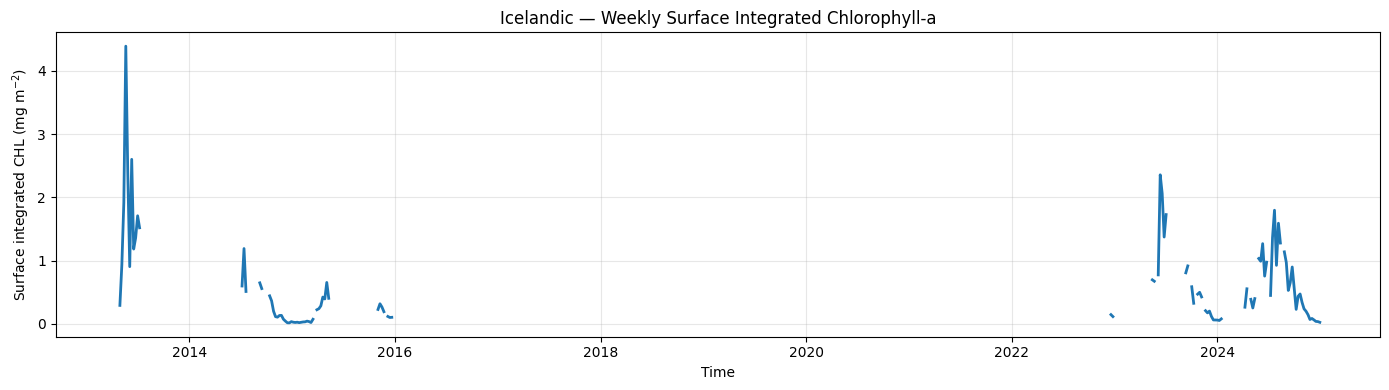

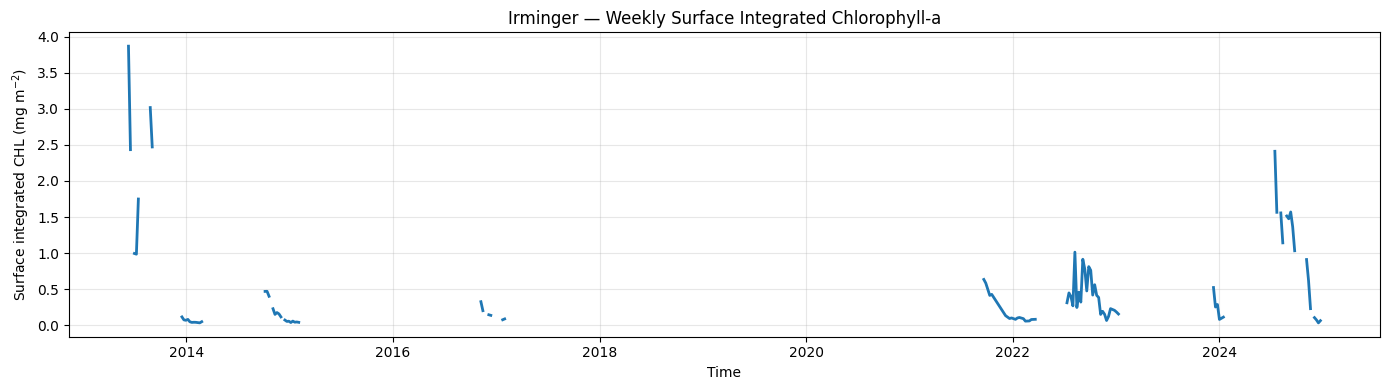

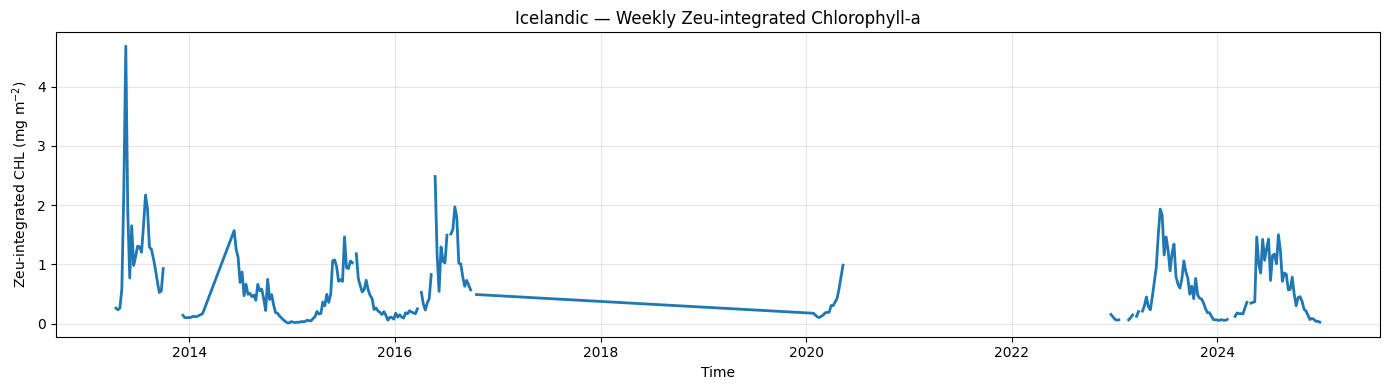

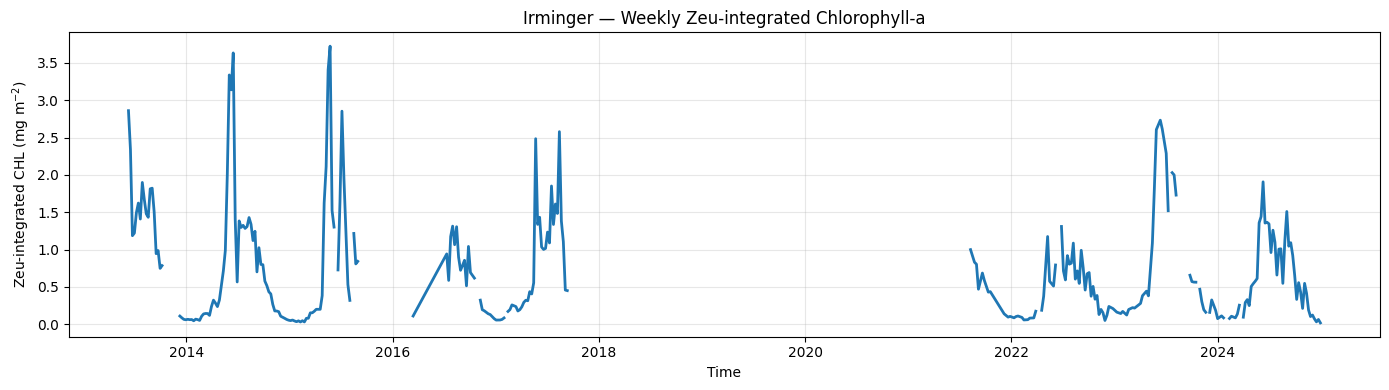

In [285]:

# Icelandic Surface
plt.figure(figsize=(14, 4))
plt.plot(ice_sur_ts_pd["week"], ice_sur_ts_pd["DEPTH_INT_CHL_sur"], lw=2)
plt.xlabel("Time")
plt.ylabel("Surface integrated CHL (mg m$^{-2}$)")
plt.title("Icelandic — Weekly Surface Integrated Chlorophyll-a")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Irminger Surface
plt.figure(figsize=(14, 4))
plt.plot(irm_sur_ts_pd["week"], irm_sur_ts_pd["DEPTH_INT_CHL_sur"], lw=2)
plt.xlabel("Time")
plt.ylabel("Surface integrated CHL (mg m$^{-2}$)")
plt.title("Irminger — Weekly Surface Integrated Chlorophyll-a")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Icelandic Zeu
plt.figure(figsize=(14, 4))
plt.plot(ice_zeu_ts_pd["week"], ice_zeu_ts_pd["INT_CHL_ZEU"], lw=2)
plt.xlabel("Time")
plt.ylabel("Zeu-integrated CHL (mg m$^{-2}$)")
plt.title("Icelandic — Weekly Zeu-integrated Chlorophyll-a")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Irminger Zeu
plt.figure(figsize=(14, 4))
plt.plot(irm_zeu_ts_pd["week"], irm_zeu_ts_pd["INT_CHL_ZEU"], lw=2)
plt.xlabel("Time")
plt.ylabel("Zeu-integrated CHL (mg m$^{-2}$)")
plt.title("Irminger — Weekly Zeu-integrated Chlorophyll-a")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Inspecting individual ts

In [286]:
# Summarising code into functions 
def add_time_keys(df, time_col="week"):
    """
    Ensure datetime + add year and weekofyear columns.
    """
    out = df.copy()
    out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
    out["year"] = out[time_col].dt.year
    out["weekofyear"] = out[time_col].dt.isocalendar().week.astype(int)
    return out


def reindex_to_full_year_weeks(df, time_col="week", freq="W-MON"):
    """
    For each year, reindex to a full weekly grid so gaps are explicit (NaNs).
    freq="W-MON" is best if your weeks are Mondays.
    """
    df = add_time_keys(df, time_col=time_col)

    def _reindex_year(g):
        year = int(g["year"].iloc[0])
        full_weeks = pd.date_range(f"{year}-01-01", f"{year}-12-31", freq=freq)

        out = (
            g.set_index(time_col)
             .sort_index()
             .reindex(full_weeks)
             .rename_axis(time_col)
             .reset_index()
        )
        out["year"] = year
        out["weekofyear"] = out[time_col].dt.isocalendar().week.astype(int)
        return out

    return df.groupby("year", group_keys=False).apply(_reindex_year)


In [287]:
ice_sur_full  = reindex_to_full_year_weeks(ice_sur_ts_pd,  time_col="week", freq="W-MON")
irm_sur_full  = reindex_to_full_year_weeks(irm_sur_ts_pd,  time_col="week", freq="W-MON")

ice_zeu_full = reindex_to_full_year_weeks(ice_zeu_ts_pd, time_col="week", freq="W-MON")
irm_zeu_full = reindex_to_full_year_weeks(irm_zeu_ts_pd, time_col="week", freq="W-MON")

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_10001/1051096531.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("year", group_keys=False).apply(_reindex_year)
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_10001/1051096531.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("year", group_keys=False).apply(_reindex_year)
/var/folders/41/myncq97s4xl5mbkb

In [288]:
def plot_years(
    df,
    value_col,
    title_prefix,
    ylabel,
    time_col="week",
    freq="W-MON"
):
    d = df.copy()
    d[time_col] = pd.to_datetime(d[time_col], errors="coerce")

    # derive year from existing timestamps
    d["year"] = d[time_col].dt.year

    has_interp_flag = "interpolated" in d.columns

    for year, g in d.groupby("year"):
        g = g.sort_values(time_col)

        # Build complete weekly grid for the whole year
        full_weeks = pd.date_range(f"{year}-01-01", f"{year}-12-31", freq=freq)

        # Reindex to full grid
        gg = (
            g.set_index(time_col)
             .reindex(full_weeks)
             .rename_axis(time_col)
             .reset_index()
        )

        n = gg[value_col].notna().sum()
        missing = gg[value_col].isna().sum()

        if n == 0:
            print(f"Skipping {title_prefix} {year}: no data")
            continue

        plt.figure(figsize=(10, 3))

        # Plot main time series
        plt.plot(
            gg[time_col],
            gg[value_col],
            marker="o",
            lw=1,
            label="observed"
        )

        # Overlay interpolated points if available
        if has_interp_flag:
            interp_mask = gg.get("interpolated", False) == True

            if interp_mask.any():
                plt.scatter(
                    gg.loc[interp_mask, time_col],
                    gg.loc[interp_mask, value_col],
                    color="red",
                    s=35,
                    zorder=3,
                    label="interpolated"
                )

        plt.title(f"{title_prefix} — {year} (n={n}, missing={missing})")
        plt.xlabel("Week")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

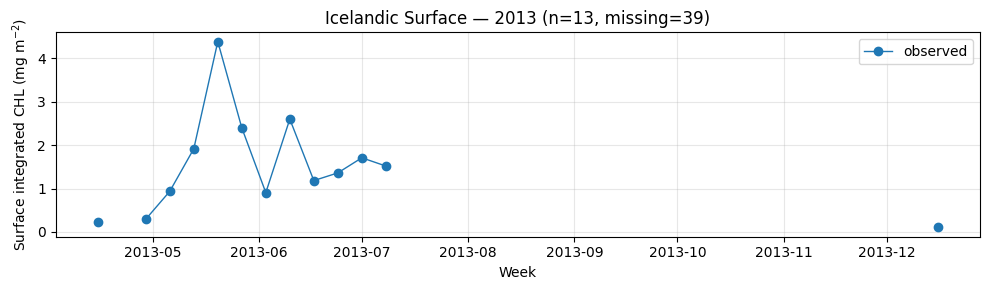

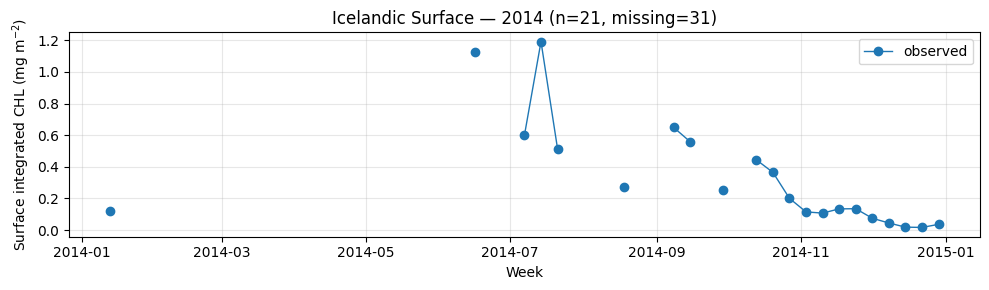

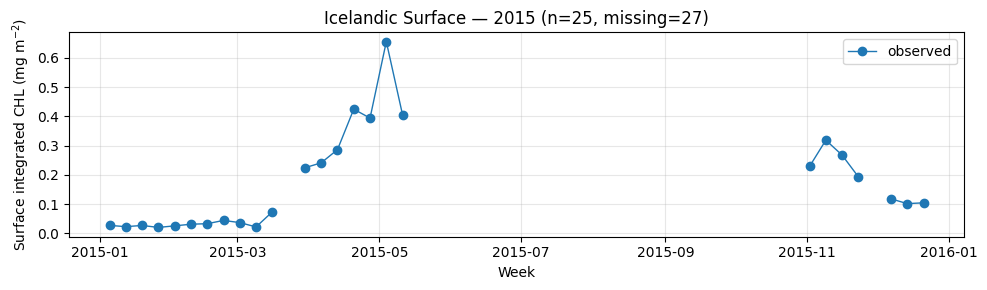

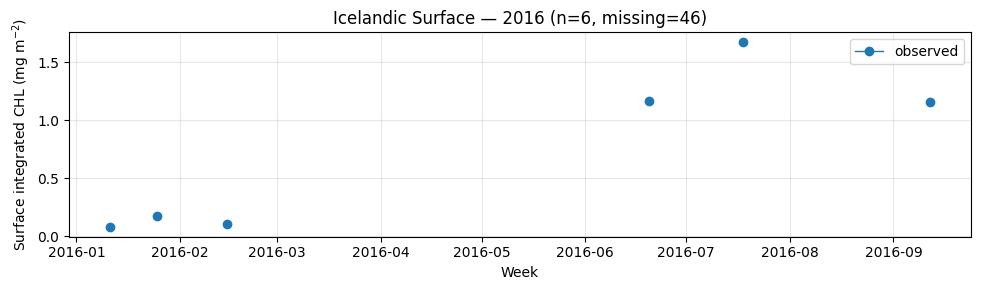

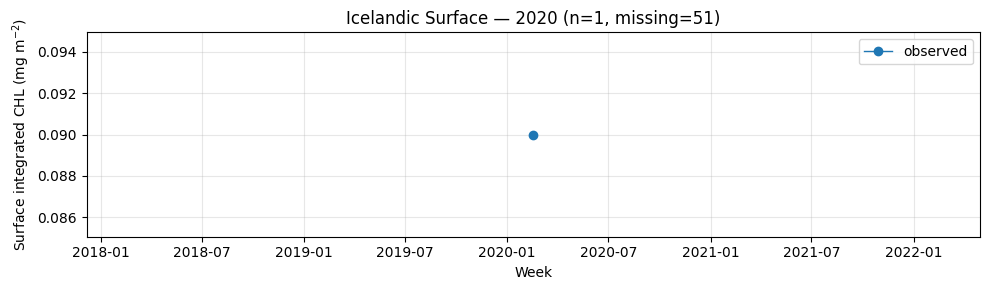

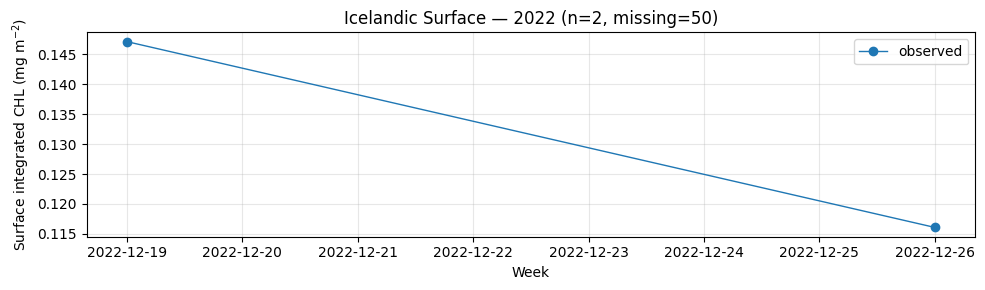

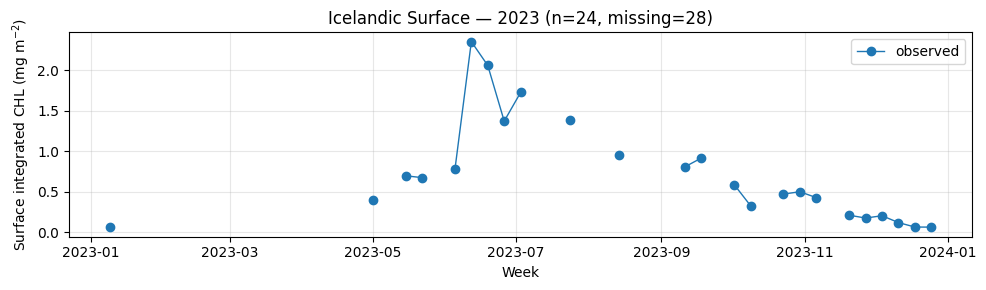

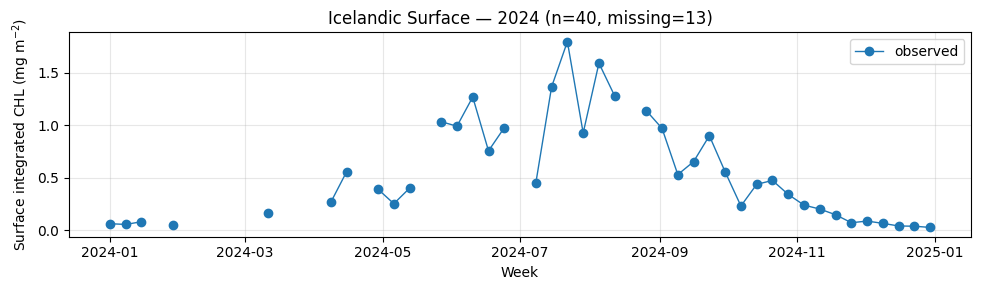

In [289]:
plot_years(
    ice_sur_ts_pd,
    value_col="DEPTH_INT_CHL_sur",
    title_prefix="Icelandic Surface",
    ylabel="Surface integrated CHL (mg m$^{-2}$)"
)

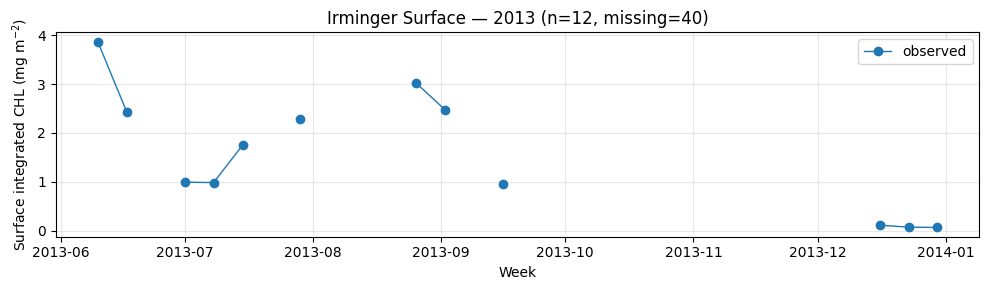

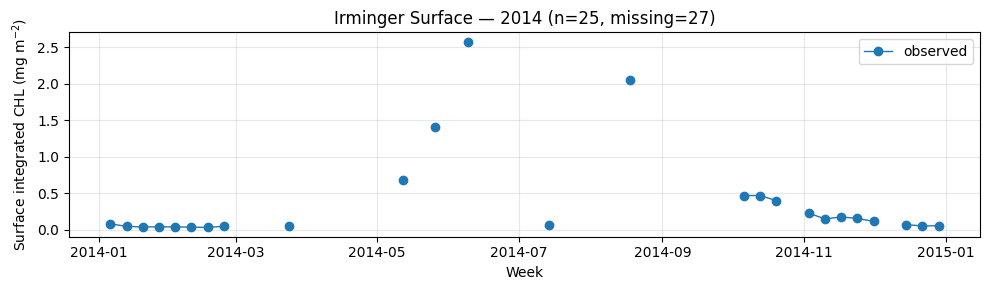

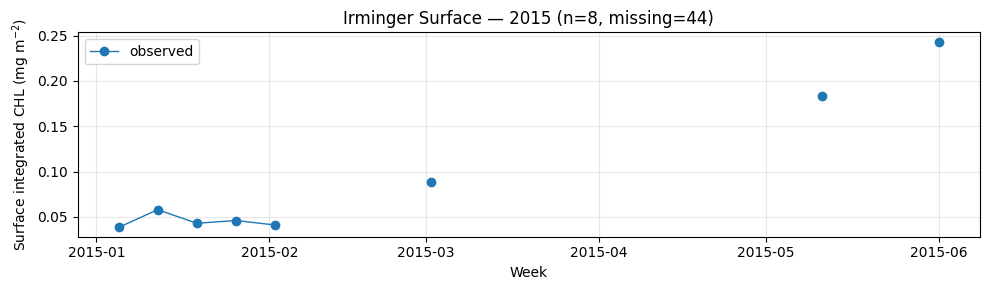

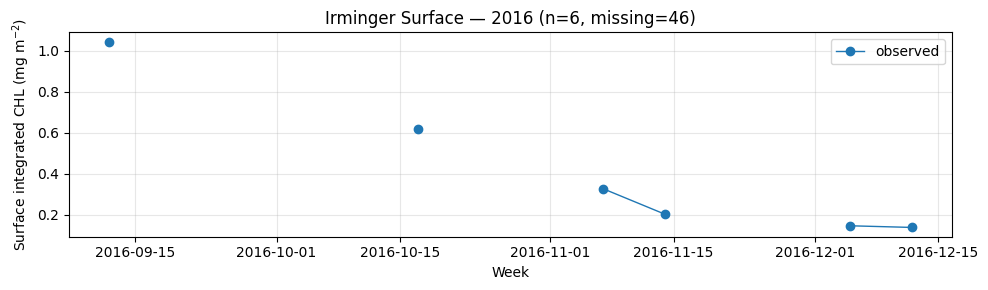

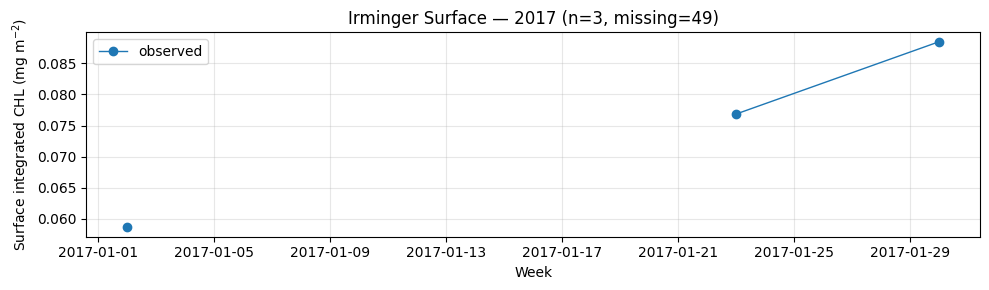

Skipping Irminger Surface 2018: no data


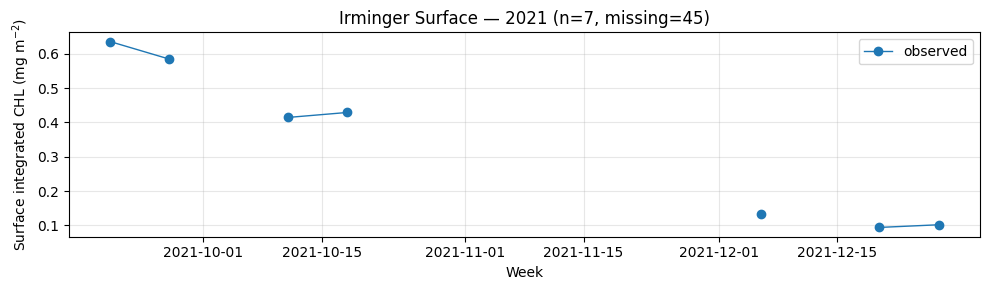

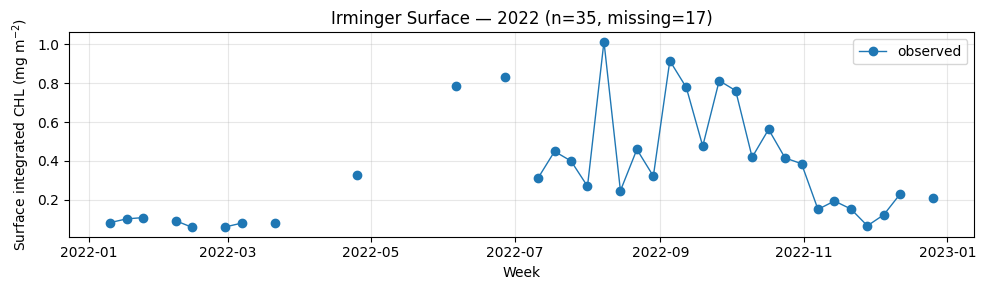

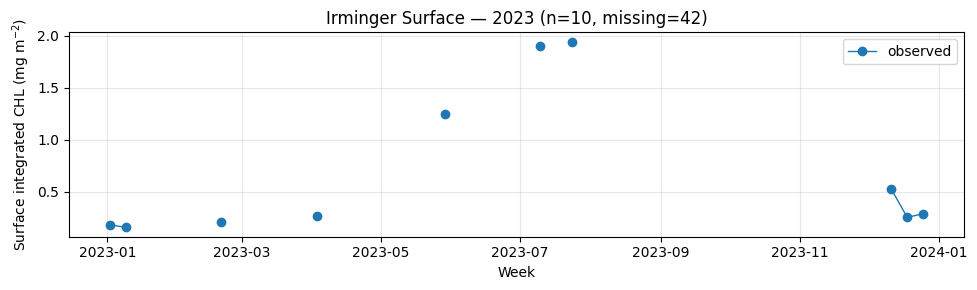

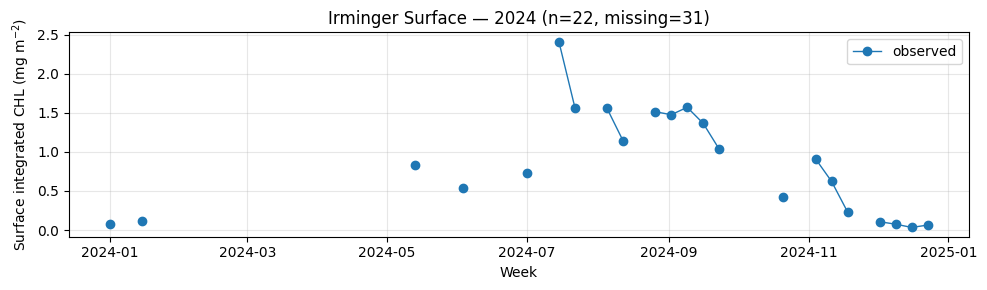

In [290]:
plot_years(
    irm_sur_ts_pd,
    value_col="DEPTH_INT_CHL_sur",
    title_prefix="Irminger Surface",
    ylabel="Surface integrated CHL (mg m$^{-2}$)"
)

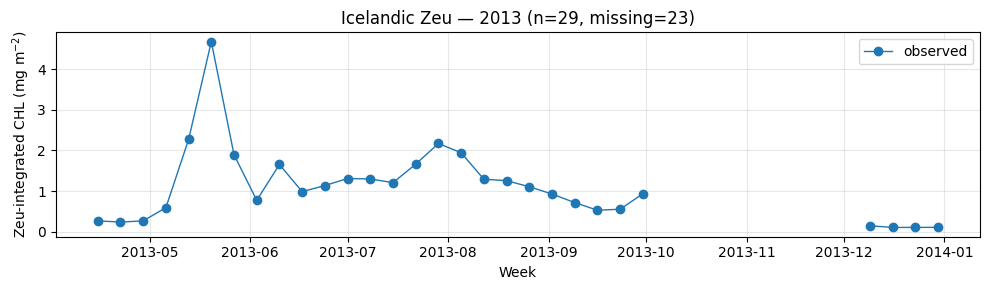

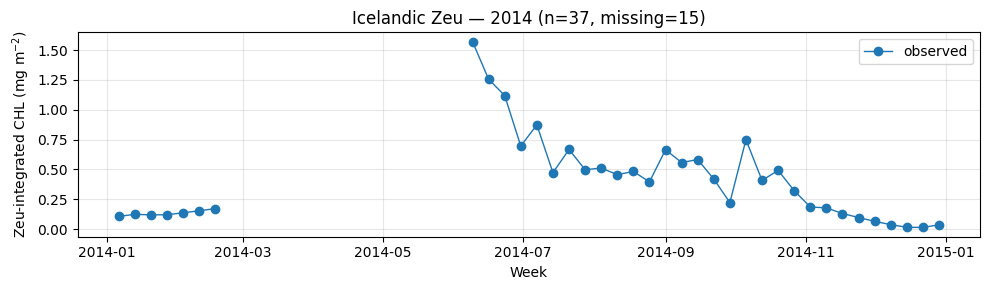

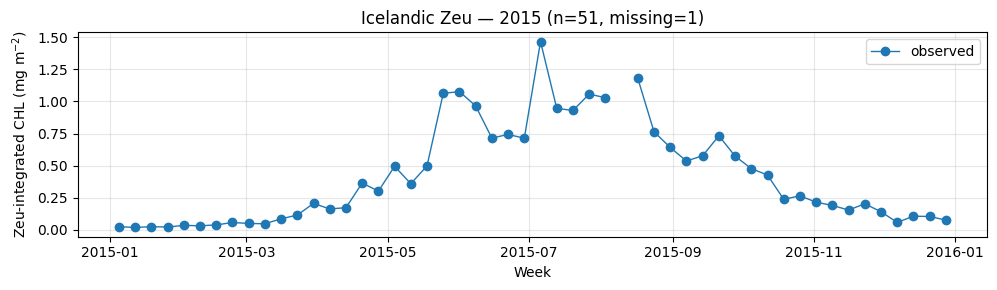

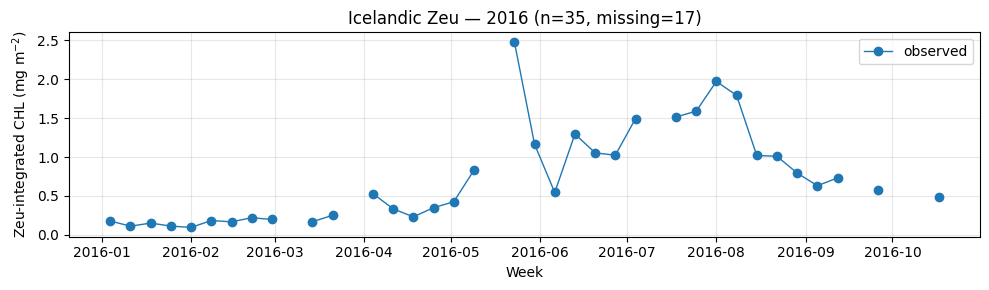

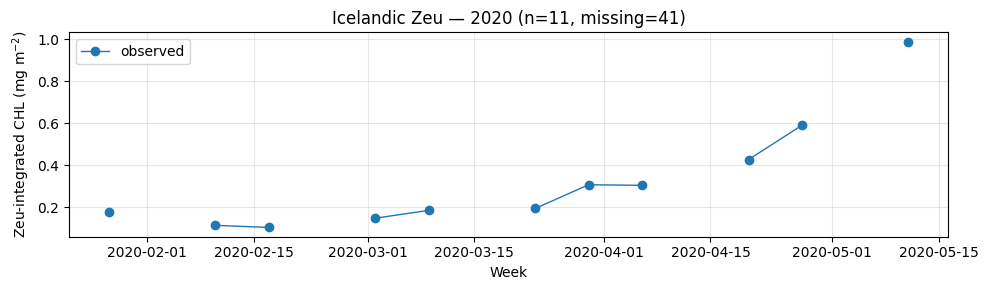

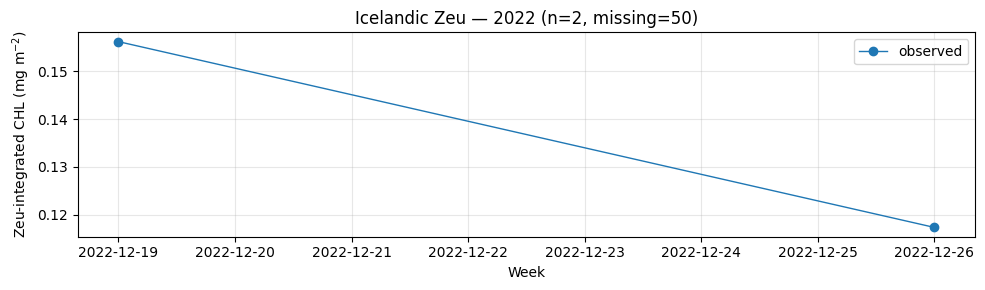

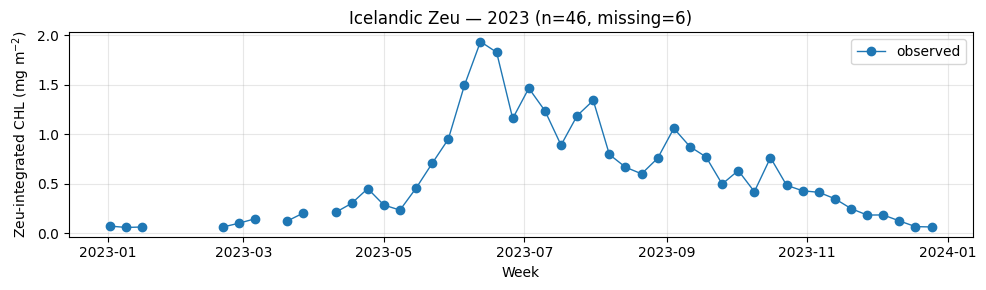

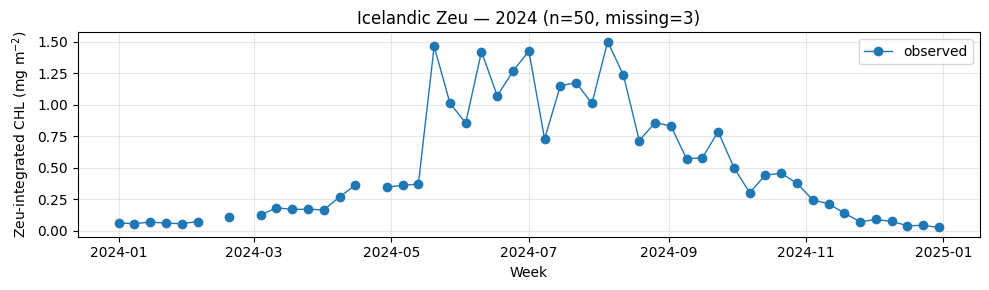

In [291]:
plot_years(
    ice_zeu_ts_pd,
    value_col="INT_CHL_ZEU",
    title_prefix="Icelandic Zeu",
    ylabel="Zeu-integrated CHL (mg m$^{-2}$)"
)

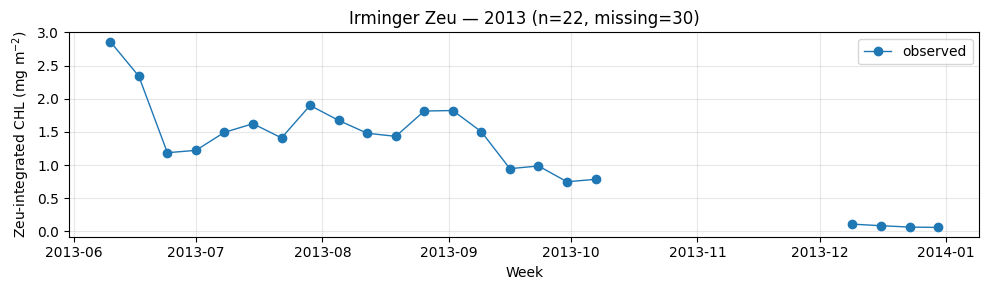

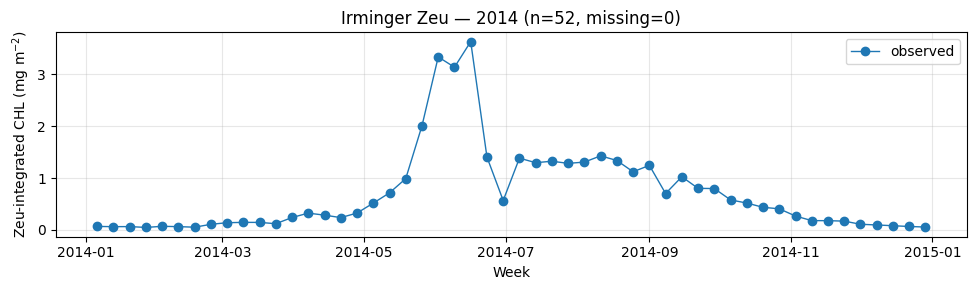

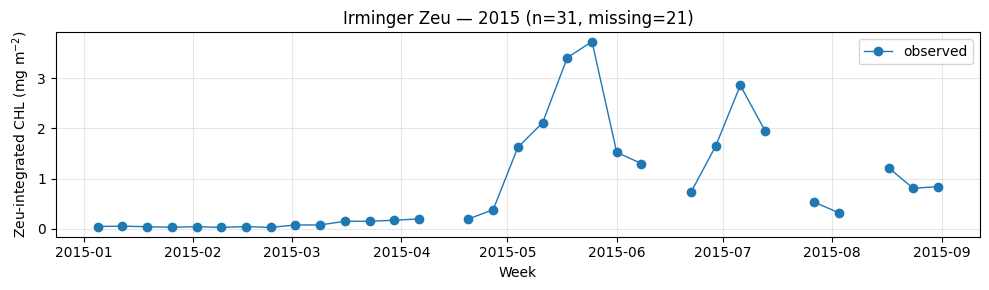

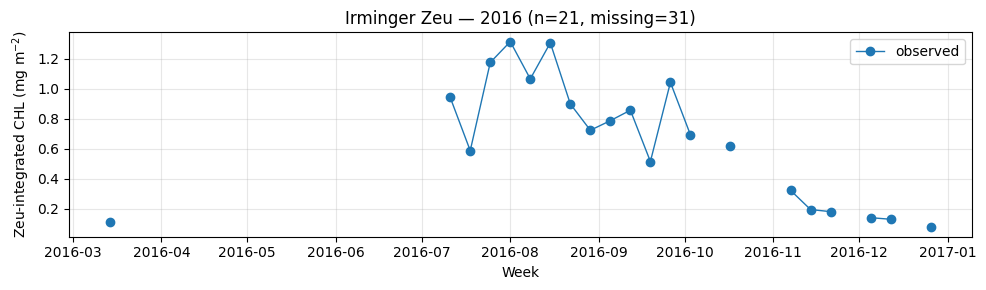

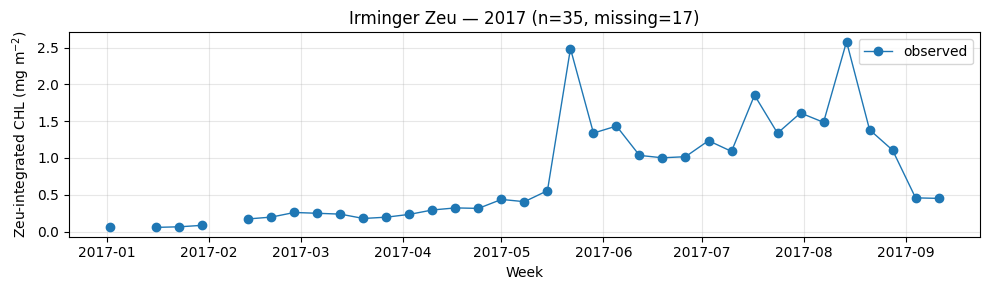

Skipping Irminger Zeu 2018: no data


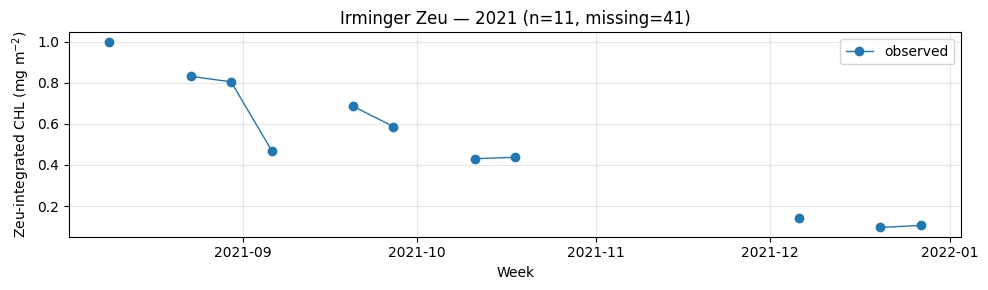

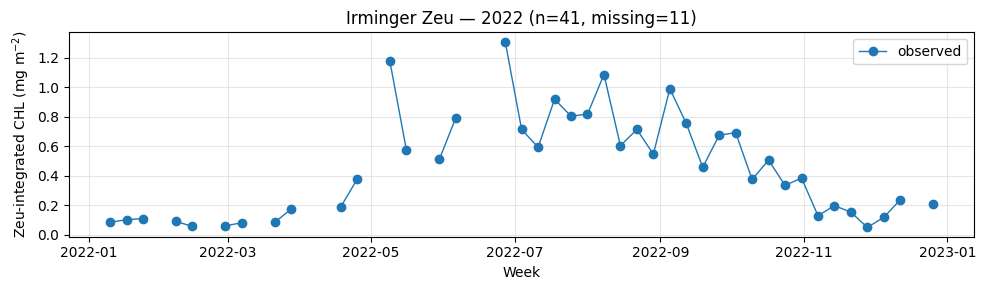

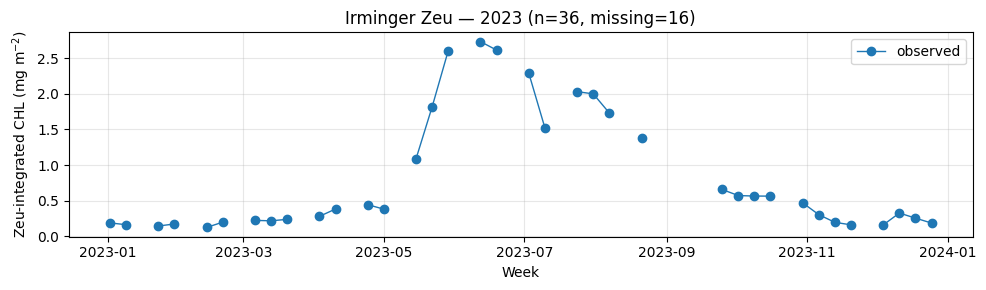

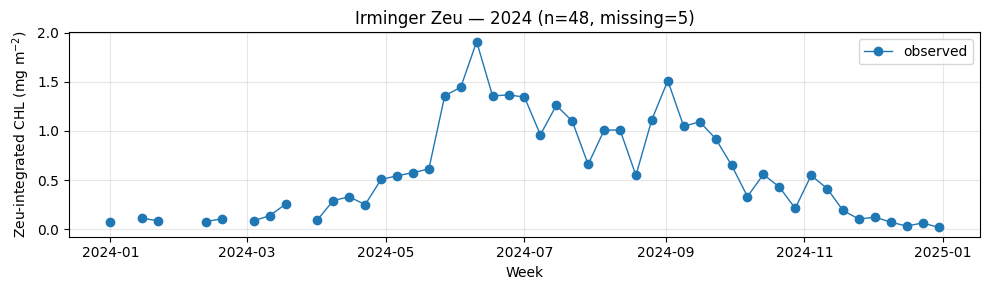

In [292]:
plot_years(
    irm_zeu_ts_pd,
    value_col="INT_CHL_ZEU",
    title_prefix="Irminger Zeu",
    ylabel="Zeu-integrated CHL (mg m$^{-2}$)"
)

#### Interpolarted 1-2 week gaps

In [293]:
def interp_small_gaps(
    df,
    value_col,
    time_col="week",
    freq="W-MON",
    max_gap=2,
    interpolate_ends=True,
):
    """
    Reindex each year to a full weekly grid and linearly interpolate only short gaps.

    Adds:
    - <value_col>_interp : interpolated series
    - interpolated       : True where values were filled by interpolation
    """
    d = df.copy()
    d[time_col] = pd.to_datetime(d[time_col], errors="coerce")
    d["year"] = d[time_col].dt.year

    out_years = []

    for year, g in d.groupby("year"):
        g = g.sort_values(time_col)

        # full weekly grid for the year
        full_weeks = pd.date_range(
            f"{year}-01-01",
            f"{year}-12-31",
            freq=freq
        )

        gg = (
            g.set_index(time_col)
             .reindex(full_weeks)
             .rename_axis(time_col)
             .reset_index()
        )
        gg["year"] = year

        s = gg[value_col].astype(float)

        # interpolate only small gaps
        if interpolate_ends:
            s_interp = s.interpolate(
                method="linear",
                limit=max_gap,
                limit_direction="both"
            )
        else:
            s_interp = s.interpolate(
                method="linear",
                limit=max_gap,
                limit_area="inside"
            )

        gg[f"{value_col}_interp"] = s_interp

        # NEW: flag interpolated points
        gg["interpolated"] = (
            s.isna() & s_interp.notna()
        )

        out_years.append(gg)

    return pd.concat(out_years, ignore_index=True)



In [294]:
# Running Function

irm_zeu_interp = interp_small_gaps(
    irm_zeu_ts_pd,
    value_col="INT_CHL_ZEU",
    freq="W-MON",
    max_gap=2,
    interpolate_ends=False
)

ice_zeu_interp = interp_small_gaps(
    ice_zeu_ts_pd,
    value_col="INT_CHL_ZEU",
    freq="W-MON",
    max_gap=2,
    interpolate_ends=False
)
irm_sur_interp = interp_small_gaps(
    irm_sur_ts_pd,
    value_col="DEPTH_INT_CHL_sur",
    freq="W-MON",
    max_gap=2,
    interpolate_ends=False
)
ice_sur_interp = interp_small_gaps(
    ice_sur_ts_pd,
    value_col="DEPTH_INT_CHL_sur",
    freq="W-MON",
    max_gap=2,
    interpolate_ends=False
)


In [295]:
ice_zeu_interp.head()

week  INT_CHL_ZEU  n_prof  year  INT_CHL_ZEU_interp  interpolated
0 2013-01-07          NaN     NaN  2013                 NaN         False
1 2013-01-14          NaN     NaN  2013                 NaN         False
2 2013-01-21          NaN     NaN  2013                 NaN         False
3 2013-01-28          NaN     NaN  2013                 NaN         False
4 2013-02-04          NaN     NaN  2013                 NaN         False

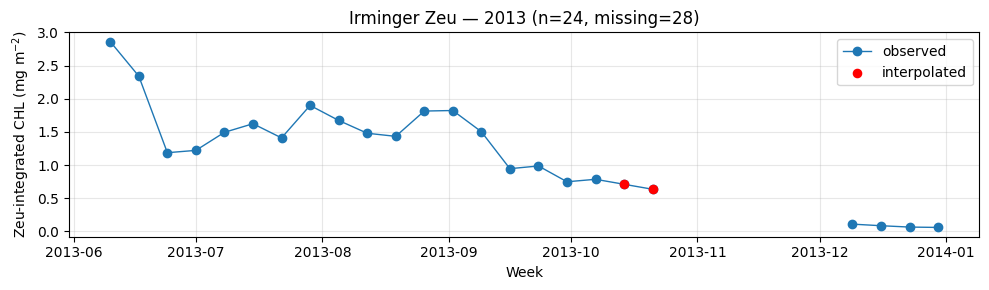

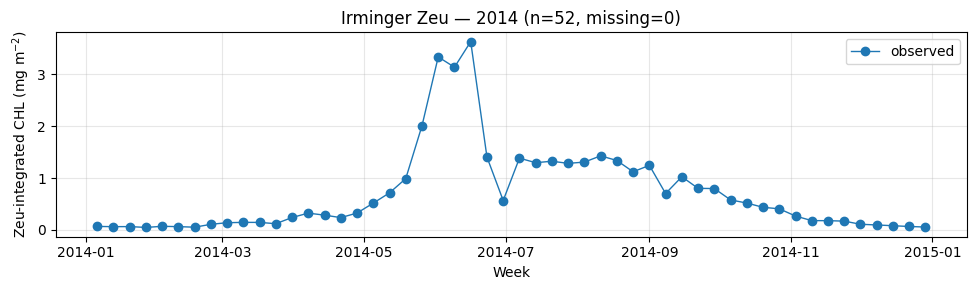

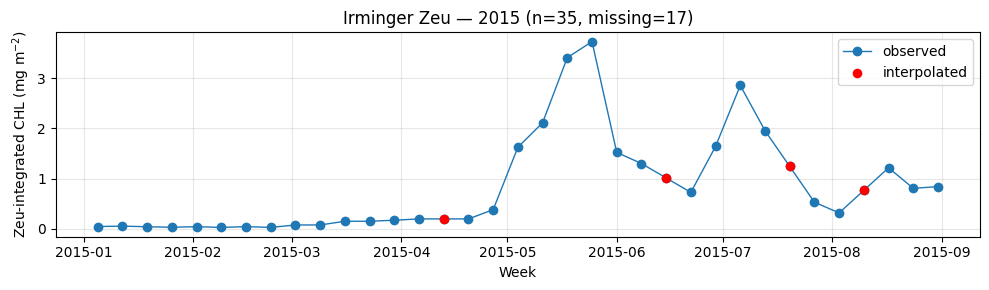

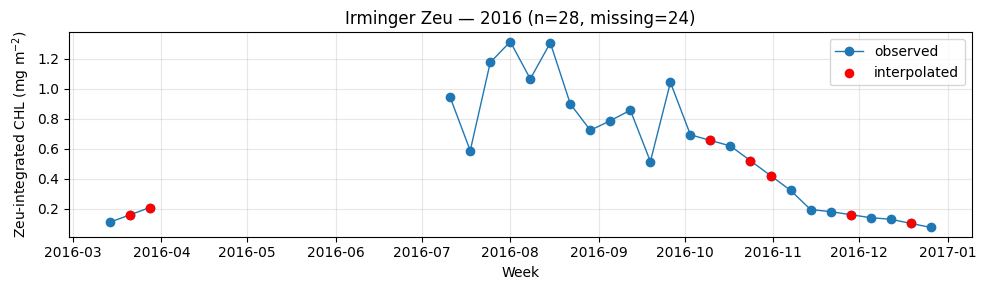

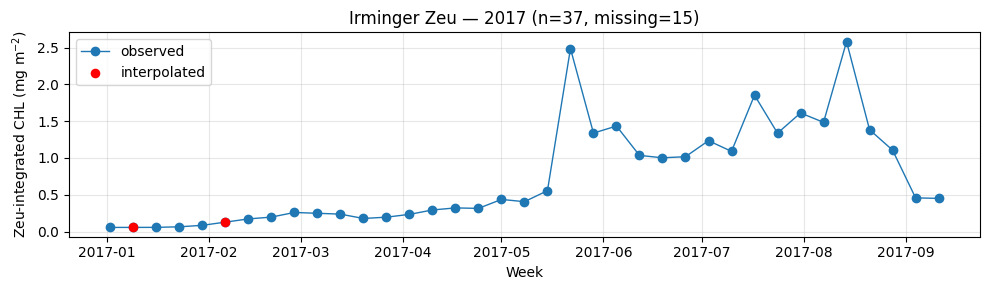

Skipping Irminger Zeu 2018: no data


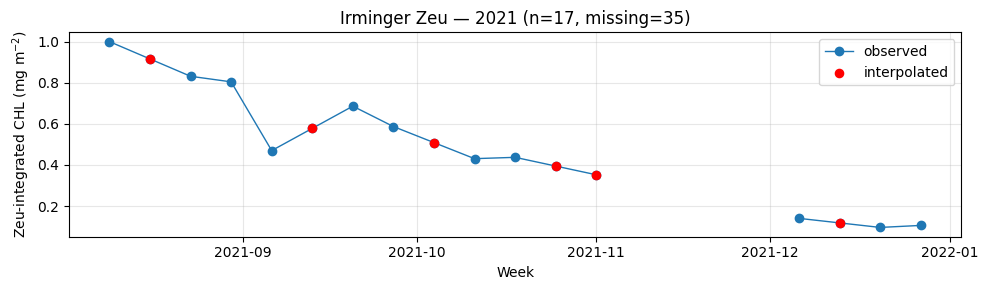

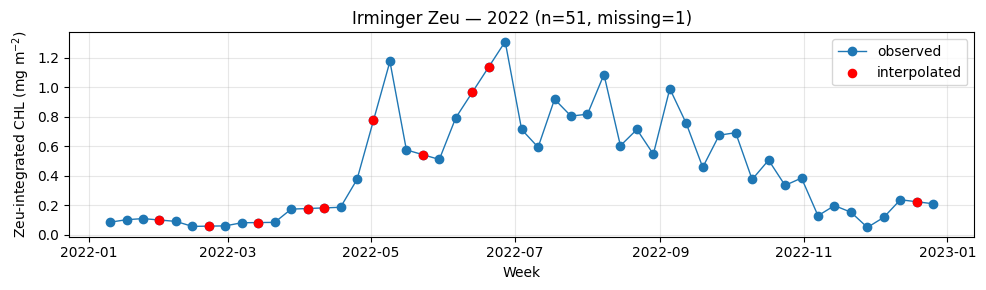

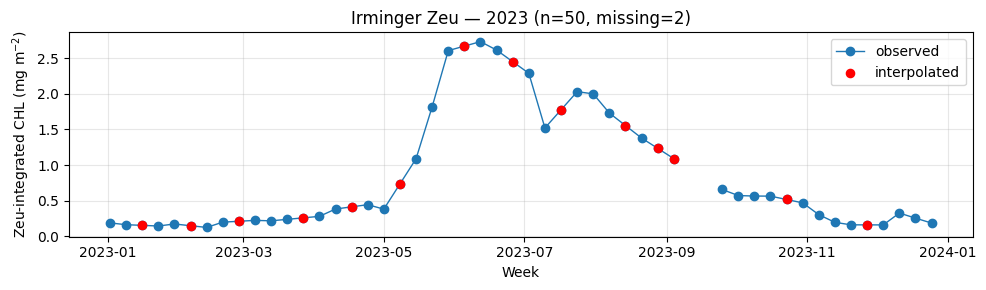

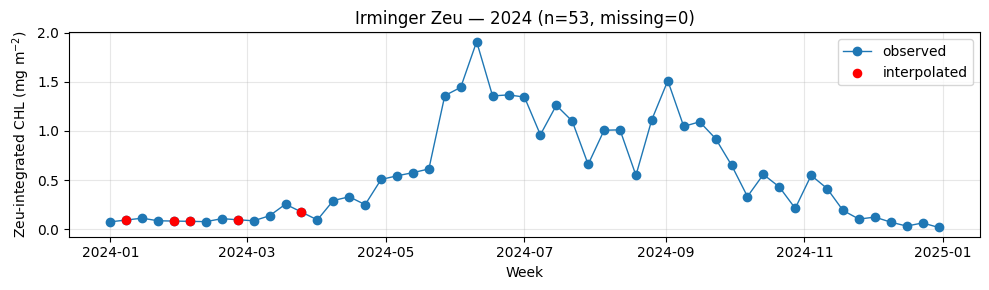

In [296]:
plot_years(
    irm_zeu_interp,
    value_col="INT_CHL_ZEU_interp",
    title_prefix="Irminger Zeu",
    ylabel="Zeu-integrated CHL (mg m$^{-2}$)"
)

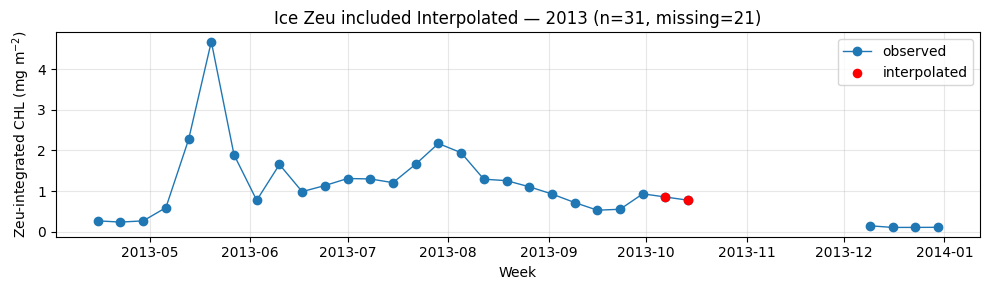

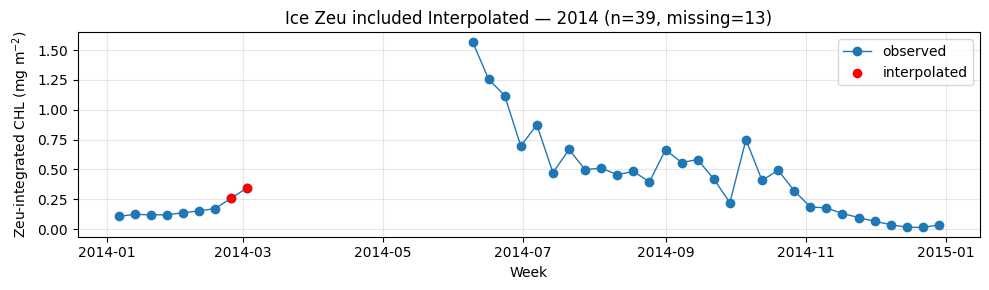

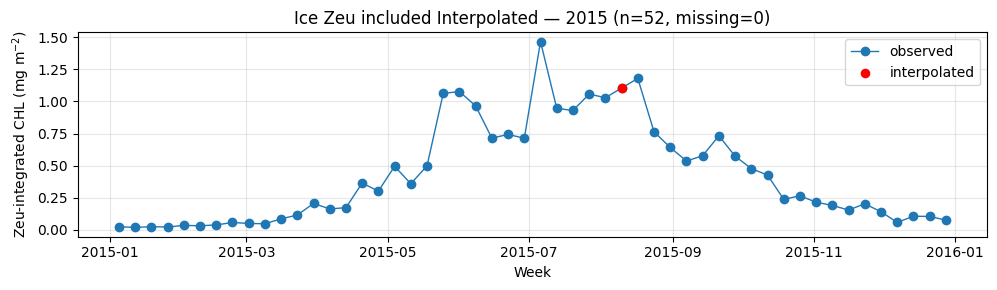

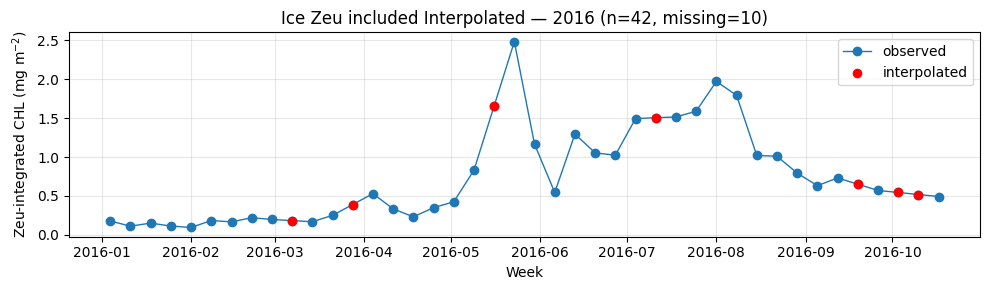

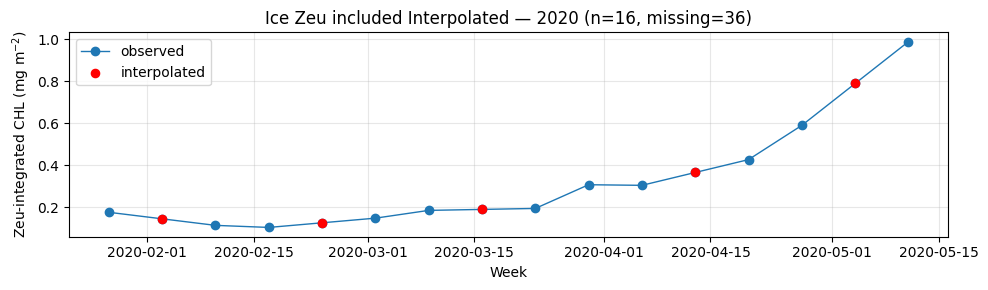

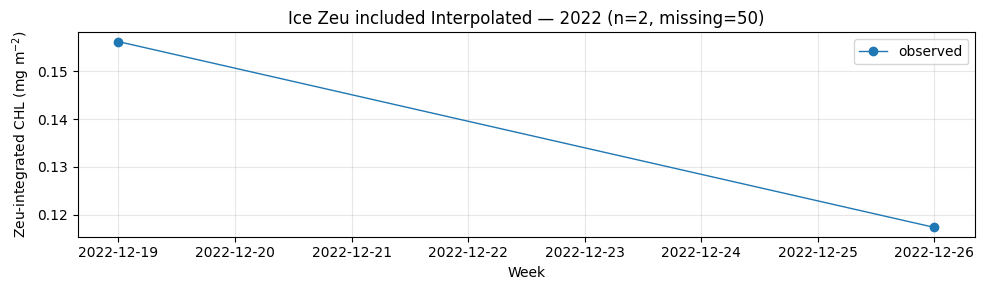

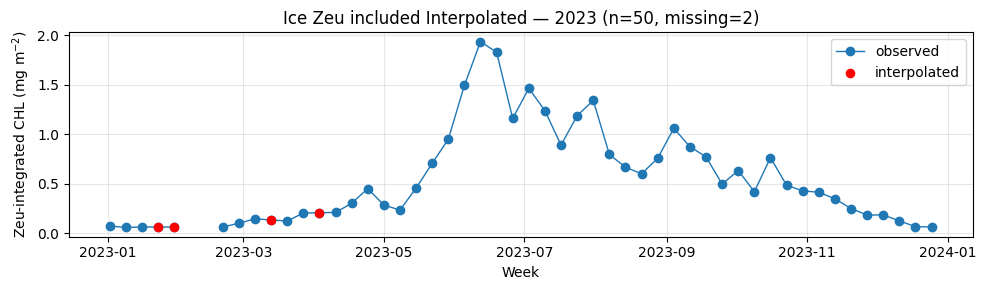

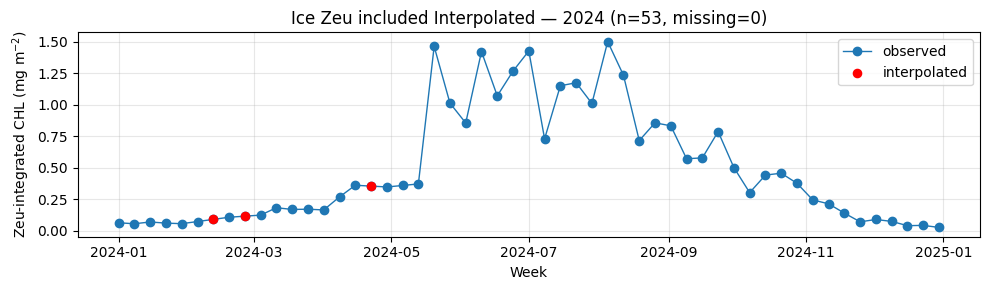

In [297]:
plot_years(
    ice_zeu_interp,
    value_col="INT_CHL_ZEU_interp",
    title_prefix="Ice Zeu included Interpolated",
    ylabel="Zeu-integrated CHL (mg m$^{-2}$)"
)

#### Data availability yr stats table

In [ ]:
# Creating year data availability quality summary (all in one function)
def year_quality_summary(
    df,
    value_col,
    time_col="week",
    freq="W-MON",
    max_gap=2
):
    """
    Compute year-level quality metrics for a weekly time series.
    This assumes df already has weekly dates in `time_col` and includes only
    observed (raw) values.

    Returns a DataFrame with one row per year and summary stats.
    """

    # Ensure time is datetime
    d = df.copy()
    d[time_col] = pd.to_datetime(d[time_col], errors="coerce")
    d["year"] = d[time_col].dt.year

    records = []

    for year, g in d.groupby("year"):
        g = g.sort_values(time_col)

        # Full yearly grid
        full_weeks = pd.date_range(
            f"{year}-01-01", f"{year}-12-31", freq=freq
        )

        # Reindex to full grid
        gg = (
            g.set_index(time_col)
             .reindex(full_weeks)
             .rename_axis(time_col)
             .reset_index()
        )

        # Break out the raw data
        raw = gg[value_col]

        # 1. Number of real obs
        n_obs = raw.notna().sum()

        # 2. Total missing weeks
        n_missing = raw.isna().sum()

        # 3. Percent missing
        pct_missing = 100 * n_missing / len(full_weeks)

        # 4. Longest consecutive missing run
        #    (compute NaN runs)
        is_na = raw.isna().to_numpy()
        # lengths of NaN runs
        runs = (
            [len(x) for x in np.split(is_na, np.where(~is_na)[0]) if x.all()]
            if len(is_na) > 0 else []
        )
        max_missing_run = max(runs) if runs else 0

        # 5. Median observed cluster gap
        #    (distance between successive weeks with real data)
        obs_times = gg.loc[raw.notna(), time_col]
        if len(obs_times) > 1:
            diffs = obs_times.diff().dt.days.div(7).dropna()
            median_gap = diffs.median()
        else:
            median_gap = np.nan

        # 6. Interpolatable gap weeks
        #    (NaN runs that are ≤ max_gap)
        small_runs = [r for r in runs if r <= max_gap]
        interpolatable_weeks = sum(small_runs)

        # 7. Now do the actual interpolation and count filled
        s_interp = raw.interpolate(
            method="linear",
            limit=max_gap,
            limit_area="inside"
        )
        n_interp_filled = (
            raw.isna() & s_interp.notna()
        ).sum()

        records.append({
            "year": year,
            "n_obs": n_obs,
            "n_missing": n_missing,
            "pct_missing": pct_missing,
            "max_missing_run": max_missing_run,
            "median_gap_weeks": median_gap,
            "interpolatable_weeks": interpolatable_weeks,
            "n_interpolated_filled": n_interp_filled,
            "total_weeks": len(full_weeks)
        })

    return pd.DataFrame.from_records(records).sort_values("year")

In [299]:
# 1) Irminger Zeu
yr_data_stat_irm_zeu = year_quality_summary(
    irm_zeu_interp,
    value_col="INT_CHL_ZEU_interp",
    time_col="week",
    freq="W-MON",
    max_gap=2
)
yr_data_stat_irm_zeu["source"] = "Irminger Zeu"

# 2) Icelandic Zeu
yr_data_stat_ice_zeu = year_quality_summary(
    ice_zeu_interp,
    value_col="INT_CHL_ZEU_interp",
    time_col="week",
    freq="W-MON",
    max_gap=2
)
yr_data_stat_ice_zeu["source"] = "Icelandic Zeu"

# 3) Irminger sur
yr_data_stat_irm_sur = year_quality_summary(
    irm_sur_interp,
    value_col="DEPTH_INT_CHL_sur_interp",
    time_col="week",
    freq="W-MON",
    max_gap=2
)
yr_data_stat_irm_sur["source"] = "Irminger 10m"

# 4) Icelandic 10m
yr_data_stat_ice_sur = year_quality_summary(
    ice_sur_interp,
    value_col="DEPTH_INT_CHL_sur_interp",
    time_col="week",
    freq="W-MON",
    max_gap=2
)
yr_data_stat_ice_sur["source"] = "Icelandic 10m"

In [320]:
# Concatenate all stats
all_quality_stats = pd.concat(
    [
        yr_data_stat_irm_zeu,
        yr_data_stat_ice_zeu,
        yr_data_stat_irm_sur,
        yr_data_stat_ice_sur,
    ],
    ignore_index=True
)

# Optional: sort by source then year
all_quality_stats = all_quality_stats.sort_values(["source", "year"])

In [321]:
# Make sure the output directory exists
import os

output_dir = "../Figures & Tables"
os.makedirs(output_dir, exist_ok=True)

# Save the combined quality summary
output_path = os.path.join(output_dir, "time_series_quality_summary.csv")
all_quality_stats.to_csv(output_path, index=False)

print(f"Saved quality summary table to:\n{output_path}")

Saved quality summary table to:
../Figures & Tables/time_series_quality_summary.csv


#### Filtering yrs

In [322]:
# Years to keep for Zeu
keep_years_irm_zeu = [2014, 2017, 2022, 2023, 2024]
keep_years_ice_zeu = [2015, 2016, 2023, 2024]

In [323]:
# Irminger Zeu – keep selected years
irm_zeu_interp_filt = irm_zeu_interp[
    irm_zeu_interp["year"].isin(keep_years_irm_zeu)
].copy()

# Icelandic Zeu – keep selected years
ice_zeu_interp_filt = ice_zeu_interp[
    ice_zeu_interp["year"].isin(keep_years_ice_zeu)
].copy()

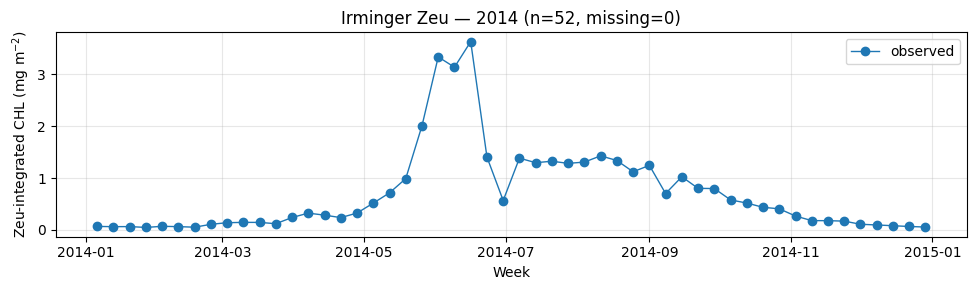

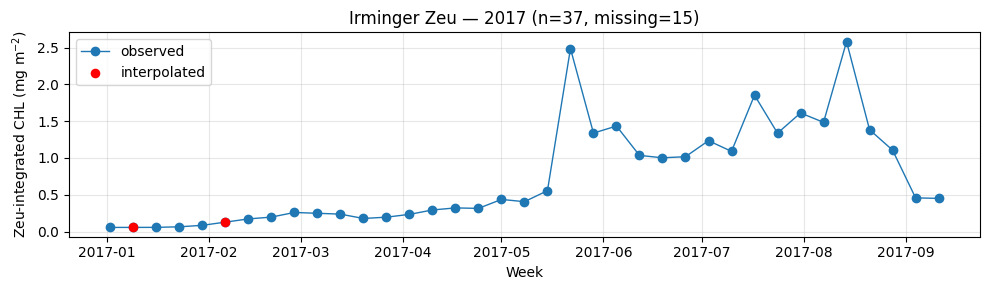

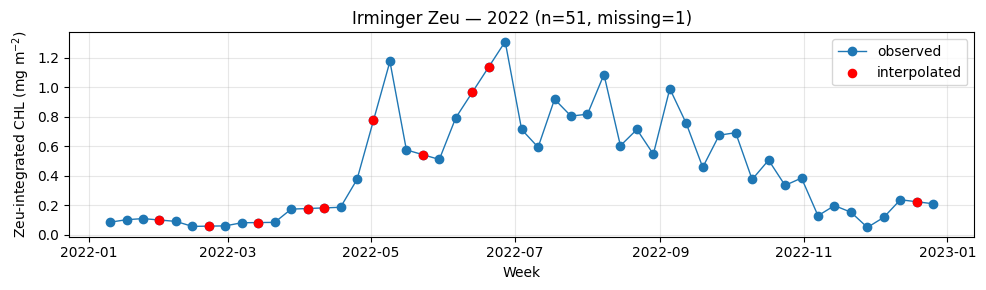

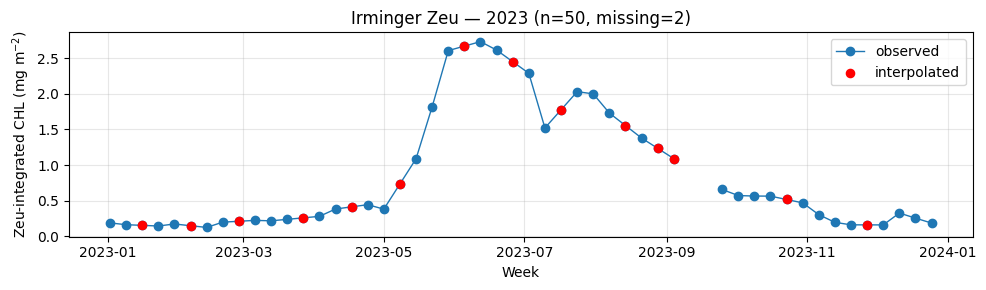

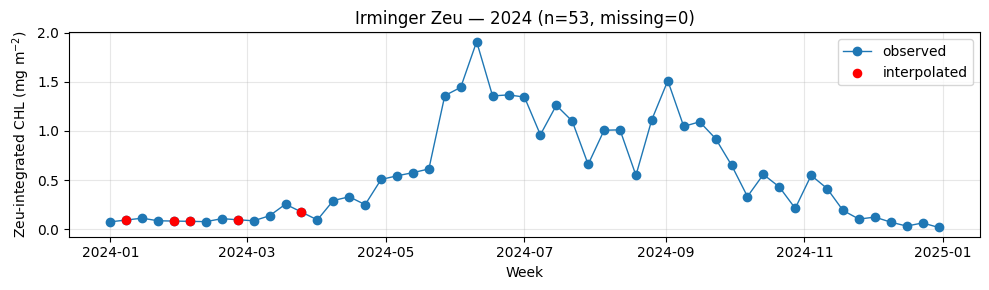

In [325]:
plot_years(
    irm_zeu_interp_filt,
    value_col="INT_CHL_ZEU_interp",
    title_prefix="Irminger Zeu",
    ylabel="Zeu-integrated CHL (mg m$^{-2}$)"
)

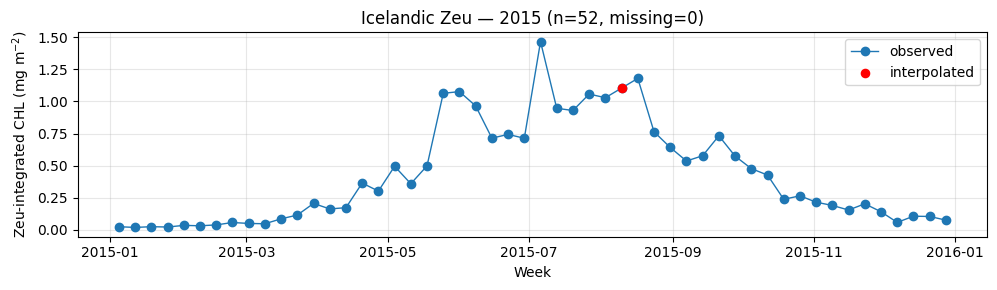

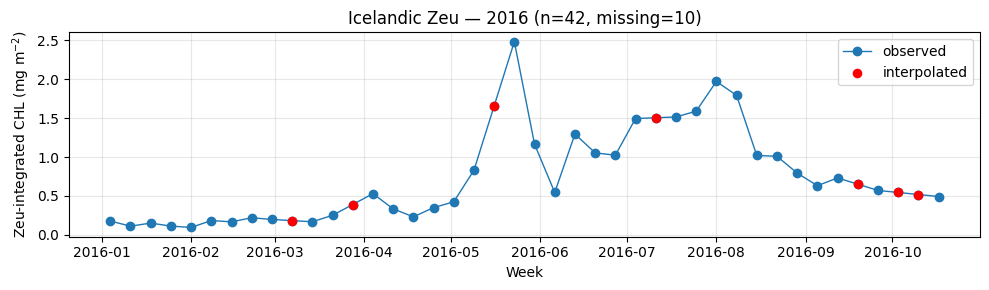

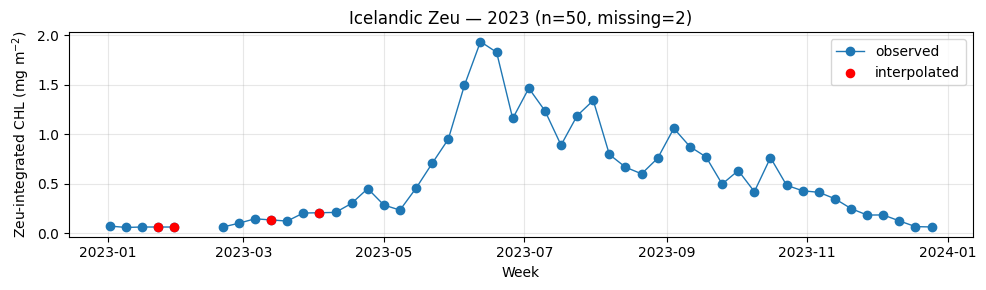

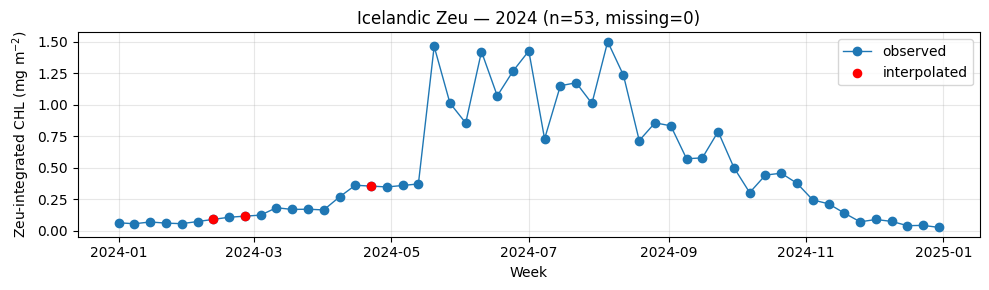

In [327]:
plot_years(
    ice_zeu_interp_filt,
    value_col="INT_CHL_ZEU_interp",
    title_prefix="Icelandic Zeu",
    ylabel="Zeu-integrated CHL (mg m$^{-2}$)"
)

## Phenological Indecies

Here estimating bloom Initiation Duration Termination and peak chla based of studies such as

### Gathering Climatologies

In [ ]:
# Bloom timing phenology
#Fully integrated dataset
monthly_clim_F_irm = month_clim_F.filter(pl.col("region") == "irminger")
monthly_clim_F_ice = month_clim_F.filter(pl.col("region") == "icelandic")

weekly_clim_F_irm = week_clim_F.filter(pl.col("region") == "irminger")
weekly_clim_F_ice = week_clim_F.filter(pl.col("region") == "icelandic")

#Surface sur
monthly_clim_sur_irm = monthly_clim_sur.filter(pl.col("region") == "irminger")
monthly_clim_sur_ice = monthly_clim_sur.filter(pl.col("region") == "icelandic")

weekly_clim_sur_irm = week_clim_sur.filter(pl.col("region") == "irminger")
weekly_clim_sur_ice = week_clim_sur.filter(pl.col("region") == "icelandic")

#Zeu
monthly_clim_zeu_irm = monthly_clim_zeu.filter(pl.col("region") == "irminger")
monthly_clim_zeu_ice = monthly_clim_zeu.filter(pl.col("region") == "icelandic")

weekly_clim_zeu_irm = week_clim_zeu.filter(pl.col("region") == "irminger")
weekly_clim_zeu_ice = week_clim_zeu.filter(pl.col("region") == "icelandic")

# Loading satellite data

icelandic_sat_w = pl.read_parquet('../data/satellite/sat_ice_clim_mean_w.parquet')
icelandic_sat_m = pl.read_parquet('../data/satellite/sat_ice_clim_mean_m.parquet')

irminger_sat_w = pl.read_parquet('../data/satellite/sat_irm_clim_mean_w.parquet')
irminger_sat_m = pl.read_parquet('../data/satellite/sat_irm_clim_mean_m.parquet')


### Function Gathering

In [301]:
def computing_bloomtimings():
    """
    Returns a dict of small helper functions for bloom phenology.
    Usage:
        bt = computing_bloomtimings()
        thr = bt["compute_threshold_from_annual_mean"](df, "chl")
        df2 = bt["add_above_threshold_flag"](df, "month", "chl", thr)
        df3 = bt["add_persistent_bloom_flag"](df2, above_col="above", min_consecutive=2)
        init_t = bt["get_initiation_time"](df3, "month")
        ...
    """

    # Estimating thresholds in this case 1.05 * annual mean chl
    def compute_threshold_from_annual_mean(
        df: pl.DataFrame,
        value_col: str,
        alpha: float = 1.05,
    ) -> float:
        """
        threshold = alpha * annual_mean(value)
        """
        annual_mean = df.select(pl.col(value_col).mean()).item()
        if annual_mean is None:
            raise ValueError("Annual mean is None (empty dataframe?).")
        return float(alpha * annual_mean)

    # Adding above threshold flag
    def add_above_threshold_flag(
        df: pl.DataFrame,
        t_col: str,
        value_col: str,
        threshold: float,
        out_col: str = "above",
    ) -> pl.DataFrame:
        return df.with_columns((pl.col(value_col) > threshold).alias(out_col))

    # Add persistent bloom flag int = (how many weeks above threshold)
    def add_persistent_bloom_flag(
        df: pl.DataFrame,
        above_col: str = "above",
        out_col: str = "is_bloom",
        min_consecutive: int = 2,
    ) -> pl.DataFrame:
        """
        Keeps only runs of True with length >= min_consecutive.
        Uses run-length encoding: changes create groups, then filter by run length.
        """
        # Group id increments when above_col changes
        df2 = df.with_columns(
            (pl.col(above_col) != pl.col(above_col).shift(1))
            .cast(pl.Int64)
            .cum_sum()
            .alias("_grp")
        )

        # Run length per group + whether the run is True
        df2 = df2.with_columns(
            pl.len().over("_grp").alias("_run_len"),
            pl.first(above_col).over("_grp").alias("_run_val"),
        )

        # is_bloom = True only if run is True and long enough
        df2 = df2.with_columns(
            ((pl.col("_run_val") == True) & (pl.col("_run_len") >= min_consecutive)).alias(out_col)
        )

        return df2.drop(["_grp", "_run_len", "_run_val"])

    # Identifying Initiation and termination times
    def get_initiation_time(df: pl.DataFrame, t_col: str, bloom_col: str = "is_bloom"):
        sub = df.filter(pl.col(bloom_col) == True).select(pl.col(t_col).min())
        return sub.item()  # returns None if no bloom

    def get_termination_time(df: pl.DataFrame, t_col: str, bloom_col: str = "is_bloom"):
        sub = df.filter(pl.col(bloom_col) == True).select(pl.col(t_col).max())
        return sub.item()

    # Getting peak bloom
    def get_peak_within_bloom(
        df: pl.DataFrame,
        t_col: str,
        value_col: str,
        bloom_col: str = "is_bloom",
    ):
        """
        Returns (t_peak, value_peak).
        If no bloom is detected, returns (None, None).
        """
        sub = df.filter(pl.col(bloom_col) == True)

        if sub.height == 0:
            return None, None

        # Sort by value descending, then time ascending (first peak if plateau)
        peak_row = (
            sub.sort([value_col, t_col], descending=[True, False])
            .select([t_col, value_col])
            .head(1)
        )

        t_peak = peak_row[t_col][0]
        v_peak = peak_row[value_col][0]

        return t_peak, v_peak

    # bloom duration
    def compute_duration(init_t, term_t):
        if init_t is None or term_t is None:
            return None
        return int(term_t - init_t)  # in bins (weeks or months)

    # Return as a small “toolkit”
    return {
        "compute_threshold_from_annual_mean": compute_threshold_from_annual_mean,
        "add_above_threshold_flag": add_above_threshold_flag,
        "add_persistent_bloom_flag": add_persistent_bloom_flag,
        "get_initiation_time": get_initiation_time,
        "get_termination_time": get_termination_time,
        "get_peak_within_bloom": get_peak_within_bloom,
        "compute_duration": compute_duration,
    }

### Running Monthly
Same code minor changes between weekly and monthly (mainly alpha and min_consecutive)

In [302]:
# Wrap to run above grouped functions (for simplicity)

# alpha is the threshold multiplier, consecutive is the minimum number of consecutive months
def run_bloom_metrics(df, t_col, value_col, alpha=1.05, min_consecutive=1):
    bt = computing_bloomtimings()

    thr = bt["compute_threshold_from_annual_mean"](df, value_col, alpha)
    df = bt["add_above_threshold_flag"](df, t_col, value_col, thr)
    df = bt["add_persistent_bloom_flag"](df, min_consecutive=min_consecutive)

    init_t = bt["get_initiation_time"](df, t_col)
    term_t = bt["get_termination_time"](df, t_col)
    peak_t, peak_v = bt["get_peak_within_bloom"](df, t_col, value_col)
    dur = bt["compute_duration"](init_t, term_t)

    return {
        "threshold": thr,
        "initiation": init_t,
        "peak_time": peak_t,
        "peak_value": peak_v,
        "termination": term_t,
        "duration": dur,
        "df": df,
    }

In [ ]:
# Estimating Bloomtimings Monthly

# Integrated
int_timings_irm = run_bloom_metrics(monthly_clim_F_irm, "month", "DEPTH_INT_CHL_clim")
int_timings_ice = run_bloom_metrics(monthly_clim_F_ice, "month", "DEPTH_INT_CHL_clim")

# sur
int_timings_irm_sur = run_bloom_metrics(monthly_clim_sur_irm, "month", "DEPTH_INT_CHL_sur_clim")
int_timings_ice_sur = run_bloom_metrics(monthly_clim_sur_ice, "month", "DEPTH_INT_CHL_sur_clim")

#Zeu
int_timings_irm_zeu = run_bloom_metrics(monthly_clim_zeu_irm, "month", "INT_CHL_ZEU_clim")
int_timings_ice_zeu = run_bloom_metrics(monthly_clim_zeu_ice, "month", "INT_CHL_ZEU_clim")

# Satellite
int_timings_irm_sat = run_bloom_metrics(irminger_sat_m, "month", "CHL")
int_timings_ice_sat = run_bloom_metrics(icelandic_sat_m, "month", "CHL")


In [304]:
def metrics_to_row(
    metrics: dict,
    *,
    region: str,
    source: str,
    series: str,
    t_col: str = "month",
    value_col: str | None = None,
) -> dict:
    """
    Convert run_bloom_metrics output dict -> one tidy row.
    region: "Irminger" / "Iceland"
    source: "BGC" / "Satellite" etc.
    series: "Integrated" / "10m" / "Surface" etc.
    """
    # helper: safely get possible key variants
    def _get(*keys, default=None):
        for k in keys:
            if k in metrics:
                return metrics[k]
        return default

    return {
        "region": region,
        "source": source,
        "series": series,
        "t_col": t_col,
        "value_col": value_col,
        "threshold": _get("threshold"),
        "init_t": _get("initiation", "init_t"),
        "peak_t": _get("peak_time", "peak_t"),
        "peak_value": _get("peak_value", "peak_chl"),
        "term_t": _get("termination", "term_t"),
        "duration_bins": _get("duration", "duration_bins"),
    }


def build_master_table(rows: list[dict]) -> pl.DataFrame:
    df = pl.DataFrame(rows)

    # ensure consistent dtypes where possible
    df = df.with_columns(
        [
            pl.col("threshold").cast(pl.Float64, strict=False),
            pl.col("peak_value").cast(pl.Float64, strict=False),
            pl.col("init_t").cast(pl.Int64, strict=False),
            pl.col("peak_t").cast(pl.Int64, strict=False),
            pl.col("term_t").cast(pl.Int64, strict=False),
            pl.col("duration_bins").cast(pl.Int64, strict=False),
        ]
    )
    return df

In [305]:
rows = [
    metrics_to_row(int_timings_irm, region="Irminger", source="BGC", series="Integrated", t_col="month", value_col="DEPTH_INT_CHL_clim"),
    metrics_to_row(int_timings_ice, region="Iceland", source="BGC", series="Integrated", t_col="month", value_col="DEPTH_INT_CHL_clim"),

    metrics_to_row(int_timings_irm_10m, region="Irminger", source="BGC", series="10m", t_col="month", value_col="DEPTH_INT_CHL_10m_clim"),
    metrics_to_row(int_timings_ice_10m, region="Iceland", source="BGC", series="10m", t_col="month", value_col="DEPTH_INT_CHL_10m_clim"),

    metrics_to_row(int_timings_irm_sat, region="Irminger", source="Satellite", series="Surface", t_col="month", value_col="CHL"),
    metrics_to_row(int_timings_ice_sat, region="Iceland", source="Satellite", series="Surface", t_col="month", value_col="CHL"),
    
    metrics_to_row(int_timings_irm_zeu, region="Irminger", source="BGC", series="Zeu", t_col="month", value_col="INT_CHL_ZEU_clim"),
    metrics_to_row(int_timings_ice_zeu, region="Iceland", source="BGC", series="Zeu", t_col="month", value_col="INT_CHL_ZEU_clim"),
]

phenology_table = build_master_table(rows)
phenology_table

shape: (8, 11)
┌──────────┬───────────┬────────────┬───────┬───┬────────┬────────────┬────────┬───────────────┐
│ region   ┆ source    ┆ series     ┆ t_col ┆ … ┆ peak_t ┆ peak_value ┆ term_t ┆ duration_bins │
│ ---      ┆ ---       ┆ ---        ┆ ---   ┆   ┆ ---    ┆ ---        ┆ ---    ┆ ---           │
│ str      ┆ str       ┆ str        ┆ str   ┆   ┆ i64    ┆ f64        ┆ i64    ┆ i64           │
╞══════════╪═══════════╪════════════╪═══════╪═══╪════════╪════════════╪════════╪═══════════════╡
│ Irminger ┆ BGC       ┆ Integrated ┆ month ┆ … ┆ 6      ┆ 0.161649   ┆ 9      ┆ 5             │
│ Iceland  ┆ BGC       ┆ Integrated ┆ month ┆ … ┆ 5      ┆ 0.328427   ┆ 7      ┆ 3             │
│ Irminger ┆ BGC       ┆ 10m        ┆ month ┆ … ┆ 6      ┆ 1.855483   ┆ 9      ┆ 4             │
│ Iceland  ┆ BGC       ┆ 10m        ┆ month ┆ … ┆ 5      ┆ 1.965519   ┆ 9      ┆ 4             │
│ Irminger ┆ Satellite ┆ Surface    ┆ month ┆ … ┆ 6      ┆ 0.705802   ┆ 9      ┆ 4             │
│ Iceland  ┆ Satellite ┆ Surface    ┆ month ┆ … ┆ 8      ┆ 0.736672   ┆ 9      ┆ 4             │
│ Irminger ┆ BGC       ┆ Zeu        ┆ month ┆ … ┆ 6      ┆ 1.957191   ┆ 9      ┆ 4             │
│ Iceland  ┆ BGC       ┆ Zeu        ┆ month ┆ … ┆ 5      ┆ 1.677806   ┆ 9      ┆ 4             │
└──────────┴───────────┴────────────┴───────┴───┴────────┴────────────┴────────┴───────────────┘

In [306]:
phenology_table.write_csv("../Figures & Tables/phenology_metrics_master_monthly.csv")

#### Displaying dat a

In [307]:

def _to_pandas_xy(df: pl.DataFrame, t_col: str, value_col: str):
    # minimal conversion for plotting
    pdf = df.select([t_col, value_col]).to_pandas()
    return pdf[t_col].values, pdf[value_col].values

def plot_seasonal_with_markers_two_panel(
    *,
    irm: dict[str, dict],
    ice: dict[str, dict],
    t_col: str = "month",
    title: str = "Climatological Chl-a with bloom timings",
):
    """
    irm and ice are dicts like:
      irm = {"Integrated": int_timings_irm, "10m": int_timings_irm_10m, "Satellite": int_timings_irm_sat}
      ice = {"Integrated": int_timings_ice, "10m": int_timings_ice_10m, "Satellite": int_timings_ice_sat}

    Each metrics dict must contain:
      - "df" : Polars DataFrame with time series
      - "threshold", "initiation", "peak_time", "termination"
    """

    def get_key(m, *keys, default=None):
        for k in keys:
            if k in m:
                return m[k]
        return default

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    fig.suptitle(title)

    for ax, region_name, bundle in [
        (axes[0], "Irminger", irm),
        (axes[1], "Iceland", ice),
    ]:
        for label, metrics in bundle.items():
            df = metrics.get("df", None)
            if df is None:
                continue

            # pick value_col: use the one you passed in via metrics (if you stored it),
            # otherwise infer from df columns by choosing the first non-time numeric
            value_col = metrics.get("value_col", None)
            if value_col is None:
                # best effort inference
                candidates = [c for c in df.columns if c != t_col and df[c].dtype in (pl.Float32, pl.Float64, pl.Int64, pl.Int32)]
                # prefer "CHL" or contains "CHL"
                prefer = [c for c in candidates if "CHL" in c]
                value_col = prefer[0] if prefer else candidates[0]

            x, y = _to_pandas_xy(df, t_col, value_col)
            ax.plot(x, y, marker="o", linewidth=1, label=label)

            thr = get_key(metrics, "threshold")
            init_t = get_key(metrics, "initiation", "init_t")
            peak_t = get_key(metrics, "peak_time", "peak_t")
            term_t = get_key(metrics, "termination", "term_t")

            # threshold line per-series
            if thr is not None:
                ax.axhline(thr, linestyle="--", linewidth=1)

            # markers
            if init_t is not None:
                ax.axvline(init_t, linestyle=":", linewidth=1)
            if peak_t is not None:
                ax.axvline(peak_t, linestyle="-.", linewidth=1)
            if term_t is not None:
                ax.axvline(term_t, linestyle=":", linewidth=1)

            # shade bloom window
            if init_t is not None and term_t is not None:
                ax.axvspan(init_t, term_t, alpha=0.1)

        ax.set_title(region_name)
        ax.set_xlabel(t_col)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Chl-a (climatology)")
    axes[1].legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

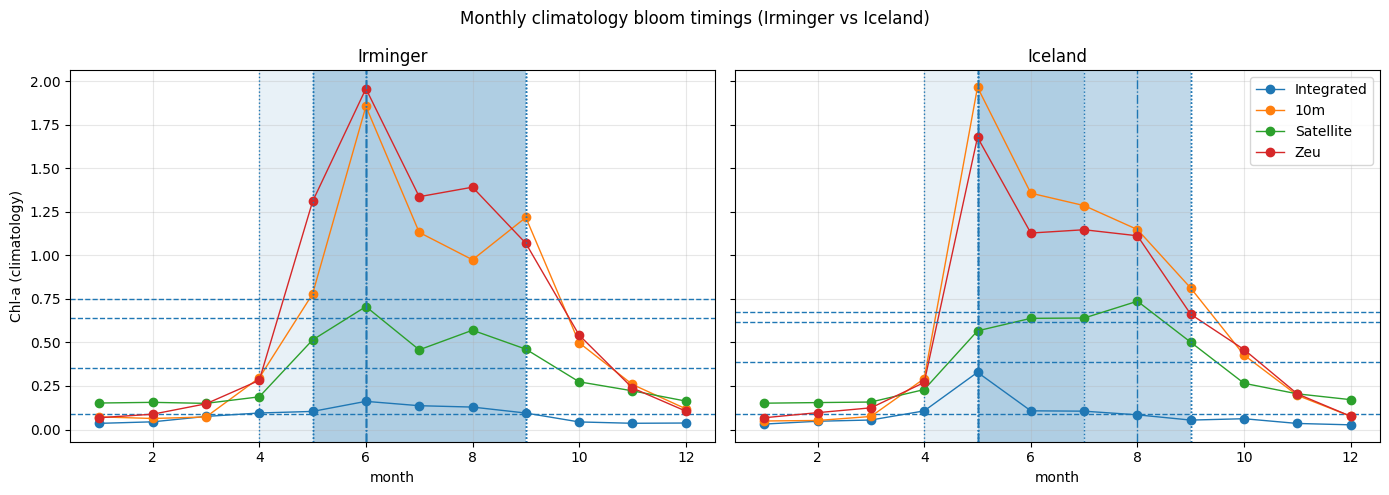

In [ ]:
plot_seasonal_with_markers_two_panel(
    irm={
        "10m": {**int_timings_irm_10m, "value_col": "DEPTH_INT_CHL_10m_clim"},
        "Satellite": {**int_timings_irm_sat, "value_col": "CHL"},
        "Zeu": {**int_timings_irm_zeu, "value_col": "INT_CHL_ZEU_clim"}
    },
    ice={
        "10m": {**int_timings_ice_10m, "value_col": "DEPTH_INT_CHL_10m_clim"},
        "Satellite": {**int_timings_ice_sat, "value_col": "CHL"},
        "Zeu": {**int_timings_ice_zeu, "value_col": "INT_CHL_ZEU_clim"}
    },
    t_col="month",
    title="Monthly climatology bloom timings (Irminger vs Iceland)",
)

In [309]:

def plot_timeline_bars(
    phenology_table: pl.DataFrame,
    *,
    t_col_label: str = "month",
    title: str = "Bloom timing comparison",
):
    """
    For each region, draw bars from init->term and a dot at peak.
    """

    pdf = phenology_table.to_pandas()

    regions = list(pdf["region"].unique())
    # stable order (optional)
    regions = sorted(regions)

    fig, axes = plt.subplots(1, len(regions), figsize=(14, 4), sharey=True)
    if len(regions) == 1:
        axes = [axes]

    fig.suptitle(title)

    for ax, region in zip(axes, regions):
        sub = pdf[pdf["region"] == region].copy()

        # y order: source+series
        sub["label"] = sub["source"].astype(str) + " | " + sub["series"].astype(str)
        sub = sub.sort_values(["source", "series"])

        y = np.arange(len(sub))
        ax.set_yticks(y)
        ax.set_yticklabels(sub["label"])

        for i, row in enumerate(sub.itertuples(index=False)):
            init_t = getattr(row, "init_t")
            term_t = getattr(row, "term_t")
            peak_t = getattr(row, "peak_t")

            # bar
            if not np.isnan(init_t) and not np.isnan(term_t):
                ax.hlines(i, init_t, term_t, linewidth=6)

            # peak dot
            if not np.isnan(peak_t):
                ax.plot(peak_t, i, marker="o")

        ax.set_title(region)
        ax.set_xlabel(t_col_label)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

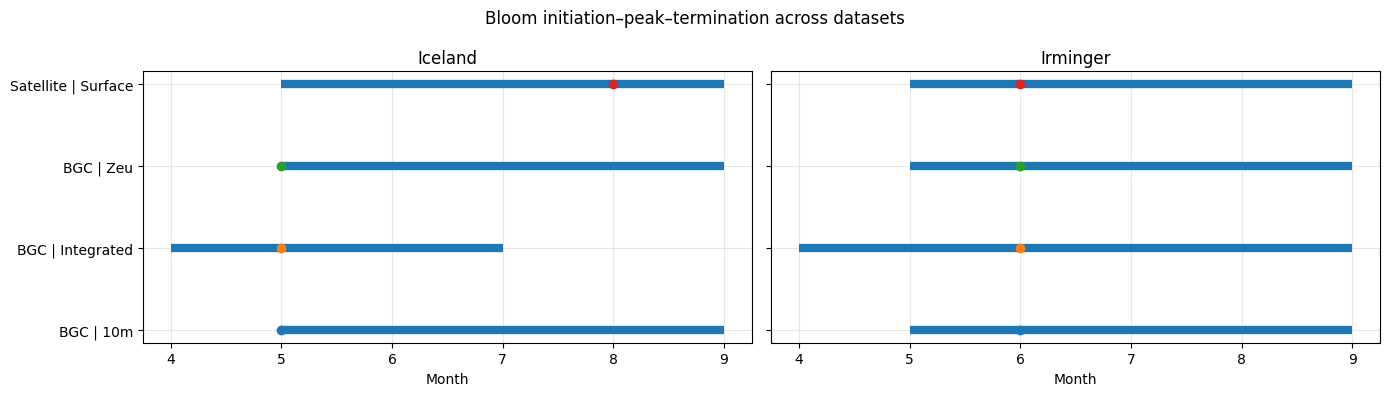

In [310]:
plot_timeline_bars(
    phenology_table,
    t_col_label="Month",
    title="Bloom initiation–peak–termination across datasets",
)

In [311]:
def delta_vs_satellite(
    phenology_table: pl.DataFrame,
    *,
    sat_source: str = "Satellite",
    bgc_source: str = "BGC",
    bgc_series: str = "Integrated",
) -> pl.DataFrame:
    """
    Compute (Satellite - BGC Integrated) deltas for each region.
    """
    sat = phenology_table.filter((pl.col("source") == sat_source))
    bgc = phenology_table.filter((pl.col("source") == bgc_source) & (pl.col("series") == bgc_series))

    joined = sat.join(bgc, on="region", how="inner", suffix="_bgc")

    out = joined.select(
        pl.col("region"),
        (pl.col("init_t") - pl.col("init_t_bgc")).alias("d_init"),
        (pl.col("peak_t") - pl.col("peak_t_bgc")).alias("d_peak"),
        (pl.col("term_t") - pl.col("term_t_bgc")).alias("d_term"),
        (pl.col("duration_bins") - pl.col("duration_bins_bgc")).alias("d_duration"),
        (pl.col("peak_value") - pl.col("peak_value_bgc")).alias("d_peak_value"),
    )
    return out

In [312]:
delta_table = delta_vs_satellite(phenology_table, bgc_series="Integrated")
delta_table

shape: (2, 6)
┌──────────┬────────┬────────┬────────┬────────────┬──────────────┐
│ region   ┆ d_init ┆ d_peak ┆ d_term ┆ d_duration ┆ d_peak_value │
│ ---      ┆ ---    ┆ ---    ┆ ---    ┆ ---        ┆ ---          │
│ str      ┆ i64    ┆ i64    ┆ i64    ┆ i64        ┆ f64          │
╞══════════╪════════╪════════╪════════╪════════════╪══════════════╡
│ Irminger ┆ 1      ┆ 0      ┆ 0      ┆ -1         ┆ 0.544153     │
│ Iceland  ┆ 1      ┆ 3      ┆ 2      ┆ 1          ┆ 0.408246     │
└──────────┴────────┴────────┴────────┴────────────┴──────────────┘

### Running Weekly

In [313]:
# Wrap to run above grouped functions (for simplicity)

# alpha is the threshold multiplier, consecutive is the minimum number of consecutive months
def run_bloom_metrics(df, t_col, value_col, alpha=1.05, min_consecutive=2):
    bt = computing_bloomtimings()

    thr = bt["compute_threshold_from_annual_mean"](df, value_col, alpha)
    df = bt["add_above_threshold_flag"](df, t_col, value_col, thr)
    df = bt["add_persistent_bloom_flag"](df, min_consecutive=min_consecutive)

    init_t = bt["get_initiation_time"](df, t_col)
    term_t = bt["get_termination_time"](df, t_col)
    peak_t, peak_v = bt["get_peak_within_bloom"](df, t_col, value_col)
    dur = bt["compute_duration"](init_t, term_t)

    return {
        "threshold": thr,
        "initiation": init_t,
        "peak_time": peak_t,
        "peak_value": peak_v,
        "termination": term_t,
        "duration": dur,
        "df": df,
    }

In [314]:
# Estimating Bloomtimings Weekly

# Integrated
int_timings_irm = run_bloom_metrics(weekly_clim_F_irm, "week", "DEPTH_INT_CHL_clim")
int_timings_ice = run_bloom_metrics(weekly_clim_F_ice, "week", "DEPTH_INT_CHL_clim")

# 10m
int_timings_irm_10m = run_bloom_metrics(weekly_clim_10m_irm, "week", "DEPTH_INT_CHL_10m_clim")
int_timings_ice_10m = run_bloom_metrics(weekly_clim_10m_ice, "week", "DEPTH_INT_CHL_10m_clim")

#Zeu
int_timings_irm_zeu = run_bloom_metrics(weekly_clim_zeu_irm, "week", "INT_CHL_ZEU_clim")
int_timings_ice_zeu = run_bloom_metrics(weekly_clim_zeu_ice, "week", "INT_CHL_ZEU_clim")

# Satellite
int_timings_irm_sat = run_bloom_metrics(irminger_sat_w, "week", "CHL")
int_timings_ice_sat = run_bloom_metrics(icelandic_sat_w, "week", "CHL")

In [315]:

def metrics_to_row(
    metrics: dict,
    *,
    region: str,
    source: str,
    series: str,
    t_col: str = "month",
    value_col: str | None = None,
) -> dict:
    """
    Convert run_bloom_metrics output dict -> one tidy row.
    region: "Irminger" / "Iceland"
    source: "BGC" / "Satellite" etc.
    series: "Integrated" / "10m" / "Surface" etc.
    """
    # helper: safely get possible key variants
    def _get(*keys, default=None):
        for k in keys:
            if k in metrics:
                return metrics[k]
        return default

    return {
        "region": region,
        "source": source,
        "series": series,
        "t_col": t_col,
        "value_col": value_col,
        "threshold": _get("threshold"),
        "init_t": _get("initiation", "init_t"),
        "peak_t": _get("peak_time", "peak_t"),
        "peak_value": _get("peak_value", "peak_chl"),
        "term_t": _get("termination", "term_t"),
        "duration_bins": _get("duration", "duration_bins"),
    }


def build_master_table(rows: list[dict]) -> pl.DataFrame:
    df = pl.DataFrame(rows)

    # ensure consistent dtypes where possible
    df = df.with_columns(
        [
            pl.col("threshold").cast(pl.Float64, strict=False),
            pl.col("peak_value").cast(pl.Float64, strict=False),
            pl.col("init_t").cast(pl.Int64, strict=False),
            pl.col("peak_t").cast(pl.Int64, strict=False),
            pl.col("term_t").cast(pl.Int64, strict=False),
            pl.col("duration_bins").cast(pl.Int64, strict=False),
        ]
    )
    return df

In [316]:
rows = [
    metrics_to_row(int_timings_irm, region="Irminger", source="BGC", series="Integrated", t_col="week", value_col="DEPTH_INT_CHL_clim"),
    metrics_to_row(int_timings_ice, region="Iceland", source="BGC", series="Integrated", t_col="week", value_col="DEPTH_INT_CHL_clim"),

    metrics_to_row(int_timings_irm_10m, region="Irminger", source="BGC", series="10m", t_col="week", value_col="DEPTH_INT_CHL_10m_clim"),
    metrics_to_row(int_timings_ice_10m, region="Iceland", source="BGC", series="10m", t_col="week", value_col="DEPTH_INT_CHL_10m_clim"),

    metrics_to_row(int_timings_irm_sat, region="Irminger", source="Satellite", series="Surface", t_col="week", value_col="CHL"),
    metrics_to_row(int_timings_ice_sat, region="Iceland", source="Satellite", series="Surface", t_col="week", value_col="CHL"),

    metrics_to_row(int_timings_irm_zeu, region="Irminger", source="BGC", series="Zeu", t_col="week", value_col="INT_CHL_ZEU_clim"),
    metrics_to_row(int_timings_ice_zeu, region="Iceland", source="BGC", series="Zeu", t_col="week", value_col="INT_CHL_ZEU_clim"),
]

phenology_table = build_master_table(rows)
phenology_table

shape: (8, 11)
┌──────────┬───────────┬────────────┬───────┬───┬────────┬────────────┬────────┬───────────────┐
│ region   ┆ source    ┆ series     ┆ t_col ┆ … ┆ peak_t ┆ peak_value ┆ term_t ┆ duration_bins │
│ ---      ┆ ---       ┆ ---        ┆ ---   ┆   ┆ ---    ┆ ---        ┆ ---    ┆ ---           │
│ str      ┆ str       ┆ str        ┆ str   ┆   ┆ i64    ┆ f64        ┆ i64    ┆ i64           │
╞══════════╪═══════════╪════════════╪═══════╪═══╪════════╪════════════╪════════╪═══════════════╡
│ Irminger ┆ BGC       ┆ Integrated ┆ week  ┆ … ┆ 24     ┆ 0.4292     ┆ 38     ┆ 24            │
│ Iceland  ┆ BGC       ┆ Integrated ┆ week  ┆ … ┆ 21     ┆ 0.702113   ┆ 32     ┆ 16            │
│ Irminger ┆ BGC       ┆ 10m        ┆ week  ┆ … ┆ 24     ┆ 3.223321   ┆ 40     ┆ 16            │
│ Iceland  ┆ BGC       ┆ 10m        ┆ week  ┆ … ┆ 21     ┆ 4.079177   ┆ 39     ┆ 20            │
│ Irminger ┆ Satellite ┆ Surface    ┆ week  ┆ … ┆ 24     ┆ 0.810984   ┆ 39     ┆ 19            │
│ Iceland  ┆ Satellite ┆ Surface    ┆ week  ┆ … ┆ 32     ┆ 0.740737   ┆ 40     ┆ 21            │
│ Irminger ┆ BGC       ┆ Zeu        ┆ week  ┆ … ┆ 24     ┆ 2.447352   ┆ 39     ┆ 20            │
│ Iceland  ┆ BGC       ┆ Zeu        ┆ week  ┆ … ┆ 21     ┆ 4.232368   ┆ 37     ┆ 17            │
└──────────┴───────────┴────────────┴───────┴───┴────────┴────────────┴────────┴───────────────┘

In [317]:
phenology_table.write_csv("../Figures & Tables/phenology_metrics_master_weekly.csv")

###

In [318]:

def _to_pandas_xy(df: pl.DataFrame, t_col: str, value_col: str):
    # minimal conversion for plotting
    pdf = df.select([t_col, value_col]).to_pandas()
    return pdf[t_col].values, pdf[value_col].values

def plot_seasonal_with_markers_two_panel(
    *,
    irm: dict[str, dict],
    ice: dict[str, dict],
    t_col: str = "month",
    title: str = "Climatological Chl-a with bloom timings",
):
    """
    irm and ice are dicts like:
      irm = {"Integrated": int_timings_irm, "10m": int_timings_irm_10m, "Satellite": int_timings_irm_sat}
      ice = {"Integrated": int_timings_ice, "10m": int_timings_ice_10m, "Satellite": int_timings_ice_sat}

    Each metrics dict must contain:
      - "df" : Polars DataFrame with time series
      - "threshold", "initiation", "peak_time", "termination"
    """

    def get_key(m, *keys, default=None):
        for k in keys:
            if k in m:
                return m[k]
        return default

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    fig.suptitle(title)

    for ax, region_name, bundle in [
        (axes[0], "Irminger", irm),
        (axes[1], "Iceland", ice),
    ]:
        for label, metrics in bundle.items():
            df = metrics.get("df", None)
            if df is None:
                continue

            # pick value_col: use the one you passed in via metrics (if you stored it),
            # otherwise infer from df columns by choosing the first non-time numeric
            value_col = metrics.get("value_col", None)
            if value_col is None:
                # best effort inference
                candidates = [c for c in df.columns if c != t_col and df[c].dtype in (pl.Float32, pl.Float64, pl.Int64, pl.Int32)]
                # prefer "CHL" or contains "CHL"
                prefer = [c for c in candidates if "CHL" in c]
                value_col = prefer[0] if prefer else candidates[0]

            x, y = _to_pandas_xy(df, t_col, value_col)
            ax.plot(x, y, marker="o", linewidth=1, label=label)

            thr = get_key(metrics, "threshold")
            init_t = get_key(metrics, "initiation", "init_t")
            peak_t = get_key(metrics, "peak_time", "peak_t")
            term_t = get_key(metrics, "termination", "term_t")

            # threshold line per-series
            if thr is not None:
                ax.axhline(thr, linestyle="--", linewidth=1)

            # markers
            if init_t is not None:
                ax.axvline(init_t, linestyle=":", linewidth=1)
            if peak_t is not None:
                ax.axvline(peak_t, linestyle="-.", linewidth=1)
            if term_t is not None:
                ax.axvline(term_t, linestyle=":", linewidth=1)

            # shade bloom window
            if init_t is not None and term_t is not None:
                ax.axvspan(init_t, term_t, alpha=0.1)

        ax.set_title(region_name)
        ax.set_xlabel(t_col)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Chl-a (climatology)")
    axes[1].legend(loc="best", frameon=True)
    plt.tight_layout()
    plt.show()

ColumnNotFoundError: unable to find column "month"; valid columns: ["region", "week", "DEPTH_INT_CHL_clim", "DEPTH_INT_CHL_std", "n_profiles", "above", "is_bloom"]

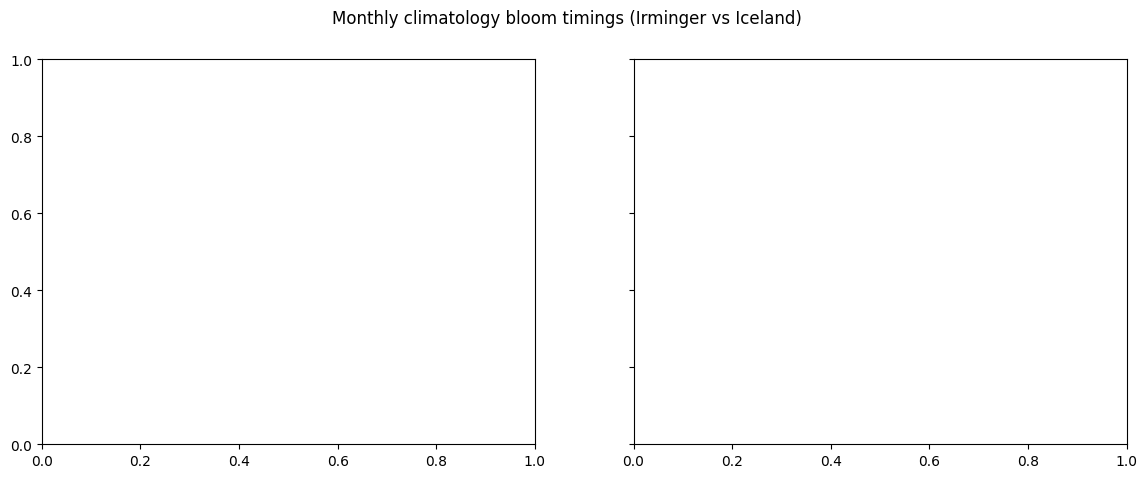

In [319]:
plot_seasonal_with_markers_two_panel(
    irm={
        "Integrated": {**int_timings_irm, "value_col": "DEPTH_INT_CHL_clim"},
        "10m": {**int_timings_irm_10m, "value_col": "DEPTH_INT_CHL_10m_clim"},
        "Satellite": {**int_timings_irm_sat, "value_col": "CHL"},
    },
    ice={
        "Integrated": {**int_timings_ice, "value_col": "DEPTH_INT_CHL_clim"},
        "10m": {**int_timings_ice_10m, "value_col": "DEPTH_INT_CHL_10m_clim"},
        "Satellite": {**int_timings_ice_sat, "value_col": "CHL"},
    },
    t_col="month",
    title="Monthly climatology bloom timings (Irminger vs Iceland)",
)